# Disaster Detection via Twitter

Ryan B. Jadrich

LinkedIn: [https://www.linkedin.com/in/ryan-jadrich-71190b5b](https://www.linkedin.com/in/ryan-jadrich-71190b5b)

Email: rjadrich@gmail.com

# 1. Project summary
---
**Goal:** Create a predictive model to classify a tweet as pertaining to a disaster event or not, *solely* based on the tweet text.

**Data:** 10,876 classified tweet entries in the "Disasters on Social Media" data set from CrowdFlower at http://www.crowdflower.com/data-for-everyone. Some examples of disasters include structural collapses, wildfires and terrorist attacks. However, this dataset also encompasses more "minor" events such as car accidents, etc. These were compiled by searching for tweets with disaster related keywords (i.e., hijacking, hurricane, and explosion) and then they were classified as "Relevant", "Not Relevant" or "Can't Decide" with "Relevant" indicating a disaster.

**Machine learning tools** 

1. **GENSIM** - For seamless transformation from a high dimensional "bag of words" (BOW) feature space to a lower dimensional "topic" space (each topic expresses discovered relations amongst the words in the Tweet data set using Latent Semantic Indexing or LSI).

2. **Scikit-Learn** - For trivial implementation the final Logistic Regression model which predicts "disaster" or "not disaster" based on each Tweets "topic" representation.

**Using the model**: Clone the entire Git repository to your local machine and install any packages not already installed (likely just GENSIM). All data used by the notebook is included in the repository so, in principle, the notebook should be ready to deploy and improve upon. Please let me know of any major improvements!   :) 

### **All of the required imports**

In [1]:
#Generic imports we will need
import numpy as np
import pandas as pd
import string
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities
from sklearn import linear_model
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import interp
import matplotlib.pyplot as plt
import sys
import json

#These are special modules that I built to streamline parsing, tokenization and the LSI step
import twitter_parser
import token_splicer
from latent_semantic_indexing import latent_semantic_indexer
%matplotlib inline 

# 2. Check out the data
---

In [2]:
df = pd.read_csv("data/tweets/disaster-tweets.csv")
print(df.columns)

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one', 'choose_one:confidence',
       'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid'],
      dtype='object')


**What is relevant?**

1. **_choose_one** - classification ("Relevant", "Not Relevant", or "Can't Decide")

2. **_choose_one_confidence** - the certainty of the final classification

3. **_text** - this is the actual tweet text

**Other, somewhat, relevant details**

1. **_golden** - "TRUE" or "FALSE" to indicate if the assigned classification is at the "golden" level, meaning hundreds of people voted on the classification. If not, five to six people voted on the classification. This is really supposed to be used as a final test set, but I don't do this.

2. **_unit_state** - indicates if the judgement on classifying the tweets is "finalized", "golden" (this is like super finalized) or "not finalized". All tweets are either "finalized" or "golden".

3. **keyword** - while not studied here, understanding what keywords are faithful indicators of disaster could be useful and improve model performance.

There are 10,876 total tweets with a fairly even representation of both "Relevant" and "Not Relevant" classes. Very few are labeled as "Can't Decide" and they will not be relevant to the binary model developed (discussed below).

**Only keep the columns relevant to this work**

In [3]:
df = df[["choose_one", "text", "choose_one:confidence"]]

**Check for any duplicate tweets and keep only one of the instances**

In [4]:
print("Total tweets: %d" % len(df))
df = df.drop_duplicates(subset = ["text"]).reset_index() #this also resets the index otherwise the numbers will have gaps
print("Total unique tweets: %d" % len(df))

Total tweets: 10876
Total unique tweets: 10678


Indeed, there were a bunch of duplicates! This may be due to re-tweeting and CrowdFlower not carefully checking for identical text.

# 3. Clean and tokenize all the tweets
---
**Employ custom tokenizer to:**
1. Convert hyphens and apostrophes from utf8 to ascii
2. Remove non-ascii mappable utf8 characters
3. Clean any HTML tags
4. Break on hyphens
5. Stem words
6. Reduce handles to only @ symbol
7. Reduce hashtags to # symbol and attempt to split text based on word probabilties (this works even if CamelCase is not used)
8. Reduce length (e.g., looooooovvvvveeee to love using word matching) and introduce special **|~exag~|** token
9. Replace the top 90% (http://www.datagenetics.com/blog/october52012/index.html) of emoticons with: **|~happy~|**, **|~sad~|**, **|~angry~|** and **|~suprised~|** tokens
10. Introduce special tokens
  * **|~num~|** for numbers (detect comma separation as in 1,000,000)
  * **|~num_alpha~|** for mixed numerical and alphabetical (maybe useful for interstates, planes, trains, ...) 
  * **|~num_units~|** for zero, one, ..., ten
  * **|~num_tens~|** for ten, twenty, ..., ninety
  * **|~num_scales~|** for hundred, thousand, ..., billion
  * **|~website~|** for any hyperlinks
  * **|~email~|** for emails
  * **|~phone_num~|** for phone numbers
  * **|~date~|** and **|~time|** for dates and times respectively
  * **|~heart~|** for <3 emoticon

**NOTE:** stop words (i.e., high frequency words like "and") are not removed as is commonly done in natural language processing tasks. Interestingly, keeping them helps improve the final model performance--perhaps by allowing for better word-word relations to be encoded in the discovered "topics".

**Pipeline for performing the full tokenizaton**

In [5]:
tokenize_it = twitter_parser.Tokenizer()

**Clean and tokenize the tweets**

In [6]:
df["text_tokenized_stemmed"] = df["text"].apply(tokenize_it.tweet_to_tokens)

['Just', 'happened', 'a', 'terrible', 'car', 'crash']
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
['Heard', 'about', '#earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.']
['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'pond', ',', 'geese', 'are', 'fleeing', 'across', 'the', 'street', ',', 'I', 'cannot', 'save', 'them', 'all']
['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', '.', 'Canada']
['All', 'residents', 'asked', 'to', "'shelter", 'in', "place'", 'are', 'being', 'notified', 'by', 'officers', '.', 'No', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']
['13,000', 'people', 'receive', '#wildfires', 'evacuation', 'orders', 'in', 'California']
['Just', 'got', 'sent', 'this', 'photo', 'from', 'Ruby', '#Alaska', 'as', 'smoke', 'from', '#wildfires', 'pours', 'into', 'a', 'school']
['#RockyFire', 'Update', '=>', 'California', 'Hwy', '.', '20', 'closed', 'i

['@PhilippaEilhart', '@DhuBlath', 'hurt', 'but', 'her', 'eyes', 'ablaze', 'with', 'insulted', 'anger', '.']
['@ablaze', 'what', 'time', 'does', 'your', 'talk', 'go', 'until', '?', 'I', "don't", 'know', 'if', 'I', 'can', 'make', 'it', 'due', 'to', 'work', '.']
["'I", "can't", 'have', 'kids', 'cuz', 'I', 'got', 'in', 'a', 'bicycle', 'accident', '&', 'split', 'my', 'testicles', '.', "it's", 'impossible', 'for', 'me', 'to', 'have', "kids'", 'MICHAEL', 'YOU', 'ARE', 'THE', 'FATHER']
['Accident', 'on', 'I-24', 'W', '#NashvilleTraffic', '.', 'Traffic', 'moving', '8m', 'slower', 'than', 'usual', '.', 'https://t.co/0GHk693EgJ']
['Accident', 'center', 'lane', 'blocked', 'in', '#SantaClara', 'on', 'US-101', 'NB', 'before', 'Great', 'America', 'Pkwy', '#BayArea', '#Traffic', 'http://t.co/pmlOhZuRWR']
['Accident', 'cleared', 'in', '#PaTurnpike', 'on', 'PATP', 'EB', 'between', 'PA-18', 'and', 'Cranberry', 'slow', 'back', 'to', '#traffic', 'http://t.co/SL0Oqn0Vyr']
['http://t.co/GKYe6gjTk5', 'Had', '

['@afterShock_DeLo', 'scuf', 'ps', 'live', 'and', 'the', 'game', '...', 'cya']
['Please', 'like', 'and', 'share', 'our', 'new', 'page', 'for', 'our', 'Indoor', 'Trampoline', 'Park', 'Aftershock', 'opening', 'this', 'fall', '!', '!', 'http://t.co/UgXhHErrxS']
['@bxckylynch', 'foi', 'no', 'ROH', 'Aftershock', ':', 'Las', 'Vegas', 'procura', 'no', 'pirate', 'bay', 'que', 'tem']
["'The", 'man', 'who', 'can', 'drive', 'himself', 'further', 'once', 'the', 'effort', 'gets', 'painful', 'is', 'the', 'man', 'who', 'will', 'win', '.', "'", 'Roger', 'Bannister']
['Schoolboy', '–', 'Aftershock', '(', 'Original', 'Mix', ')', 'Excision', '&', 'Skism', '–', 'SEXisM', '(', 'Far', 'Too', 'Loud', 'Remix', ')', 'Firebeatz', 'Schella', '–', 'Dear', 'New', '...', 'http://t.co/JQLzUA6YzQ']
['320', '[', 'IR', ']', 'ICEMOON', '[', 'AFTERSHOCK', ']', '|', 'http://t.co/yNXnvVKCDA', '|', '@djicemoon', '|', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices', '…', 'http://t.co/weQPesENku']
['320', '[', 'IR

['Experts', 'in', 'France', 'begin', 'examining', 'airplane', 'debris', 'found', 'on', 'Reunion', 'Island', ':', 'French', 'air', 'accident', 'experts', 'on', '...', 'http://t.co/TagZbcXFj0', '#MLB']
['Horrible', 'Accident', 'Man', 'Died', 'In', 'Wings', 'of', 'Airplane', '(', '29-07-2015', ')', 'http://t.co/5ZRKZdhODe']
['This', 'is', 'unbelievably', 'insane', '.', '#man', '#airport', '#airplane', '#aircraft', '#aeroplane', '#runway', '#accident', '#freaky', '…', 'https://t.co/cezhq7CzLl']
['Horrible', 'Accident', '|', 'Man', 'Died', 'In', 'Wings', 'of', 'Airplane', '(', '29-07-2015', ')', 'http://t.co/wq3wJsgPHL']
['Horrible', 'Accident', 'Man', 'Died', 'In', 'Wings', 'of', 'Airplane', '(', '29-07-2015', ')', 'http://t.co/TfcdRONRA6']
['Usama', 'bin', 'Ladins', 'family', 'dead', 'in', 'airplane', 'crash', '.', 'Naturally', 'no', 'accident', '.']
['Pilot', 'Dies', 'In', 'Plane', 'Crash', 'At', 'Car', 'Festival', 'https://t.co/kQ9aE6AP2B', 'via', '@YouTube', '#Crash', '#Aircraft', '#Ai

['The', 'episode', 'where', 'Trunks', 'annihilated', 'Freiza', 'is', 'the', 'cleanest', 'shit', 'ever', '.', 'He', 'showed', 'that', 'nigga', 'no', 'mercy', '.']
['THEY', 'SHALL', 'BE', 'ANNIHILATED', 'AND', 'ALL', 'OF', 'THEIR', 'PETEBESTS', 'DESSICATED', 'AND', 'LAID', 'BARE', '.', 'THEN', 'YOU', 'SHALL', 'KNEEL', 'BEFORE', 'ME', '.']
['Uribe', 'just', 'annihilated', 'that', 'baseball', '.', '#Mets']
['@marksmaponyane', 'Hey', '!', 'Sundowns', 'were', 'annihilated', 'in', 'their', 'previous', 'meeting', 'with', 'Celtic.Ind', 'eed', 'its', 'an', 'improvement', '.']
['The', 'bartender', 'at', 'work', 'described', 'a', 'drunk', 'man', 'as', 'annihilated', '@kdunning1919', '@hsnowberger', '@gabrielasmith29', '.', '16', 'more', 'days']
['@Volfan326', '@TNeazzy', 'Mizzou', 'has', 'annihilated', 'florida', 'the', 'past', '2', 'seasons', 'even', 'ended', "muschamp's", 'career', 'just', "can't", 'compete', 'with', 'Bama']
['Annihilated', 'Abs', '.', '?', '?', 'http://t.co/1xPw292tJe']
['Be', 

['Allied', 'Plans', 'for', 'the', 'Annihilation', 'of', 'the', 'German', 'People', 'http://t.co/RUHxGlo18q', 'http://t.co/HbUpkzWdWq', 'Louis', 'Nizer', '-', 'Very', 'interesting', '...']
['annihilating', 'quarterstaff', 'of', 'annihilation']
['World', 'Annihilation', 'vs', 'Self', 'Transformation', 'http://t.co/pyehwodWun', 'Aliens', 'Attack', 'to', 'Exterminate', 'Humans', 'http://t.co/pB2N77nSKz']
[':', 'StarMade', ':', ':', 'Stardate', '3:', ':P', 'lanetary', 'Annihilation', ':', ':', 'http://t.co/I2hHvIUmTm', 'via', '@YouTube']
['U', '.', 'S', 'National', 'Park', 'Services', 'Tonto', 'National', 'Forest', ':', 'Stop', 'the', 'Annihilation', 'of', 'the', 'Salt', 'River', 'Wild', 'Horse', '...', 'https://t.co/m8MvDSPJp7', 'via', '@Change']
['U', '.', 'S', 'National', 'Park', 'Services', 'Tonto', 'National', 'Forest', ':', 'Stop', 'the', 'Annihilation', 'of', 'the', 'Salt', 'River', 'Wild', 'Horse', '...', 'https://t.co/sW1sBua3mN', 'via', '@Change']
['Please', 'share', 'and', 'sign'

["She's", 'kinda', 'hot', 'played', 'on', 'the', 'radio', 'today', '.', "What's", 'next', '?', 'Disease', 'to', 'all', '?', 'The', 'apocalypse', 'has', 'started', 'everyone', '.', 'Be', 'careful', '.']
['#AskConnor', "there's", 'a', 'zombie', 'apocalypse', '.', 'the', 'item', 'to', 'your', 'right', 'is', 'your', 'weapon', '.', "you're", 'either', 'screwed', 'or', "you're", 'gonna', 'live', '.']
['But', 'if', "it's", 'the', 'apocalypse', 'lol', 'gf', 'm8']
['I', 'know', "it's", 'a', 'question', 'of', 'interpretation', 'but', 'this', 'is', 'a', 'sign', 'of', 'the', 'apocalypse', '.', 'I', 'called', 'it', 'https://t.co/my8q1uWIjn']
["It's", 'an', 'apocalypse']
['Julie', '+', 'R', 'is', 'the', 'apocalypse', 'version', 'of', 'Romeo', '+', 'Juliet', '#warmbodies']
['the', 'apocalypse', 'is', 'upon', 'us']
['@ItsKingRiffYall', "I'm", 'excited', 'for', 'apocalypse', 'really', 'dig', 'how', 'the', 'x', '-', 'men', 'franchise', 'is', 'going', 'I', 'like', 'the', "'event'", 'theme', 'a', 'lot', '

['@RohnertParkDPS', "You're", 'another', 'one', 'for', 'the', 'history', 'books', '!', '(', 'Thank', 'the', 'Justice', 'Department', '!', ')', 'And', 'by', 'the', 'way', 'I', "haven't", 'paid', 'income', 'tax', 'in', '20yrs', '.']
['Vladimir', 'Putin', 'Issues', 'Major', 'Warning', 'But', 'Is', 'It', 'Too', 'Late', 'To', 'Escape', 'Armageddon', '?', 'http://t.co/gBxafy1m1C']
["God's", 'Kingdom', '(', 'Heavenly', "Gov't", ')', 'will', 'rule', 'over', 'all', 'people', 'on', 'the', 'earth', 'after', 'Armageddon', '.', 'http://t.co/8HGcBXUkz0', 'http://t.co/4kopkCyvTt']
['#Turkey', 'invades', '#Israel', '-', 'Halfway', 'to', '#Armageddon', 'http://t.co/xUOh3sJNXF']
['L', 'B', '#Entertainment', 'lot', 'of', '8', '#BruceWillis', 'MOVIES', '#DVD', 'DIE', 'HARD', '1 2 12', 'MONKEYS', 'ARMAGEDDON', 'SIXTH', '#eBay', '#Auction', 'http://t.co/CxDJApzXMP']
['Let', '’', 's', 'talk', 'some', 'more', 'about', 'your', 'goof', 'guild', 'Saunders', '.', 'Come', 'right', 'up', 'here', 'on', 'stage', '.',

['@AP', 'what', 'a', 'violent', 'country', 'get', 'the', 'army', 'involved', 'to', 'help', 'control', 'the', 'killings', 'and', 'bring', 'back', 'peace', 'to', 'the', 'poor', 'people', '.']
['ANSWER', ':', "'Therefore", 'it', 'came', 'to', 'pass', 'that', 'in', 'my', 'sixteenth', 'year', 'I', 'did', 'go', 'forth', 'at', 'the', 'head', 'of', 'an', 'army', 'of', 'the', '...', 'http://t.co/uuAAsb394n']
['WWI', 'WWII', 'JAPANESE', 'ARMY', 'NAVY', 'MILITARY', 'JAPAN', 'LEATHER', 'WATCH', 'WAR', 'MIDO', 'WW1', '2', '-', 'Full', 'read', 'by', 'eBay', 'http://t.co/QUmcE7W2tY', 'http://t.co/KTKG2sDhHl']
['One', 'Direction', 'Is', 'my', 'pick', 'for', 'http://t.co/q2eBlOKeVE', 'Fan', 'Army', '#Directioners', 'http://t.co/eNCmhz6y34', 'x1424']
['WWI', 'WWII', 'JAPANESE', 'ARMY', 'NAVY', 'MILITARY', 'JAPAN', 'LEATHER', 'WATCH', 'WAR', 'MIDO', 'WW1', '2', '-', 'Full', 'read', 'by', 'eBay', 'http://t.co/obfD7e4QcP', 'http://t.co/yAZjE5OwVk']
['One', 'Direction', 'Is', 'my', 'pick', 'for', 'http://t.

['Alleged', 'East', 'Bay', 'serial', 'arsonist', 'arrested', 'http://t.co/WR48AQTUm7']
['@local_arsonist', '@Cloudy_goldrush', 'Man', 'what', '?', '?', '?', '?', 'they', 'be', 'on', 'some', 'other', 'shit']
['mo', 'the', 'way', 'she', 'says', "'carry'", 'https://t.co/vQzRUTHRNU']
['@Safyuan', 'just', 'a', 'minor', 'citation', 'for', 'possesion', 'of', 'a', 'decriminalized', 'substance', 'im', 'not', 'facing', 'any', 'time']
['Suspected', 'serial', 'arsonist', 'arrested', 'in', 'Calif', '.', 'http://t.co/PzotPDGAkI']
['Arsonist', 'Sets', 'NYC', 'Vegetarian', 'Restaurant', 'on', 'Fire', ':', 'Police', '#NewYork', '-', 'http://t.co/agn4cL4uSK']
['Arson', 'suspect', 'linked', 'to', '30', 'fires', 'caught', 'in', 'Northern', 'California', 'http://t.co/mmGsyAHDzb']
['@local_arsonist', '@diamorfiend', 'the', 'legal', 'system', 'NEVER', 'forgets']
['@Casper_rmg', 'u', 'on', 'dick']
['Bloor', '/', 'Ossington', 'arsonist', 'also', 'burned', 'a', 'mattress', 'on', 'Northumberland', 'St', '#cbcto'

['#People', '#Tilly', 'the', '#Confused', 'Cat', 'Overcomes', 'Horrible', 'Attack', 'to', 'Win', 'Hearts', 'http://t.co/QtrsYxFzo3']
['Police', ':', 'Assailant', 'in', 'latest', 'US', 'movie', 'theatre', 'attack', 'was', 'homeless', 'had', 'psychological', 'issues', 'http://t.co/zdCvlYq6qK']
['To', 'love', 'you', 'love', 'you', 'love', 'you', '...', 'Massive', 'Attack', '-', 'Angel', '(', 'HD', ')', 'https://t.co/9TW34Gffox', 'v', 'ía', '@YouTube']
['@CaIxxum5SOS', 'thanks', 'for', 'the', 'damn', 'heart', 'attack']
['Suspect', 'in', 'latest', 'US', 'theatre', 'attack', 'had', 'psychological', 'issues', 'http://t.co/OnPnBx0ZEx', 'http://t.co/uM5IcN5Et2']
['India', 'shud', 'not', 'give', 'any', 'evidence', '2', 'pak.The', 'y', 'will', 'share', 'with', 'terrorists', '&', 'use', 'for', 'next', 'attack.Sha', 're', 'with', 'oth', 'contries', 'https://t.co/qioPbTIUVu']
['illegal', 'alien', 'released', 'by', 'Obama', '/', 'DHS', '4', 'times', 'Charged', 'With', 'Rape', '&', 'Murder', 'of', 'Sa

['@christinalavv', '@lindsay_wynn3', 'I', 'just', 'saw', 'these', 'tweets', 'and', 'I', 'feel', 'really', 'attacked']
['Christian', 'Attacked', 'by', 'Muslims', 'at', 'the', 'Temple', 'Mount', 'after', 'Waving', 'Israeli', 'Flag', 'via', 'Pamela', 'Geller', '-', '...', 'http://t.co/a6wmbnR51S']
['Christian', 'Attacked', 'by', 'Muslims', 'at', 'the', 'Temple', 'Mount', 'after', 'Waving', 'Israeli', 'Flag', 'via', 'Pamela', 'Geller', '-', '...', 'http://t.co/ETg0prBP4G']
['Christian', 'Attacked', 'by', 'Muslims', 'at', 'the', 'Temple', 'Mount', 'after', 'Waving', 'Israeli', 'Flag', 'via', 'Pamela', 'Geller', '-', '...', 'http://t.co/yUBKHf9iyh']
['TV', 'program', 'I', 'saw', 'said', 'US', 'air', 'plane', 'flew', 'to', 'uranium', 'mine', 'in', 'Fukushima', 'and', 'attacked', 'by', 'machine', 'gun', 'when', 'student', 'army', 'were', 'digging', 'it', '.']
['Christian', 'Attacked', 'by', 'Muslims', 'at', 'the', 'Temple', 'Mount', 'after', 'Waving', 'Israeli', 'Flag', 'via', 'Pamela', 'Gelle

['Now', "there's", 'an', 'avalanche', '...', 'These', 'men', 'are', 'lunatics', '#livingontheedge']
['Chevrolet', ':', 'Avalanche', 'LT', '2011', 'lt', 'used', '5.3', 'l', 'v', '8 16', 'v', 'automatic', '4', 'wd', 'pickup', 'truck', 'premium', 'b', '…', 'http://t.co/OBkY8Pc89H', 'http://t.co/dXIRnTdSrd']
['No', 'snowflake', 'in', 'an', 'avalanche', 'ever', 'feels', 'responsible', '.']
['STAR', 'WARS', 'POWER', 'OF', 'THE', 'JEDI', 'COLLECTION', '1', 'BATTLE', 'DROID', 'HASBRO', '-', 'Full', 'read', 'by', 'eBay', 'http://t.co/xFguklrlTf', 'http://t.co/FeGu8hWMc4']
['CIVIL', 'WAR', 'GENERAL', 'BATTLE', 'BULL', 'RUN', 'HERO', 'COLONEL', '2nd', 'NEW', 'HAMPSHIRE', 'LETTER', 'SIGNED', '!', 'http://t.co/Ot0tFFpBYB', 'http://t.co/zaRBwep9LD']
['Dragon', 'Ball', 'Z', ':', 'Battle', 'Of', 'Gods', '(', '2014', ')', '-', 'Rotten', 'Tomatoes', 'http://t.co/jDDNhmrmMJ', 'via', '@RottenTomatoes']
['I', 'added', 'a', 'video', 'to', 'a', '@YouTube', 'playlist', 'http://t.co/wedWyn9kfS', 'World', 'Of',

['#BreakingNews', 'http://t.co/gAN14PW9TG', 'FedEx', 'no', 'longer', 'willing', 'to', 'transport', 'research', 'specimens', 'of', 'potential', 'bioter', '…', 'http://t.co/5n4hUsewLy']
['FedEx', 'no', 'longer', 'to', 'transport', 'bioterror', 'germs', 'in', 'wake', 'of', 'anthrax', 'lab', 'mishaps', 'http://t.co/RghHkWtKLR', '#newsdict', '#news', '#FedEx']
['FedEx', 'no', 'longer', 'to', 'transport', 'bioterror', 'germs', 'in', 'wake', 'of', 'anthrax', 'lab', 'mishaps', 'http://t.co/c0p3SEsqWm', 'via', '@usatoday']
['FedEx', 'stops', 'shipping', 'potential', 'bioterror', 'pathogens', 'http://t.co/tkeOAeDQKq', '#trucking']
['FedEx', 'no', 'longer', 'to', 'transport', 'bioterror', 'germs', 'in', 'wake', 'of', 'anthrax', 'lab', 'mishaps', 'http://t.co/MqbYrAvK6h']
['#FedEx', 'no', 'longer', 'to', 'transport', 'bioterror', 'germs', 'in', 'wake', 'of', 'anthrax', 'lab', 'mishaps', 'http://t.co/S4SiCMYRmH']
['FedEx', 'no', 'longer', 'shipping', 'bioterror', 'germs', '-', 'WXIA', '-', 'TV', '|

['The', '#IranDeal', 'only', 'covers', 'nuclear', 'activity', '.', 'What', 'are', 'they', 'doing', 'about', 'Bioterrorism', '?', 'Iran', 'has', 'broken', 'at', 'least', '27', 'other', 'agreements', '.']
['@prsnvns', "that's", 'good', 'to', 'hear', '.', 'Mine', 'could', 'be', 'better', 'but', 'I', 'can', 'manage', '.', "It's", 'alright', 'you', 'do', 'what', 'you', 'have', 'to', '.', 'Bioterrorism', "doesn't", 'wait', '.']
['The', 'Threat', '|', 'Anthrax', '|', 'CDC', 'http://t.co/q6oxzq45VE', 'via', '@CDCgov']
['@mariashriver', 'Was', "'", '@FultonInfo', "'Court", 'trip', '2', 'keep', 'strangers', '-', 'BLK', '&', 'WHT', '-', 'from', "us'g", 'my', '@SSAPress', 'ID', 'or', '2', 'forfeit', '2', 'them', 'due', '2', 'Bioterrorism', 'look', '?', '@AP']
['#bioterrorism', 'Authorities', 'allay', '#glanders', 'fears', 'ahead', 'of', 'Rio', 'Olympic', 'equestrian', 'test', 'event', 'http://t.co/UotPNSQpz5', 'via', '@HorsetalkNZ']
['@Kaotix_Blaze', 'craving', 'u']
["I've", 'been', 'by', 'the', '

['I', 'checked', 'in', 'at', 'Blazing', 'Horse', 'Tattoo', 'on', '#Yelp', 'http://t.co/z8nXWmYMWA']
['SHOUOUT', 'TO', '@kasad1lla', 'CAUSE', 'HER', 'VOCALS', 'ARE', 'BLAZING', 'HOT', 'LIKE', 'THE', 'WEATHER', 'SHES', 'IN']
['S3XLEAK', '!', '!', '!', 'Ph0tos', 'of', '19yrs', 'old', 'Ash', '@wo', 'lady', 'in', 'Festac', 'town', 'from', 'Delta', 'exp0sed', 'on', 'BBM', '5', 'leaked', 'pictures', '...', 'http://t.co/ixREhM05yq']
['Oh', 'my', 'heart', 'racing', 'And', 'my', 'temperature', 'is', 'blazing', 'through', 'the', 'roof', '#VideoVeranoMTV', 'Fifth', 'Harmony']
['@omgbethersss', '@BethanyMota', 'haha', 'love', 'this', '?', '?']
['The', 'midnight', 'song', 'I', 'cry', 'out', 'goes', "'In", 'reality', 'I', '...', 'in', 'reality', 'I', '...', 'was', 'very', "lonely'", 'Even', 'if', 'it', 'is', 'erased', 'by', 'the', 'blazing', 'sun']
['@dmac1043', 'Colorado', 'is', 'a', 'Spanish', 'word', '(', '[', 'Latin', 'origin', ']', 'meaning', "'reddish'", 'or', "'colored'", ')', 'all', 'you', 'd

['@KatRamsland', 'Yes', "I'm", 'a', 'bleeding', 'heart', 'liberal', '.']
['Deadpool', 'is', 'already', 'one', 'of', 'my', 'favourite', 'marvel', 'characters', 'and', 'all', 'I', 'know', 'is', 'he', 'wears', 'a', 'red', 'suit', 'so', 'the', 'bad', 'guys', "can't", 'tell', 'if', "he's", 'bleeding']
['@Aichmomanic', 'wraps', 'a', 'cloth', 'on', 'my', 'wound', 'but', "it's", 'still', 'bleeding', "'I'll", 'be', 'ok', '.', "'", 'Falls', 'to', 'the', 'ground', 'as', 'if', "I'm", 'going', 'to', 'die']
['my', 'ears', 'are', 'bleeding', 'https://t.co/EeVQj37Ndg']
['@beckyfeigin', 'I', 'defs', 'will', 'when', 'it', 'stops', 'bleeding', '!']
['@SoDamnTrue', 'we', 'know', 'who', 'u', 'are', "you're", 'a', 'bleeding', 'heart', 'wannabe', 'pickup', 'artist']
['@chaosmagician97', 'awesome', '!', '!', 'I', 'saw', 'he', 'was', 'bleeding', 'pretty', 'bad']
['@dudeandpal', "it's", 'so', 'bad', 'my', 'eyes', 'and', 'ears', 'are', 'bleeding']
['@burberryant', 'bleeding', 'on', 'the', 'brain', "don't", 'know

['@Daorcey', '@nsit_', 'YOUR', 'a', 'great', 'pair', '.', 'Like', 'a', 'couple', 'of', 'Graywardens', 'fighting', 'the', 'blight', '...']
['@DaMidnighter', 'theres', 'actually', 'a', 'theory', 'out', 'there', 'that', 'the', 'magisters', 'arent', 'the', 'only', 'reason', 'for', 'the', 'blight', 'that', 'dwarves', '(', 'the', 'ones', 'from', 'the']
['THDA', 'Kicks', 'Off', 'Anti', '-', 'Blight', 'Loan', 'Effort', 'in', 'Memphis', 'http://t.co/7Gf7CpYL0R']
['As', 'a', 'cycling', 'fan', 'I', 'feel', 'sorry', 'for', 'world', 'athletics', '#doping', 'is', 'a', 'blight', 'exacerbated', 'monetary', 'reward', '.', 'A', 'lot', 'of', 'soul', 'searching', 'will', 'be', 'required']
['.', '@WestmdCountyPA', 'land', 'bank', 'targets', 'first', '#Latrobe', 'building', 'in', '20th', 'property', 'acquisition', 'to', 'fight', '#blight', ':', 'http://t.co/regDv873Aj']
['@kynespeace', '*', 'blight']
['Lots', 'of', 'talk', 'of', 'how', 'susceptible', 'NY2', 'is', 'to', 'shoot', 'blight', 'with', 'or', 'with

['A', 'blizzard', 'would', 'be', 'clutch', 'asf', '?', '?']
['@Blizzard_draco', '@LoneWolffur', 'also', 'me', 'please', 'I', 'would', 'very', 'much', 'like', 'a', 'link']
['@BubblyCuteOne', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'ok', 'ok', 'okayyyyyy', 'Ima', 'act', 'right', '....', 'bout', 'to', 'get', 'this', 'blizzard', 'tho']
['@LoneWolffur', 'control', 'yourself', 'tora']
['the', 'Internet', 'is', 'sending', 'subliminal', 'messages', 'about', 'ice', 'cream', 'therefore', 'I', 'need', 'a', 'blizzard', 'rn']
['First', 'Time', 'Playing', 'Hearthstone', 'on', 'PC', 'Thoughts', 'http://t.co/aBoLxMH1vy']
['I', 'love', 'the', 'cotton', 'candy', 'blizzard', '?', '?']
['@TCGReno', 'just', 'hard', 'reset', 'my', 'Xbox']
['Whoa', '!', 'This', 'new', 'legend', 'will', 'be', 'fun', '!', 'http://t.co/hu5CmoupUM']
['I', 'really', 'wanna', 'brownie', 'batter', 'blizzard', '?', '?']
['I', 'call', 'it', 'a', 'little', 'bit', 'of', 'your', 'blizzard', '?']
['Market', 'News', ':', 'Activi

['@tomm3h', "You've", 'been', 'on', 'Twitter', 'since', '2008', '?', '!', 'Bloody', 'hell', '.', 'Veteran', '!']
['You', 'call', 'them', 'weekends', '.', 'I', 'call', 'them', 'Bloody', 'Mary', 'times', '.', 'This', "summer's", 'been', 'full', 'of', 'them', '.', 'My', 'new', '…', 'https://t.co/VnNi3zzuZ6']
['Bloody', 'hell', 'what', 'a', 'day', '.', 'I', "haven't", 'even', 'really', 'done', 'anything', '.', 'Just', '.', 'Tired', '.', 'Of', 'everything', '.', 'Thought', 'vaca', 'would', 'help', 'but', 'it', 'only', 'did', 'so', 'much', '.', '=/']
['Damn', 'bloody', 'hot']
['@MrTophyPup', "it's", 'bloody', 'sexy', '*', 'drools', '*']
['You', 'know', 'how', 'they', 'say', 'the', 'side', 'effects', 'low', '&', 'really', 'fast', '?', 'Son', 'the', 'product', 'was', 'an', 'acne', 'cream', '..', 'Why', '1', 'of', 'the', 'side', 'effects', 'was', 'bloody', 'diarrhea', '?']
['Ronda', 'Rousey', 'would', 'be', "'close'", 'to', 'making', 'Floyd', "Mayweather's", 'money', 'in', '50', 'fights', '-', 

['We', 'are', 'now', 'up', 'to', 'run', 'no', '.', '24', 'in', 'the', 'singles', '.', 'The', 'rain', 'has', 'blown', 'off', 'again', '.']
['Damn', '!', '@LastWitchHunter', 'has', 'blown', 'up', 'my', 'Twitter', 'feed', '.', 'Looks', 'amazing', '!']
['@luke_winkie', 'Whoever', 'is', 'directing', 'these', 'videos', 'needs', 'to', 'grab', 'up', 'Nicki', 'Minaj', 'or', 'someone', 'with', 'U', '.', 'S', '.', 'recognition', 'so', 'minds', 'can', 'be', 'blown', '.']
['@PrincessDuck', 'last', 'week', 'wanted', 'the', '6th', 'sense', 'to', 'get', 'blown', 'up', 'so', 'far', 'so', 'good', '.', 'James', 'could', 'win', 'but', "he's", 'a', 'huge', 'target', 'and', 'will', 'be', 'gone', 'soon', '.']
['@MalikChaimaa', 'I', 'hope', 'Zayn', 'gets', 'blown', 'up', 'in', 'a', 'drone', 'attack', 'whilst', 'visiting', 'family', 'in', 'Pakistan', '?', '?']
['@orbette', 'more', 'like', 'BLOWN', 'UP', 'amirite']
['My', 'dog', '’', 's', 'just', 'blown', 'his', 'kennel', 'up', '–', 'Bloody', 'Yorkshire', 'Terr

['@ohmyloz', '@RondaRousey', 'who', 'is', 'bagging', 'her', 'body', '?', "She's", 'smoking', 'hot', '?', '?']
['Drake', 'is', 'really', 'body', 'bagging', 'meek']
['@fuckyeahcarey', '@BornVerified', 'drake', 'killing', 'this', 'dude', 'and', 'tea', 'bagging', 'the', 'dead', 'body', 'at', 'this', 'point']
['People', 'are', 'bagging', 'on', "Rousey's", 'body', '?', 'Shit', "I'd", 'love', 'to', 'have', 'a', 'body', 'like', 'that', '.', 'Those', 'who', 'are', 'ridiculing', 'her', 'are', 'probably', 'dudes', 'in', 'skinny', 'jeans']
['Bagging', 'the', 'last', 'spot', 'on', 'Body', 'Attack', '?', '?', '?', '?', '?', '?', '#getin', '#traintuesday', '#lesmills']
['@MeekMill', 'is', 'w', '(', 'rec', ')', 'k', 'league', 'ball', '@Drake', 'is', 'Olympic', 'level', 'body', 'bagging', 'him', 'like', 'his', 'career', 'was', 'nothing', '#trollingtilMeekdiss']
["'", 'Dear', 'Lord', 'Forgive', 'Me', 'For', 'Body', 'Bagging', '@MeekMill', 'Not', 'Once', 'But', 'Twice', '.', 'Amen', "'", '-', '@Drake', '

['@LennGoneWin', 'nah', 'man', 'we', 'need', 'to', 'be', 'defenseless', 'from', 'thugs', 'so', 'when', 'the', 'cops', 'get', 'there', 'we', 'can', 'get', 'put', 'in', 'cool', 'new', 'body', 'bags', '!']
['@ComplexMag', 'he', 'asking', 'for', 'a', 'body', 'bags', '@PUSHA_T']
['BODY', 'BAGS', '!', 'https://t.co/0McXc68GZD']
['RT', 'Hamosh84', ':', 'This', 'how', 'the', '#Saudi', 'is', 'coming', 'home', 'from', '#Yemen', 'in', 'body', 'bags', '.', 'For', 'what', '?', '#Saudi', 'Kingdom', 'ego', '?', "You're", 'loo', '…', 'http://t.co/LJlKWGXgjY']
['you', 'know', 'you', 'hate', 'your', 'body', 'when', 'you', 'buy', '2', 'bags', 'of', 'chips', 'and', 'a', 'variety', 'pack', 'of', 'fruit', 'snacks', 'and', 'a', 'redbull', 'as', 'a', 'snack']
['BREAKING', ':', 'Fairfax', 'County', 'firefighter', 'placed', 'on', 'admin', 'leave', 'amid', 'probe', 'into', 'Facebook', 'post', 'about', 'putting', 'police', 'in', "'body", "bags'", 'dept', '.', 'says', '.']
['Womens', 'Buckle', 'Casual', 'Stylish',

['@jonathanshainin', 'I', 'think', 'the', 'bomb', 'raises', 'all', 'sorts', 'of', 'great', 'questions', 'but', 'this', "isn't", 'one', 'of', 'them']
['Why', 'American', 'censors', 'supressed', 'accounts', 'of', 'suffering', 'in', 'Nagasaki', 'http://t.co/kZbeas50KE', 'http://t.co/YQgpaSX3MG']
['@danielsahyounie', "It'd", 'be', 'so', 'bomb', 'if', 'u', 'guys', 'won', '?', '?']
['New', 'Documents', 'Found', 'Pointing', 'To', "Japan's", 'WWII', 'Atomic', 'Bomb', 'Program', 'http://t.co/M9mowCMVNj']
['Hiroshima', 'marks 70', 'years', 'since', 'bomb', 'http://t.co/3u6MDLk7dI']
['The', 'crew', 'on', '#EnolaGay', 'had', 'nuclear', 'bomb', 'on', 'board', 'disarmed', '.', '15', 'mins', 'to', '#Hiroshima', 'they', 'got', 'ready', 'to', 'arm', 'Little', 'Boy', 'http://t.co/JB25fHKe6q']
['What', 'if', 'your', 'hometown', 'were', 'hit', 'by', 'the', 'Hiroshima', 'atomic', 'bomb', '?', 'http://t.co/XuWN4McgYp', '#safemode']
['@dopeitsval', 'ahh', "you're", 'bomb', 'baby', '?', '?']
['When', 'you', '

['@KurtSchlichter', '@FALPhil', 'This', 'liberal', 'compassion', 'is', 'BS', '.', 'A', 'specific', 'Feminist', 'said', 'the', 'US', 'bombed', 'Japan', 'back', 'to', 'traditional', 'sexist', 'values', '.']
['http://t.co/wMNOnHxEIr', "'Nagasaki", 'has', 'to', 'be', 'forever', 'the', 'last', 'city', 'bombed', 'with', 'a', 'nuclear', 'weapon', '.', "'", '#bannukes']
['Ladies', "here's", 'how', 'to', 'recover', 'from', 'a', '#date', 'you', 'totally', 'BOMBED', '...', 'according', 'to', 'men', 'http://t.co/c5GGSZUGw1', 'http://t.co/2PiMg9BIcE']
['Picture', 'of', 'cute', 'sleeping', 'puppy', 'photo', 'bombed', 'by', 'the', 'demon', 'in', 'the', 'back', '.', 'https://t.co/LprYzSTK4u']
['@r_lauren83199', '@xojademarie124', 'i', 'hope', 'you', 'get', 'Batista', 'Bombed', 'lauren']
['.', '@Vagersedolla', 'visits', 'villages', 'recently', 'bombed', 'by', 'Turkey', 'and', 'finds', 'people', 'fed', 'up', 'with', 'the', 'PKK', 'http://t.co/UUWEiKD7sP']
['@antpips67', '@JohnEJefferson', 'obviously', "

["Australia's", 'Ashes', 'disaster', '-', 'how', 'the', 'collapse', 'unfolded', 'at', 'Trent', 'Bridge', '...', 'http://t.co/Dq3ddGvgBF', '#cricket']
['BREAKING', 'NEWS', ':', 'Australia', 'collapse', 'to', 'a', 'hapless', '60', 'all', 'out', 'at', 'Trent', 'Bridge', 'http://t.co/O2CFWDzZld']
['Sioux', 'City', 'Fire', 'Officials', 'Believe', 'Bridge', 'Collapse', 'Lead', 'To', 'Cement', 'Truck', 'Roll', 'Over', '-', 'Siouxland', 'Matters', ':', 'Siouxlan', '...', 'http://t.co/sZTGmbkoHG']
['Ashes', '2015', ':', 'Australia', '’', 's', 'collapse', 'at', 'Trent', 'Bridge', 'among', 'worst', 'in', 'history', ':', 'England', 'bundled', 'out', 'Australia', 'for', '60', '...', 'http://t.co/985DwWPdEt']
['2', 'Injured', '1', 'missing', 'in', 'bridge', 'collapse', 'in', 'central', 'Mexico', 'http://t.co/kHF0iH05A9']
['Project', 'Syndicate', ':', 'A', 'Marshall', 'Plan', 'for', 'the', 'United', 'States', ':', 'http://t.co/lz8xmyi75x']
['I', 'never', 'knew', 'about', 'the', 'relationship', 'btwn'

['kou', 'is', 'like', '[', 'CASH', 'REGISTER', ']', '[', 'BUILDINGS', 'BURNING', ']']
['@_minimehh', '@cjoyner', 'I', 'must', 'be', 'overlooking', 'the', 'burning', 'buildings', '?', '#BlackLivesMatter']
['@fewmoretweets', 'all', 'lives', 'matter', '.', 'Just', 'not', 'a', 'fan', 'of', 'burning', 'down', 'buildings', 'and', 'stealing', 'from', 'your', 'neighbors', 'to', "'protest'"]
['a', 'very', 'scary', 'thought', 'is', 'if', '9/11', 'had', 'happened', 'today', 'their', 'would', 'be', 'teenagers', 'taking', 'selfies', 'in', 'front', 'of', 'the', 'burning', 'buildings']
['THIS', 'SOUNDS', 'LIKE', 'A', 'SONG', 'YOU', 'WOULD', 'HEAR', 'IN', 'A', 'MOVIE', 'WHERE', 'THEY', 'ARE', 'WALKING', 'AWAY', 'FROM', 'BURNING', 'BUILDINGS', 'AND', 'CARS', 'AND', 'SHIT']
['The', 'greatest', 'female', 'beat', 'boxer', 'ever', 'now', 'but', "it's", 'w', '/', 'e', '...', 'Save', 'babies', 'outta', 'burning', 'buildings', 'on', 'my', 'free', 'time', 'but', 'ya', 'know', '..', 'whatevs', '..']
['@CTVKathy

["'Failure", 'doesn', '’', 't', 'exist', '.', 'It', '’', 's', 'only', 'a', 'change', 'of', "direction'", '-', 'Alejandro', 'Jodorowsky', '(', 'via', 'buildings', '-', 'on', '-', 'fire', ')', 'http://t.co/ByMVemW4xF']
['Buildings', 'are', 'on', 'fire', 'and', 'they', 'have', 'time', 'for', 'a', 'business', 'meeting', '#TheStrain']
['Ton', 'of', 'smoke', 'coming', 'out', 'of', 'one', 'of', 'the', 'new', 'apartment', 'buildings', 'at', '160', 'Ross', 'in', 'Auburn', '.', 'Several', 'fire', 'trucks', 'on', 'scene', '.', 'http://t.co/AHVYmSQHqC']
["I'm", 'security', 'so', 'they', 'want', 'me', 'to', 'help', 'out', 'in', 'case', 'of', 'emergency', 'like', 'the', 'buildings', 'on', 'fire', 'or', 'a', "shooter's", 'in', 'the', 'building', '.', "I'm", 'leaving', 'tho', '..']
['@blainescronuts', 'thats', 'what', 'i', 'would', 'do', 'if', 'there', 'were', 'buildings', 'on', 'fire']
['fucking', 'apartments', 'across', 'the', 'street', 'are', 'on', 'fire', 'right', 'now', '.', '5', 'fuckin', 'firet

['It', 'hurts', 'for', 'me', 'to', 'eat', 'cause', 'i', 'burned', 'my', 'tounge', 'with', 'a', 'pepperoni', 'yesterday', '!']
['burned', '163', 'calories', 'doing', '30', 'minutes', 'of', 'Total', 'Body', 'Cardio', '#21dayfix', '#myfitnesspal']
['I', 'spent', '15', 'minutes', 'lifting', 'weights', '.', '43', 'calories', 'burned', '.', '#LoseIt']
['Holy', 'fuck', 'QVC', 'bitch', 'just', 'got', 'burned', 'so', 'hard', '.']
['Corey', 'White', 'talking', 'all', 'dat', 'shit', 'but', 'he', 'got', 'burned', 'more', 'than', 'curlin', 'irons', 'on', 'black', 'women', 'necks']
['@BlackHatWriter', 'Yeah', "I'm", 'going', 'to', 'be', 'at', 'home', 'by', 'a', 'computer', 'for', 'the', 'next', 'two', 'weekends', '.', ':(', 'Getting', 'really', 'burned', 'out', 'really', 'quick', '.']
['I', 'just', 'remembered', 'the', "McDonald's", 'that', 'burned', 'down', 'used', 'to', 'have', 'the', 'coolest', 'play', 'ground', '&', 'the', 'new', 'one', "ain't", 'got', 'shit', 'but', 'video', 'games', ')', '):']

['The', 'Arab', 'autocracies', ':', 'Burning', 'down', 'their', 'house', 'http://t.co/xcjRamGQ22', 'via', '@TheEconomist']
['@TarekFatah', 'you', 'are', 'burning', 'in', 'enemity', 'of', 'Pakistan', '.', 'i', 'm', 'sure', 'you', 'will', 'burn', 'more', 'and', 'more']
['@Rubi_', 'How', 'many', 'stacks', 'of', 'burning', 'did', 'it', 'apply', '?']
['Parents', 'are', 'taking', 'their', 'kids', 'to', 'Burning', 'Man', 'and', 'one', '11', 'year', 'old', 'thinks', "it's", "'better", 'than', '...', 'http://t.co/wp6V1BHhoQ']
['@Michael5SOS', 'haha', 'so', 'would', 'you', 'say', 'its', 'so', 'hot', 'your', 'balls', 'are', 'burning', 'off', '?', '?', '?', '?']
['Why', 'put', 'out', 'a', 'fire', "that's", 'still', 'burning', '?']
['@8', 'goingon80', 'I', 'put', 'on', 'a', 'ton', 'of', 'sunscreen', 'and', "I'm", 'still', 'burning', ':/']
['Blizzard', 'details', 'new', 'Dungeons', 'and', 'Raids', 'in', 'World', 'of', 'Warcraft', ':', 'Legion', ':', 'The', 'Burning', 'Legion', '…', 'http://t.co/8IBA

["'When", 'you', 'attack', "women's", 'health', 'you', 'attack', "America's", 'health', '.', "'", 'Hillary', 'Clinton', 'shows', 'how', 'to', '#StandwithPP', 'http://t.co/HXdG254dHO']
['On', 'holiday', 'to', 'relax', 'sunbathe', 'and', 'drink', '...', 'Putting', 'out', 'bush', 'fires', '?', 'Not', 'so', 'much', '?', '?', '#spain', 'https://t.co/dRno7OKM21']
['Bush', '#food', 'fires', ':', 'http://t.co/Q1Y8lm7us9', 'http://t.co/TofLxOdyrX']
['Californian', 'Bush', 'Fires', '2015', 'http://t.co/rjdX29wosp']
['28', 'Oct 18', '95', ':', "'Bush", 'Fires', '.', "'", 'http://t.co/zCKXtFc9PT']
['@dacherryontop13', 'ohh', 'there', 'are', 'bush', 'fires', 'in', 'Spain', 'like', 'every', 'year', 'one', 'time', 'when', 'we', 'went', 'swimming', 'there', 'were', 'planes', 'getting', 'water', 'to', 'fight']
['Bush', 'Fires', 'are', 'scary', '....', 'even', 'scarier', 'when', 'you', 'go', 'down', 'and', 'fight', 'them']
['[', 'WATCH', ']', 'Mother', 'Nature', 'halts', 'Australia', 'Blue', 'Mountains'

['News', 'Wrap', ':', 'UN', 'warns', 'female', 'and', 'child', 'casualties', 'are', 'on', 'the', 'rise', 'in', 'Afghanistan', 'http://t.co/vSvY1qe69t', '#pbs', '#iraq']
['“', 'The', 'road', 'to', 'power', 'is', 'paved', 'with', 'hypocrisy', 'and', 'casualties', '.', '”', '#FrancisUnderwood', '#HoC', 'https://t.co/zqO6NUvYTu']
['Revise', 'the', 'Death', 'to', 'America', 'scenario', '?', 'While', "there's", '500', 'American', 'casualties', 'by', 'Iranian', 'activity', 'SUSPECTED', '!', '!', '!', 'http://t.co/drlKEbeYPi']
['American', 'Weapons', 'and', 'Support', 'Are', 'Fueling', 'a', 'Bloody', 'Air', 'War', 'in', 'Yemen', 'http://t.co/F7ZcqaOcY7']
['#Afghanistan', ':', 'sharp', 'rise', 'in', 'women', 'and', 'children', 'casualties', 'in', 'first', 'half', 'of', '#2015', 'http://t.co/LdyWd4ydT9']
['Stay', 'tuned', 'or', "don't", 'idc', '#casualties', 'http://t.co/nssjPR6Pdd']
['#Civilian', 'casualties', 'in', 'Afghanistan', 'hit', 'highest', 'number', 'since', '2009', 'U', '.', 'N', '.',

['@BuzzFeed', 'Stannis', 'is', 'not', 'evil', 'in', 'the', 'books', 'GOT', 'is', 'a', 'catastrophe', 'just', 'saying']
['Taylor', 'and', 'Cara', 'aka', 'Catastrophe', 'and', 'Mother', 'Chucker', 'behind', 'the', 'scenes', 'of', 'Bad', 'Blood', '.', 'Vote', ':', 'http://t.co/TF2BkQ0OlX', '#VMAs', 'http://t.co/3fQq7pFjvX']
['[', 'reviews', ']', '#PixelsMovie', 'not', 'a', 'catastrophe', 'nor', 'a', 'funny', 'movie', '...', 'our', 'review', 'here', ':', 'http://t.co/lVbUw01YOH']
['@ShaneRyanHere', 'CATASTROPHE', 'on', 'Amazon', 'Prime', '.']
['Burford', '.', 'What', 'a', 'catastrophe', '!', 'Traffic', 'and', 'big', 'lorries', '.', 'No', 'action', 'as', 'usual', 'from', 'Council', '.']
['You', 'r', 'a', 'wonderful', 'person', '?', '?', '?', '?', '@thomasistrash', '#ThomasIsTrash', 'http://t.co/7bcLAzAfIH']
['#Denver', 'CO', '#Insurance', '#Job', ':', 'Claims', 'Property', 'Field', 'Adjuster', 'Catastrophe', 'Safeco', '–', 'USA', 'at', 'Liberty', 'Mutual', 'Insurance', 'http://t.co/3k42MJVq

['@APANO55', '@JamesMelville', '99', '%', 'of', 'Scientists', 'don', '’', 't', 'believe', 'in', 'Catastrophic', 'Man', '-', 'Made', 'Global', 'Warming', 'only', 'the', 'deluded', 'do', '.']
['#CANCER', ':', 'everything', 'seems', 'catastrophic', 'you', 'feel', 'you', 'can', 'not', 'be', 'worse', '.', 'Hit', 'rock', 'bottom', '.', 'You', 'recover', '.', 'You', 'start', 'again', '.', 'After', 'a', 'while', 'got', 'it']
['Jim', 'Rickards', 'Blog', ':', 'Catastrophic', 'Outcomes', 'May', 'Come', 'Faster', 'Than', 'Expecte', '...', 'http://t.co/czEgzbnJ4x', 'http://t.co/B53yr0ccmX']
['@SenSchumer', 'Is', 'this', 'what', 'U', 'want', 'Netanyahu', 'leading', 'these', 'UNITED', 'STATES', 'into', 'a', 'CATASTROPHIC', 'religious', 'world', 'war', '?', 'ENOUGH', 'already', '!']
['Stop', 'Extreme', 'Regulations', 'That', 'Hurt', 'The', 'Middle', 'Class', 'http://t.co/ATp5apYxRr']
['Learning', 'from', 'the', 'Legacy', 'of', 'a', 'Catastrophic', 'Eruption', '-', 'The', 'New', 'Yorker', 'http://t.co/

['@D33munni', '@JeanNamibian', 'noooooooo', '...', '*', 'proceeds', 'to', 'fall', 'off', 'a', 'cliff', '*']
['Fuck', 'Neil', 'go', 'fall', 'off', 'a', 'cliff', 'or', 'something', '.....', '#yr', '?', '?', '?', '?', '?', '?']
['Beat', 'the', '#heat', '.', 'Today', 'only', 'Kill', 'Cliff', 'Free', 'Fall', '$', '2.', 'Pick', 'up', 'a', '#cold', 'drink', 'today', 'after', 'the', '#tough', '#crossfit', '...', 'http://t.co/QaMwoJYahq']
['NEWS', 'FLASH', '!', 'Any', 'decent', 'billers', 'been', 'promoted', 'to', "'manager'", '?', 'If', 'so', 'let', 'me', 'know', 'as', 'I', 'want', 'to', 'watch', 'your', 'billings', 'fall', 'off', 'a', 'cliff', '.', '#Humble']
['When', 'God', 'pushes', 'you', 'to', 'the', 'edge', 'of', 'the', 'cliff', 'two', 'things', 'may', 'happen', ':', '1', ')', 'He', 'will', 'catch', 'you', 'when', 'you', 'fall', '.', '2', ')', 'He', 'will', 'teach', 'you', 'how', 'to', 'fly', '.']
['2Leezy', 'its', 'like', "you're", 'about', 'to', 'fall', 'down', 'a', 'cliff', 'but', "yo

['We', 'all', 'knew', 'Cain', "wasn't", 'going', 'to', 'die', '...', "It's", 'either', 'Val', 'or', 'someone', 'is', 'gonna', 'collapse', 'later', 'on', '...', '#Emmerdale', '#SummerFate']
['EUROCRISIS', 'Guardian', "Greece's", 'tax', 'revenues', 'collapse', 'as', 'debt', 'crisis', 'continues', ':', 'As', 'talks', 'continue', 'over', 'proposed', '€', '...', 'http://t.co/bBm9sR1wOw']
['Interview', 'on', 'The', 'Collapse', 'of', 'Materialism', 'Best', '#TalkRadio', 'Listen', 'Live', ':', 'http://t.co/Qn8vTXZJzB']
['West', 'Side', 'water', 'main', 'break', 'causes', 'street', 'collapse', '(', 'VIDEO', ')', '-', 'El', 'Paso', 'Times', 'http://t.co/uP9TWymJlV']
['Only', 'one', 'commodity', 'has', 'escaped', 'the', 'total', 'collapse', 'in', 'prices', 'http://t.co/4HngTKDQMv', '#business']
['Ashes', '2015', ':', 'Australia', 'totally', 'collapse', 'and', 'the', 'internet', 'absolutely', 'loves', 'it', 'http://t.co/AFzqvotutj']
['@fouseyTUBE', '@zaynmalik', 'I', 'would', 'collapse']
['I', 'li

['Somehow', 'find', 'you', 'and', 'I', 'collide', 'http://t.co/Ee8RpOahPk']
['But', 'even', 'if', 'the', 'stars', 'and', 'moon', 'collide', 'I', 'never', 'want', 'you', 'back', 'into', 'my', 'life', '?', '?', '?', '?', '?', '?', '.']
['I', 'added', 'a', 'video', 'to', 'a', '@YouTube', 'playlist', 'http://t.co/c2k7hDoLph', 'Howie', 'Day', '-', 'Collide']
['Stepped', 'outside', 'with', 'a', 'drink', 'and', 'a', 'cigarette', 'and', 'immediately', 'locked', 'eyes', 'with', 'a', 'jogger', '.', 'Worlds', 'really', 'do', 'collide', '.']
["It's", 'always', 'super', 'awkward', 'when', 'worlds', 'collide']
['http://t.co/QQC0gKbEGs', 'efs300', ':', 'http://t.co/ZStuvsBQq0', "'Star", "Wars'", 'and', "'Star", "Trek'", 'Collide', 'on', 'Pluto', 'Moon', 'Charon', '#pluto']
['When', 'high', 'fashion', 'and', 'food', 'collide', ':', 'Gucci', 'has', 'chosen', 'one', 'of', 'Shanghai', '’', 's', 'most', 'popular', 'commercial', 'avenue', '...', 'http://t.co/MkRxQZeHmY', '#fashion']
['That', 'sounds', 'abo

['Two', 'cars', 'collided', 'following', 'shotgun', 'fire', 'in', 'Denton', 'http://t.co/0r03C6njLI']
['Major', 'accident', 'causes', 'life', '-', 'threatening', 'injuries', 'closes', 'highway', ':', 'An', '18-wheeler', 'and', 'an', 'SUV', 'collided', 'and', 'then', '…', 'http://t.co/ajTXUafOEM']
['@mollywood', 'I', 'agree', '!', 'I', "didn't", 'know', 'you', 'had', 'moved', 'to', 'Marketplace', '.', 'I', 'woke', 'up', 'to', 'your', 'report', '&', 'thought', 'my', 'favorite', 'worlds', '(', 'BOL', '-', 'APM', ')', 'collided', '.']
['@imaginator1dx', 'currently', 'reading', 'after', '.', 'as', 'you', 'can', 'see', 'after', 'we', 'collided', 'is', 'on', 'my', 'dresser', 'waiting', 'to', 'get', 'read', 'http://t.co/QwrASZ6LHO']
['@edsheeran', 'tf', 'is', 'innit']
['On', 'page', '500', 'of', '688', 'of', 'After', 'We', 'Collided', 'by', 'Anna', 'Todd', 'http://t.co/Y7PetO0DX2']
["'Car", 'vs', 'motorcycle', 'in', 'Harwich', "Port'", 'HARWICH', 'PORT', '–', 'A', 'car', 'and', 'motorcycle', '

['HTML5', 'Beginners', 'Crash', 'Course', 'http://t.co/Y32oWBroVF', '#course', 'http://t.co/Vr2U4cErW8']
['Mom', 'fights', 'to', 'recover', 'in', 'hospital', 'from', 'fiery', 'car', 'crash', 'while', 'kids', 'miss', 'her', 'at', 'home', '-', 'http://t.co/0UH26R2zfX']
["'A", 'slamming', 'door', 'and', 'a', 'lesson', 'learned', '...', 'I', 'let', 'another', 'lover', 'crash', 'and', "burn'", '?', '?']
['@SterlingKnight', 'Who', 'had', 'a', 'car', 'crashsterling', '!', 'Who', 'was', 'driving', 'in', 'the', 'carMel', 'or', 'JoeySterling', 'Knight', '?', '?', '?', '?', '?', '?', '?']
['@daewony0406', 'alright', 'now', "I'm", 'gonna', 'crash', "I'm", 'so', 'exhausted']
['No', 'citation', 'for', 'Billings', 'police', 'officer', 'who', 'caused', 'Broadwater', 'crash', 'http://t.co/aAhYoEITzl', 'http://t.co/ULZ3ubQV5z']
["'Our", 'little', "angel'", ':', 'Banjo', 'Pilon', '10', 'dies', 'after', 'skateboarding', 'crash', 'at', 'Wamberal', ':', 'At', 'the', 'weekend', '10-year-old', 'B', '...', 'ht

['Website', 'Malfunctioning', '?', 'PHP', 'Scripts', 'not', 'working', '?', 'Database', 'Crashed', '?', 'Need', 'a', 'Unique', 'Script', '?', 'PHP', 'PRO', 'to', 'the', 'rescue', '!', 'http://t.co/LadH9Oo086']
['f496D', 'mhtw4fnet', 'Pakistan', 'says', 'army', 'helicopter', 'has', 'crashed', 'in', "country's", 'restive', 'northwest', '-', 'Fox', 'News']
['TTW', "Today's", 'News', ':', 'Bin', 'Laden', 'family', 'plane', 'crashed', 'after', "'avoiding", 'microlight', 'and', 'landing', 'too', 'far', 'down', "runway'", 'http://t.co/BUMzvmwAM3']
['Heard', '#SKH', 'on', 'the', 'radio', 'for', 'the', 'first', 'time', '.', 'Almost', 'crashed', 'the', 'car', '.', '@5SOS', '@Ashton5SOS', '@Luke5SOS', '@Michael5SOS', '@Calum5SOS']
['08', 'Army', 'personnel', 'including', '5', 'Majors', 'were', 'martyred', 'when', 'a', 'helicopter', 'of', 'Army', 'Medical', 'Corps', 'crashed', 'near', 'Mansehra', '.', 'http://t.co/wyMrtwsZHU']
['MH370', ':', 'Intact', 'part', 'lifts', 'odds', 'plane', 'glided', 'n

['@DancingOnHwy', 'there', 'is', 'nothing', 'I', 'love', 'more', 'than', 'seeing', 'Bears', 'fans', 'get', 'their', 'hopes', 'and', 'dreams', 'crushed', '.']
['.', '@jimmyfallon', 'I', 'crushed', 'squirrel', 'bones', 'with', 'a', 'mortar', 'and', 'pestle', 'for', 'my', "school's", 'bio', 'dept', '.', 'not', 'really', 'sure', 'why', '#WorstSummerJob']
['Edwin', 'wow', '.', 'Crushed', '.']
['So', 'in', 'one', 'episode', 'they', 'undo', 'season', '1.', 'Kai', 'joins', 'FF', 'Ren', 'beats', 'Aichi', 'with', 'Psy', 'and', 'misaki', 'gets', 'crushed', '.', 'What', 'the', 'fuck', '?']
['RT', '#Target', 'Best', 'price', 'on', '#Avril', 'Crushed', 'Sheer', '#CurtainPanel', '#Curtains', '#Decor', '#Blinds', '#Shades', ':', 'http://t.co/TBhbuX6dc0']
['@MWCahill5', 'also', 'mcutchen', 'crushed', 'it']
['Mango', 'juice', 'with', 'crushed', 'ice', '>', '>', '>', '>', '?', '?']
['Man', 'crushed', 'to', 'death', 'by', 'own', 'car', 'http://t.co/CrPO9DkW9v']
["I'm", 'so', 'over', 'getting', 'my', 'hope

['Happy', 'to', 'report', 'all', 'is', 'quite', 'in', 'the', 'TROPICS', '.', 'Cyclone', 'Development', 'not', 'expected', 'at', 'this', 'time', '@CBSMiami', '@MiamiHerald', 'http://t.co/vI5oVsaHqL']
['Here', 'comes', 'the', 'next', 'Episode', '#Scorpion', '#Cyclone', '@ScorpionCBS']
['The', 'revival', 'of', 'Cyclone', 'Football', 'begins', 'today', '!', '!', 'Be', 'there', 'September 5', 'th', '!', '!']
["'The", 'Big', 'Ten', 'has', 'their', 'annual', 'football', 'media', 'day', 'but', 'before', 'we', 'get', 'into', 'that', "here's", 'some', 'Cyclone', 'hoops', 'recruiting', "nuggets'"]
['#Camera', '#Art', '#Photography', 'http://t.co/TJGxDc3D5p', '#0215', 'New', 'Bolt', 'Cyclone', 'DR', 'PP-400DR', 'Dual', 'Outlet', 'Power', 'Pack', 'For', 'External', 'Camera', 'Flash', '$', '30', '…']
['An', 'Appeal', 'By', 'Cardinal', 'Charles', 'Bo', 'SDB', '(', 'CNUA', ')', 'Dear', 'Brothers', 'and', 'Sisters', 'The', 'recent', 'cyclone', 'and', 'the', 'massive', '...', 'http://t.co/bLgH5bTV8T']
[

['@globepolitics', 'extreme', 'positions', 'lack', 'of', 'debate', 'pandering', 'to', 'the', 'hard', '-', 'right', '-', 'further', 'increase', 'divides', 'corrodes', 'trust', 'and', 'damage', 'goodwill']
['@BradleyBrad47', 'the', 'saw', 'is', 'fast', 'af', 'and', 'does', 'great', 'damage', 'i', 'upgraded', 'it', 'a', 'shitton', 'and', 'used', 'it', 'exclusively', 'for', 'a', 'whole', 'playthrough']
['Limited', 'the', 'damage', '.', 'Put', 'some', 'runs', 'on', 'the', 'board', '.', '#NYY']
["Let's", 'say', 'a', 'tree', 'falls', 'on', 'your', 'fence', '.', 'Do', 'you', 'know', 'how', 'your', 'homeowners', 'insurance', 'may', 'help', '?', 'http://t.co/VLaIuvToMM', 'http://t.co/AJpnEBG803']
['@JoeDawg42', 'TOR', 'for', 'a', 'TOR', 'situation', 'only', '.', 'Wind', 'damage', 'enhanced', 'wording', 'is', 'key', 'IMO']
['@HfxStanfield', '@beelieveDC', '@DiscoveryCntr', 'what', 'is', 'happening', 'we', 'hear', 'there', 'is', 'runway', 'lighting', 'damage', 'by', 'a', 'contractor', '.']
['@swb1

['The', 'Devil', 'Wears', 'Prada', 'is', 'still', 'one', 'of', 'my', 'favourite', 'films', '?', '?']
['.', '@Uber', 'is', 'looking', 'to', 'repair', 'its', 'recent', 'bad', 'rap', 'with', 'some', '#nonprofit', 'partnerships', ':', 'http://t.co/h1xch54Kd3']
['I', 'wish', 'I', 'could', 'get', "Victoria's", 'Secret', 'on', 'front', '.', "I'm", 'good', 'for', 'it', '.']
['@TurnedonFetaboo', '@HSjb215', 'Check', 'out', 'this', '#rockin', 'preview', 'of', '@ClaytonBryant', 'Danger', 'Zone', 'Coming', 'soon', '!', 'https://t.co/E1wrVyZFKV', '#ArtistsUnited']
['@TheTXI', '@GunnersFan89', 'why', 'would', 'arsenal', 'fans', 'want', 'that', '?', 'West', 'Ham', 'will', 'be', 'in', 'a', 'relegation', 'battle', 'this', 'season', '.', 'no', 'danger', 'for', '#AFC', 'on', 'sun']
['@RemainOnTop', '#FETTILOOTCH', 'IS', '#SLANGLUCCI', 'OPPRESSIONS', 'GREATEST', 'DANGER', 'COMING', 'SOON', 'THE', 'ALBUM', 'https://t.co/moLL5vd8yD']
['@nuggets', '#FETTILOOTCH', 'IS', '#SLANGLUCCI', 'OPPRESSIONS', 'GREATEST

['I', 'feel', 'like', 'death']
['I', 'liked', 'a', '@YouTube', 'video', 'from', '@jeromekem', 'http://t.co/Nq89drydbU', 'DJ', 'Hazard', '-', 'Death', 'Sport']
['#Obama', ':', "Don't", 'worry', 'the', "'good'", 'Iranians', 'are', 'just', 'kidding', 'with', 'the', "'death", 'to', "America'", 'chants', '.', 'The', "'bad'", 'ones', 'are', 'those', 'just', 'like', 'Republicans', '.']
['I', 'tell', 'my', 'cousins', 'I', "don't", 'wanna', 'hang', 'out', 'and', 'they', 'text', 'me', 'saying', "'we're", 'coming', "over'", 'honestly', 'do', 'you', 'have', 'a', 'death', 'wish']
['RSS', ':', 'Judge', 'orders', 'Texas', 'to', 'recognize', 'spouse', 'on', 'same', '-', 'sex', 'death', 'certificate', 'http://t.co/TZIolfTe5i']
['Microsoft', 'Xbox', '360', 'console', 'RRoD', 'red', 'ring', 'of', 'death', 'AS', 'IS', 'FOR', 'PARTS', 'OR', 'REPAIR', '-', 'Full', 'read', 'by', '…', 'http://t.co/IpQCCT5hGC', 'http://t.co/oofPEfRh3r']
['her', 'loyalty', 'mission', 'involves', 'her', 'kicking', 'a', 'shitty',

['Heard', 'theres', 'two', 'more', 'deaths', 'and', 'a', 'murder', 'chrissie', 'kills', 'adam', '?', 'val', 'and', 'finn', 'die', '?', '#emmerdale']
['@mathew_is_angry', '@Z3KE_SK1', '@saladinahmed', 'they', 'died', 'horrible', 'deaths', 'trapped', 'in', 'the', 'ships', 'but', 'they', 'knew', 'that', 'was', 'a', 'risk', '.']
['FCO', 'Minister', '@Tobias_Ellwood', 'condemns', 'attack', 'at', 'a', 'mosque', 'in', 'Saudi', 'Arabia', 'that', 'has', 'resulted', 'in', 'at', 'least', '15', 'deaths', 'http://t.co/c3W95h0ozZ']
['Cancers', 'equate', 'for', 'around', '25', '%', 'of', 'all', 'deaths', 'in', '#Blackpool', '.', 'Kowing', 'the', 'signs', 'could', 'save', 'your', 'life', ':', 'http://t.co/11dVqjVXPo', '#BeClearOnCancer']
['Critters', 'climate', 'and', 'two', 'plague', 'deaths', 'in', 'Colorado', 'http://t.co/DXkt2Shuj2']
['MSHA', 'stepping', 'up', 'enforcement', 'after', 'mining', 'deaths', ':', 'http://t.co/4HM34lrUER', 'via', '@elkodaily']
['Since', '1940', 'the', 'year', 'Angela', 

['WA', 'smiles', 'after', 'July', 'deluge', '-', 'The', 'West', 'Australian', 'https://t.co/4Yi4nuovbV', 'via', '@Yahoo7']
['China', 'is', 'only', 'delaying', 'the', 'deluge', ':', 'If', 'the', 'fundamentals', 'of', 'an', 'economy', 'do', 'not', 'support', 'the', 'valuations', 'of', 'a', 'stock', '...', 'http://t.co/fwIkyUrC18']
['Despite', 'the', 'deluge', 'of', '#FantasticFour', 'notices', 'our', 'man', "O'Cuana", 'is', 'still', 'buying', 'tickets', '-', 'because', "he's", 'bloody', '-', 'minded', 'like', 'that', '.']
['Photo', ':', 'forrestmankins', ':', 'Colorado', 'camping', '.', 'http://t.co/S0VgTkhW7V']
['@CIOstrategyAU', '-', 'As', 'applicable', 'to', 'business', 'as', 'to', 'warfare', ':', "'battles", 'of', 'the', 'future', 'will', 'be', 'decided', 'by', '#data', "'", 'https://t.co/CIQsKWgdjj']
["It's", 'a', 'deluge', 'in', 'Trois', '-', 'Rivieres', '.', 'About', 'one', 'hour', 'to', 'get', 'to', '#legionstrackandfield', 'http://t.co/PuE5xNZnQB']
['Why', 'so', 'many', 'half', 

['Businesses', 'are', 'deluged', 'with', 'ivoices', '.', 'Make', 'yours', 'stand', 'out', 'with', 'colour', 'or', 'shape', 'and', "it's", 'likely', 'to', 'ris', ';', 'to', 'the', 'top', 'of', 'the', "pay'", 'pile', '.']
['Businesses', 'are', 'deluged', 'with', 'invzices', '.', 'Make', 'yours', 'stand', 'out', 'with', 'colour', 'or', 'shape', 'and', "it'sllikely", 'to', 'rise', 'to', 'the', 'top', 'of', 'the', "pay'", 'pile', '.']
['Businesses', 'are', 'deluged', 'with', 'invoices', '.', 'Make', 'yours', 'stand', 'out', 'with', 'colour', 'or', 'shape', 'and', "it's", 'likely', 'to', 'rise', 'to', 'the', 'top', 'of', 't', 'e', "pay'", 'pileq']
['@accionempresa', 'The', 'U', '.', 'S', '.', 'Department', 'of', 'Commerce', 'has', 'been', 'deluged', 'the', 'last', 'two', 'months', 'with', 'com', '...', 'http://t.co/V1SFlLOWGh', '@gerenciatodos', '®']
['Do', 'you', 'feel', 'deluged', 'by', 'low', 'self', '-', 'image', '?', 'Take', 'the', 'quiz', ':', 'http://t.co/QN4ZYISsPO', 'http://t.co/3VW

['Historical', 'Bigfoot', 'Landmark', 'Soon', 'To', 'Be', 'Demolished', ':', 'The', 'Bluff', 'Creek', 'Resort', 'Store', 'pictured', 'above', 'in', '1976', 'was', 't', '...', 'http://t.co/TW0SEv1N6C']
['Big', 'Papi', 'just', 'demolished', 'that', 'ball', '.', '#BOSvsNYY']
['I', 'bought', 'a', '64oz', 'jar', 'of', 'peanut', 'butter', 'and', "it's", 'just', 'getting', 'demolished']
['.\n.', '@Colts', 'get', 'demolished', 'by', '#Patriots', 'like', '500', '-', '7', 'and', 'whine', 'to', '@nfl', 'about', "'integrity'", '#CantMakeItUp', '#PatriotsNation', 'http://t.co/tpW5gPmhQ4']
['It', 'was', 'finally', 'demolished', 'in', 'the', 'spring', 'of', '2013', 'and', 'the', 'property', 'has', 'sat', 'vacant', 'since', '.', 'The', 'just', '…', ':', 'saddlebrooke', '...', 'http://t.co/7FOnHQtlyv']
['@Flunkie', 'if', 'it', 'makes', 'you', 'feel', 'any', 'better', "I'm", 'level', '32', 'and', 'still', 'get', 'demolished', '.']
['@AngusMacNeilSNP', 'Every', 'case', 'for', 'Yes', 'has', 'been', 'utter

['@Demolition_d', 'best', 'grill', 'u', 'fkn', 'pleb']
['Last', 'chance', 'to', 'work', 'at', 'the', 'old', 'FFA', 'foodstand', 'at', 'the', 'fairgrounds', '.', 'We', 'are', 'finishing', 'demolition', 'at', '9am', '.', 'Any', 'help', 'would', 'be', 'appreciated']
["Seattle's", 'demolition', '-', 'dodging', "'Up'", 'house', 'to', 'live', 'on', 'as', 'affordable', 'housing', 'http://t.co/krGNNXj2sA']
['Thinking', 'about', 'getting', 'a', 'demo', 'car', 'with', 'a', 'friend', 'and', 'joining', 'the', 'demolition', 'derby', 'in', 'kenosha']
['@Johnny_Detroit', 'Tag', 'Team', 'for', 'me', 'was', 'Demolition', '.', 'Awesome', 'intro', 'song', 'scary', 'looking', 'and', 'just', 'destroyed', 'there', 'opponents', '.']
['Problem', 'motel', 'nears', 'demolition', 'http://t.co/fKx4IH7kM1', 'http://t.co/n8VcxGyhQ8']
['The', 'only', 'demolition', '2', 'be', 'done', 'by', 'Christians', 'is', 'the', 'putting', 'away', 'or', 'throwing', 'out', 'of', 'the', 'flesh', '&', 'sin', '-', 'personally', '.', 

['@AshleyDniece', 'GM', '!', 'I', 'pray', 'any', 'attack', 'of', 'the', 'enemy', '2', 'derail', 'ur', 'destiny', 'is', 'blocked', 'by', 'the', 'Lord', '&', 'that', 'He', 'floods', 'ur', 'life', 'w', '/', 'heavenly', 'Blessings']
['India', 'floods', 'derail', 'two', 'trains', 'killing', '21', 'people', 'http://t.co/2Fs649QdWX']
["'Congress'", 'should', 'be', 'renamed', 'Italian', 'Goonda', 'Party', '.', 'They', 'are', 'a', 'motley', 'crowd', 'of', 'hooligans', 'and', 'selfavowed', 'crooks', 'determined', 'to', 'derail', 'democracy']
['Hillary', '’', 's', 'Bimbo', 'Eruptions', 'and', 'Questionable', 'Financial', 'Dealings', 'Should', 'Derail', 'Campaign', 'http://t.co/kAL1s5mg2z', 'via', '@politicsisdirty']
['BCC', ':', 'Premature', 'interest', 'rates', 'increases', 'could', 'derail', 'the', 'recovery', ':', 'Commentating', 'on', 'today', '’', 's', 'interest', 'rate', 'decis', '...', 'http://t.co/aftpebIkbO']
['@vivigraubard', 'of', 'course', 'not', '.', 'for', 'efforts', 'to', 'address'

['@OhYayyyYay', 'the', 'train', 'derailed', 'this', 'morning']
["'", '@WSJ', ':', 'How', 'a', 'rare', 'lizard', 'derailed', 'Adani', 'Group', '’', 's', 'plan', 'to', 'build', 'a', 'huge', 'coal', 'mine', 'in', 'Australia', 'http://t.co/dkNPK6FbE4', "http://t.co/BiVShY4q1b'"]
['Madhya', 'Pradesh', 'Train', 'Derailment', ':', 'Village', 'Youth', 'Saved', 'Many', 'Lives']
['Service', 'on', 'the', 'Green', 'Line', 'has', 'resumed', 'after', 'an', 'earlier', 'derailment', 'near', 'Garfield', 'with', 'residual', 'delays', '.']
['Death', 'on', 'Railway', 'track', ':', 'Why', 'rains', 'cannot', 'take', 'all', 'the', 'blame', '?', ':', 'Derailment', 'is', 'not', 'very', 'common', '.', 'Last', 'year', 'less', 'th', '...', 'http://t.co/jdkQC12tid']
['Google', 'News', '-', 'A', 'Twin', 'Train', 'Derailment', 'in', 'India', 'Leaves', 'at', 'Least', '24', 'Dead', '-', 'TIME', 'http://t.co/yf56oK7Pgp', '#world']
['#news', 'Madhya', 'Pradesh', 'Train', 'Derailment', ':', 'Village', 'Youth', 'Saved', '

['@mallelis', 'have', 'you', 'gotten', 'to', 'the', 'post', '-', 'battle', "we're", '-', 'on', '-', 'a', '-', 'desolate', '-', 'planet', 'below', '-', 'the', '-', 'Mason', '-', 'Dixon', '-', 'Line', 'style', 'electro', 'violin', 'playing', 'yet', '?']
['@binellithresa', 'TY', 'for', 'the', 'follow', 'Go', 'To', 'http://t.co/UAN05TNkSW', 'BRUTALLY', 'ABUSED', '+', 'DESOLATE', '&', 'LOST', '+', 'HER', 'LOVELY', 'MUM', 'DIES', '..', 'Is', 'it', 'Murder', '?']
['Psalm34', ':', '22', 'The', 'Lord', 'redeemeth', 'the', 'soul', 'of', 'his', 'servants', ':', 'and', 'none', 'of', 'them', 'that', 'trust', 'in', 'him', 'shall', 'be', 'desolate', '.']
['@joshacagan', 'Your', 'only', 'option', 'now', 'is', 'to', 'move', 'to', 'an', 'desolate', 'island', 'with', 'nothing', 'but', 'a', 'stack', 'of', 'DVDs', 'you', 'can', '’', 't', 'watch', '.']
['eggs', 'desolate']
['Why', 'are', 'you', 'feeling', 'desolate', '?', 'Take', 'the', 'quiz', ':', 'http://t.co/j4lM2ovoOs', 'http://t.co/banrVjoTlf']
['@fot

['Fear', 'and', 'panic', 'in', 'the', 'air', 'I', 'want', 'to', 'be', 'free', 'From', 'desolation', 'and', 'despair', 'And', 'I', 'feel', 'like', 'everything', 'I', 'sow', '?', 'http://t.co/iXW2cUTk1C']
['My', 'Chemical', 'Romance', '—', 'Desolation', 'Row', '#np']
["Putin's", 'plan', 'to', 'destroy', 'Western', 'food', 'en', 'masse', 'is', 'causing', 'a', 'huge', 'public', 'backlash', 'http://t.co/FAJbxz5kar']
['Debate', 'question', ':', 'The', 'robots', 'have', 'become', 'self', 'aware', ';', 'do', 'with', 'destroy', 'them', 'thus', 'thrusting', 'the', 'world', 'into', 'a', 'tech', '-', 'free', 'life', 'or', 're', '-', 'enslave', 'them', '?']
['destroy', 'the', 'free', 'fandom', 'honestly']
['@Adz77', 'You', 'spelled', 'Ronda', 'wrong', 'last', 'night', 'and', 'then', 'again', 'today', ';)', '@RondaRousey', "she'll", 'destroy', 'you', '.']
['Plot', 'In', 'the', 'futurea', 'totalitarian', 'government', 'employs', 'a', 'force', 'known', 'as', 'Firemen', 'to', 'seek', 'out', 'and', 'des

['Media', 'stocks', 'are', 'getting', 'destroyed', '(', 'DIS', 'FOXA', 'CMCSA', 'SNI', 'AMCX', 'VIAB', 'VIA', 'TWX', ')', 'http://t.co/aqinaVl1b6']
['Black', 'Eye', '9', ':', 'A', 'space', 'battle', 'occurred', 'at', 'Star', 'O784', 'involving', '2', 'fleets', 'totaling', '3946', 'ships', 'with', '14', 'destroyed']
['Black', 'Eye', '9', ':', 'A', 'space', 'battle', 'occurred', 'at', 'Star', 'O784', 'involving', '3', 'fleets', 'totaling', '3941', 'ships', 'with', '13', 'destroyed']
['Hero', 'you', 'can', "'t", 'swim', 'lonely', 'guy', 'help', 'me', 'my', 'solution', 'is', 'not', 'yours', 'lifeguard', 'i', 'hated', 'killing', 'people', 'how', 'destroyed', 'it', 'http://t.co/pAztDblgYk']
['@evdaikoku', '@zjwhitman', 'carp', 'erased', 'justin', 'smith', '?', '?', 'Pretty', 'sure', 'he', 'destroyed', 'our', 'leftside']
['poor', 'dude', '...', 'he', 'needs', 'him', 'some', 'valerie', '...', 'lol', 'RT', '@Otp_destroyed', ':', 'Dante', 'stuck', 'with', 'KIKI', 'twice', 'in', 'a', 'row', '?', 

['Fall', 'back', 'this', 'first', 'break', 'homebuyer', 'miscalculation', 'that', 'could', 'destruction', 'thousands', ':', 'MwjCdk']
["There's", 'a', '#fly', 'loose', 'in', 'my', 'workspace', 'with', 'two', '#bored', '#cats', '.', 'I', 'forsee', 'terrible', 'things', '.', '#destruction', '#badkitty', '#thisiswhywecanthavenicethings']
['@LT3dave', 'so', 'many', 'specs', 'so', 'much', 'fan', 'service', 'so', 'much', 'lore', 'destruction']
['Truck', 'Driver', 'Salvages', 'Banned', 'Tomatoes', 'From', 'Destruction', 'on', '#Russian', 'Border', 'http://t.co/7b2Wf6ovFK', '#news']
['New', 'RAN', 'report', 'from', 'the', 'frontlines', 'of', 'human', 'rights', 'abuses', 'and', 'forest', 'destruction', 'for', 'fashion', '.', ':', 'http://t.co/OmpzUyAsle']
['REPUBLICAN', 'STYLED', 'ECONOMIC', 'DESTRUCTION', '|', 'Undergroundbestsellers', 'http://t.co/dILi5JhMur']
["Don't", 'be', 'the', 'cause', 'of', 'your', 'own', 'self', 'destruction']
['#Putin', 'decree', 'results', 'in', 'destruction', 'of',

['@mwnhappy', 'this', 'message', 'will', 'self', 'detonate', 'in', '5 4 3', '2.', '..']
['Detonate', '(', 'feat', '.', 'M', '?', '.', '?', 'O', '?', '.', '?', 'P', '?', '.', '?', ')', 'from', 'Grandeur', 'by', 'Apollo', 'Brown', 'http://t.co/GFDhFMPCEl']
['I', '’', 've', 'just', 'signed', 'up', 'for', 'the', 'Detonate', 'Nottingham', 'Autumn', 'Launch', 'Party', '.', 'Register', 'here', ':', 'http://t.co/Km8uCIHrRN']
['@AutoAmes', 'everyone', 'hoped', 'we', 'would', 'join', 'ISIS', 'and', 'get', 'ventilated', 'by', 'marines', 'while', 'trying', 'to', 'detonate', 'a', 'bandolier', 'of', 'hot', 'dogs', 'at', 'Fort', 'Dix']
['Apollo', 'Brown', '-', 'Detonate', '(', 'Ft', '.', 'M', '.', 'O', '.', 'P', '.', ')', 'https://t.co/NlJVP3Vfyz', '#FIYA', '!']
['@SourMashNumber7', '@tomfromireland', '@rfcgeom66', '@BBCTalkback', 'They', "didn't", 'succeed', 'the', 'other', 'two', 'times', 'either', '.', 'Bomb', "didn't", 'detonate', '&', 'Shots', 'missed', '.']
['Press', 'PLAY', 'on', '@ApolloBrown

['VAL', 'JUST', 'DIED', 'AND', 'IM', 'ABSOLUTELY', 'DEVASTATED', '#emmerdale']
['“', 'Richmond', 'Coaches', 'were', 'devastated', 'to', 'hear', 'of', 'the', 'death', 'of', 'their', 'second', 'driver', 'Mr', 'Chance', 'who', 'was', 'sitting', '…', ':', 'Jam', '...', 'http://t.co/sHKiMonMlw']
['@yeetrpan', 'I', 'asked', 'if', 'they', 'were', 'hiring', 'and', 'they', 'said', 'not', 'you', 'I', 'was', 'devastated', '.']
['Obama', 'Declares', 'Disaster', 'for', 'Typhoon', '-', 'Devastated', 'Saipan', ':', 'Obama', 'signs', 'disaster', 'declaration', 'for', 'Northern', 'Marians', 'a', '...', 'http://t.co/1i19CuOv7L']
['“', 'Richmond', 'Coaches', 'were', 'devastated', 'to', 'hear', 'of', 'the', 'death', 'of', 'their', 'second', 'driver', 'Mr', 'Chance', 'who', 'was', 'sitting', '…', ':', 'Jam', '...', 'http://t.co/dIalTa6t69']
['Obama', 'Declares', 'Disaster', 'for', 'Typhoon', '-', 'Devastated', 'Saipan', ':', 'Obama', 'signs', 'disaster', 'declaration', 'for', 'Northern', 'Marians', 'a', '.

['http://t.co/Gxgm1T3W0J', 'From', 'Devastation', 'to', 'Elation', 'Getting', 'Back', 'on', 'My', 'Feet', 'Helping', 'Those', 'Willing', 'To', 'Help', 'Themselves', 'http://t.co/puMxLVLsgM']
['we', 'hid', 'the', 'devastation', 'of', 'what', 'atom', 'caused', 'by', 'not', 'making', 'it', 'mandatory', 'for', 'film', 'of', 'its', 'human', 'suffering', 'be', 'shown', '&', 'preserved', '.']
['70', 'Years', 'After', 'Atomic', 'Bombs', 'Japan', 'Still', 'Struggles', 'With', 'War', 'Past', ':', 'The', 'anniversary', 'of', 'the', 'devastation', 'wrought', 'b', '...', 'http://t.co/o6AA0nWLha']
['70', 'Years', 'After', 'Atomic', 'Bombs', 'Japan', 'Still', 'Struggles', 'With', 'War', 'Past', ':', 'The', 'anniversary', 'of', 'the', 'devastation', 'wrought', 'b', '...', 'http://t.co/Targ56iGBZ']
['What', 'would', 'your', 'city', 'look', 'like', 'if', 'it', 'had', 'been', 'the', 'subject', 'of', 'the', '#Hiroshima', 'bombing', '?', 'Hint', '-', 'devastation', '.', '#BeyondtheBomb', 'http://t.co/3nKcU

['@cncpts', '@SOLELINKS', 'what', 'a', 'disaster', '-', "can't", 'say', "I'm", 'surprised']
['RT', '@AmznFavorites', 'THE', 'DEVEREAUX', 'DISASTER', '.', "'Exciting", 'scifi', '#thriller', '...', "'", 'http://t.co/Mw9amBgAfq', '#SciFi', '#Kindle']
['Deepwater', 'drill', 'company', 'gains', '$', '735m', ':', 'Transocean', 'one', 'of', 'the', 'companies', 'associated', 'with', "BP's", 'Deepwater', 'Horizon', 'oil', 'well', 'disaster', 'recovers', '…']
['Microsoft', '’', 's', 'Nokia', 'acquisition', 'was', 'an', 'even', 'bigger', 'disaster', 'than', 'we', 'ever', 'imagined', 'https://t.co/4MneTInGXl']
['Not', 'an', 'electric', 'debut', 'for', 'Severino', 'but', 'not', 'a', 'disaster', 'either', '.', 'Looking', 'forward', 'to', 'see', 'what', 'adjustments', 'he', 'makes', 'for', 'start', '#', '2.']
['Keeps', 'askin', 'me', 'what', 'this', 'means', 'Not', 'like', 'i', 'got', 'the', 'answers', 'Plus', 'if', 'i', 'say', 'the', 'wrong', 'thing', 'This', 'might', 'just', 'turn', 'into', 'a', 'd

["'", '@PhelimKine', ':', '#Myanmar', "'s", 'Displaced', '#Rohingya', 'at', '#Sittwe', 'point', 'of', 'no', 'return', 'http://t.co/8gO68KjE4b', "http://t.co/0KrW1zYaHM'"]
['Angry', 'Woman', 'Openly', 'Accuses', 'NEMA', 'Of', 'Stealing', 'Relief', 'Materials', 'Meant', 'For', 'IDPs', ':', 'An', 'angry', 'Internally', 'Displaced', 'wom', '...', 'http://t.co/6ySbCSSzYS']
['Could', "Billboard's", 'Hot', '100', 'chart', 'be', 'displaced', 'by', 'these', 'social', '-', 'media', '-', 'driven', 'music', 'charts', '?', 'http://t.co/WVlaH8jRXe']
['Real', 'people', '.', 'True', 'stories', '.', 'Real', 'pain', '&', 'suffering', '.', '#displaced', '#RefugeesMatter', '#Syria', 'https://t.co/OEZ7O9AB2C']
['@cityofhummus', '@ILNewsFlash', 'do', 'you', 'want', 'to', 'hear', 'more', '?', 'Displaced', 'my', 'parents', 'until', 'both', 'died', 'in', 'the', 'diasporas', '!']
['Elem', 'Pomo', 'helping', 'the', 'displaced', 'from', 'the', 'Rocky', 'Fire', '.', 'Please', 'consider', '!', 'Elem', 'Evacuation',

['My', 'parents', "don't", 'believe', 'in', 'the', 'dream', '.', 'Sad', '.']
['Some', 'older', 'Native', 'Australians', 'believe', 'that', 'the', 'oceans', 'were', 'created', 'from', 'the', 'urine', 'of', 'an', 'angry', 'god', 'who', 'tried', 'to', 'drown', 'the', 'world', '.']
['No', 'one', 'told', 'me', 'you', 'can', 'drown', 'yourself', 'by', 'drinking', 'too', 'much', 'water', '.']
['When', 'a', 'real', 'nigga', 'hold', 'you', 'down', 'you', 'supposed', 'to', 'drown']
['Throw', 'me', 'in', 'the', 'deep', 'end', 'watch', 'me', 'drown']
['I', 'keep', 'it', 'out', 'down', 'drown', 'their', 'insults', 'out', 'with', 'what', 'I', 'feel', 'is', 'devote', 'pride', 'ten', 'fold', 'action', 'with', 'reprocussions', 'set', 'at', 'birth', 'retroactive', '.']
['I', 'am', 'that', 'girl', 'on', 'tv', 'that', 'sadly', 'turns', 'her', 'music', 'up', 'to', 'drown', 'out', 'the', 'noise', 'of', 'her', 'family', 'fighting', 'literally', 'every', 'day']
["Don't", 'think', 'for', 'one', 'second', "I'm"

['Jacksonville', 'family', 'bands', 'together', 'as', 'memorial', 'is', 'planned', 'for', '...', 'http://t.co/tilgurKv7Z']
['pretty', 'sure', 'i', 'almost', 'drowned', '26', 'times', 'in', 'the', 'pool', 'today', 'thanks', 'to', 'abrianna']
['Hundreds', 'feared', 'drowned', 'after', 'another', 'Mediterranean', 'asylum', 'seeker', 'boat', 'sinking', 'http://t.co/zsYkzj2bzG']
['@BenWunsch', 'I', 'ALMOST', 'DROWNED', 'AT', 'SEA']
['I', 'got', 'drowned', 'like', '5', 'times', 'in', 'the', 'damn', 'game', 'today', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['80', 'tons', 'of', 'cocaine', 'worth', '125', 'million', 'dollars', 'drowned', 'in', '#Alameda', '.....', 'now', "that's", 'a', 'American', 'drought', '#coke']
['Niggas', 'favorite', 'question', 'is', 'why', 'you', 'single', '?', '?', 'bitch', 'I', "don't", 'know', 'pussy', 'too', 'wet', 'almost', 'drowned', 'a', 'nigga', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['The', 'best', 'thing', 'about', 'this', 'is', '

['How', 'to', 'Survive', 'a', 'Dust', 'Storm', 'http://t.co/0yL3yT4YLH']
['The', 'dust', 'storm', 'chase', 'scene', 'is', 'pretty', 'damn', 'cool', '.', '#GhostProtocol']
['Dust', 'Storm', "'en", "route'", 'from', 'Alice', 'Springs', 'to', 'Uluru', 'http://t.co/4ilt6FXU45']
['New', 'Mad', 'Max', 'Screenshots', 'Show', 'Off', 'a', 'Lovely', 'Dust', 'Storm', 'Combat', '...', '#pc', '#gamescom', 'http://t.co/Qq1yW0brsR']
['recent', 'project', '(', 'Dust', 'Storm', ')', '.', ':)', 'http://t.co/jmj9izVvzO']
['I', 'keep', 'sneezing', 'either', 'someone', 'placed', 'a', 'southern', 'dust', 'storm', 'in', 'my', 'house', 'or', 'someone', 'talkin', 'smack']
['|', '|', 'So', '....', 'I', 'just', 'watched', 'the', 'trailed', 'for', 'The', 'Dust', 'Storm', 'and', 'I', 'think', 'part', 'of', 'me', 'just', 'died', '....', 'Colin', 'is', 'so', 'perfect', 'my', 'goodness', '.']
['Dust', 'devil', 'maintenance', 'fee', '-', 'buy', 'up', 'la', 'rotary', 'storm', 'guard', ':', 'UVoPWZ']
['Photo', ':', 'sus

['#USGS', 'M', '0.9', '-', 'Northern', 'California', ':', 'Time2015-08-06', '01:50:25', 'UTC2015-08-06', '01:50:25', 'UTC', 'at', 'epicenter', '...', 'http://t.co/mBo6OAnIQI', '#EarthTwerk']
['#SCSeEstaPreparando', 'Light', 'mag', '.', '4.4', 'earthquake', '-', '-', '73km', 'SW', 'of', 'Khuzdar', 'Pakistan', 'on', 'Wednes', '...', 'http://t.co/i6lmcccLv5', 'via', '@volcanodiscover']
['#Earthquake', 'of', 'M', '2.9', '-', '140km', 'W', 'of', 'Ferndale', 'California', 'http://t.co/8t8oSCs4w7']
['#USGS', 'M', '1.2', '-', '23km', 'S', 'of', 'Twentynine', 'Palms', 'California', ':', 'Time2015-08-05', '23:54:09', 'UTC2015-08-05', '16:54:09', '-', '07:0', '...', 'http://t.co/kF0QYBKZOL', '#SM']
['@AGeekyFangirl14', "'s", 'things', 'she', 'looks', 'in', 'a', 'significant', 'other', ':', '1.', 'Beautiful', 'eyes', '.', '2.', 'Humor', '.', '3.', 'Farts', 'that', 'creates', 'an', 'earthquake', '.', '?', '?', '?', '?', '?', '?', '?', '?']
['@lizXy_', 'IMAGINE', 'IF', 'AN', 'EARTHQUAKE', 'HAPPENED'

['@steveycheese99', '@MapMyRun', 'where', 'you', 'being', 'electrocuted', 'all', 'the', 'way', 'round', '?', 'The', 'map', 'sure', 'looks', 'like', 'it', '.']
["I'm", 'loving', 'this', 'classic', 'barn', 'shot', '!', 'We', 'may', 'or', 'may', 'not', 'have', 'got', 'electrocuted', 'got', 'stung', 'a', 'few', 'times', 'and', 'stepped', 'in', '...', 'http://t.co/X6aSGRjsWC']
['Fish', 'stand', '-', 'up', "'So", "what's", 'up', 'with', 'whale', 'sharks', '?', 'They', 'whales', 'or', 'sharks', '?', "'", '*', 'Silence', '*', "'Is", 'this', 'thing', 'on', '?', "'", '*', 'Flicks', 'mic', '.', 'All', 'fish', 'get', 'electrocuted', '*']
['got', 'electrocuted', 'last', 'night', 'at', 'work', 'for', 'the', 'first', 'time', 'in', 'my', 'life', '....', 'shit', 'was', 'weird', '?', '?', '?', '?']
['South', 'Side', 'factory', 'where', 'worker', 'electrocuted', 'pays', '$', '17000', 'penalty', 'http://t.co/PENJHc4ZCx', '#Columbus', '#Ohio', '#news']
['.', '@BBCNews', '.', '@mwlippert', '#SouthKorea', 'D

['Plane', 'from', 'New', 'York', 'to', 'Kuwait', 'diverts', 'to', 'UK', 'after', 'declaring', 'state', 'of', 'emergency', 'http://t.co/5AIeXCBKFq']
['When', 'your', 'child', 'needs', 'emergency', 'care', 'they', 'can', 'be', 'seen', 'in', 'our', 'Emergency', 'Department', 'by', '@radychildrens', 'Specialists', '!', 'http://t.co/IGwsTTTkWK']
['STL', 'Ace', 'Grille', '-', 'Surface', 'Mounts', 'SpeedTech', 'Lights', '-', 'Amber', 'Emergency', 'Lights', '-', '544', 'http://t.co/t6Seku4yvm', 'http://t.co/TJOZ4u4txl']
['the', 'new', 'quest', 'type', 'is', "'level", 'up', "quest'", '.', 'its', 'an', 'always', 'present', 'quest', 'with', 'x2', 'exp', 'designed', 'to', 'help', 'people', 'level', 'up', 'outside', 'of', 'emergency', 'quests']
['11000', 'SEEDS', '30', 'VEGETABLE', 'FRUIT', 'VARIETY', 'GARDEN', 'KIT', 'EMERGENCY', 'SURVIVAL', 'GEAR', 'MRE', '-', 'Full', 'rea', '…', 'http://t.co/DchfPXgY2m', 'http://t.co/UgHpTzjuLK']
['UPDATE', ':', 'Indiana', 'State', 'Police', 'reopening', 'I-65',

['@RebeccaforReal', 'accepts', 'Wisconsin', 'Emergency', 'Response', 'Plan', 'on', 'behalf', 'of', '@GovWalker', '#nbc15', 'http://t.co/Pis0aiVRbR']
["Cruise's", "'M", ':', 'I', '5', "'", 'emergency', 'plan', ':', 'Awesome', 'fail', 'http://t.co/H3dCh6Fyaw']
['Practice', 'your', 'families', 'fire', 'escape', 'plan', 'so', 'everyone', 'knows', 'what', 'to', 'do', 'in', 'case', 'of', 'an', 'emergency', '.']
['#Biztip', 'We', 'recommend', 'all', 'businesses', 'to', 'get', 'an', 'alternative', 'source', 'of', 'electricity', '.', '#Solar', 'Wind', 'and', 'Batteries', '.', 'Have', 'an', 'emergency', 'plan', '!', 'Now', '!']
['Calgary', 'takes', 'another', 'beating', 'from', 'summer', 'storms', ';', 'City', 'activates', 'emergency', 'plan', 'http://t.co/u59DmRnlTK']
['When', 'your', "body's", 'like', "'go", 'to', 'fuck', 'to', 'sleep', "Sami'", 'and', 'your', "mind's", 'like', "'make", 'an', 'emergency', 'plan', 'for', 'every', 'natural', 'disaster', "GO'"]
['Calgary', 'takes', 'another', 'be

['Just', 'saw', 'a', 'car', 'on', 'the', 'I-77', 'Fully', 'engulfed', 'in', 'flames', 'hahah']
['Men', 'escape', 'car', 'engulfed', 'in', 'flames', 'in', "Parley's", 'Canyon', 'crews', 'investigating', 'cause', '-', 'http://t.co/P6cyLz5lpt', 'http://t.co/Jpu9gIps9f']
['Why', 'are', 'you', 'engulfed', 'by', 'low', 'self', '-', 'image', '?', 'Take', 'the', 'quiz', ':', 'http://t.co/JAJFxaOemp', 'http://t.co/FUjvF6foaR']
['Become', 'so', 'engulfed', 'in', 'your', 'own', 'success', '-', 'you', 'forget', 'it', 'ever', 'happened', '.']
['He', 'came', 'to', 'a', 'land', 'which', 'was', 'engulfed', 'in', 'tribal', 'war', 'and', 'turned', 'it', 'into', 'a', 'land', 'of', 'peace', 'i', '.', 'e', '.', 'Madinah', '.', '#ProphetMuhammad', '#islam']
['Tube', 'strike', 'live', ':', 'Latest', 'travel', 'updates', 'as', 'London', 'is', 'engulfed', 'in', 'chaos', '-', 'http://t.co/wrMSpcpml3', 'http://t.co/nWolqktxaf']
['Men', 'escape', 'car', 'engulfed', 'in', 'flames', 'in', "Parley's", 'Canyon', 'cre

['Just', 'had', 'to', 'evacuate', 'the', '100', 'Oaks', 'Regal', 'theater', '.', "I've", 'never', 'been', 'more', 'terrified', '.']
['quick', 'shut', 'down', 'the', 'show', 'take', 'the', 'stage', 'down', 'evacuate', 'everyone', 'from', 'mthe', 'premises', 'Louis', 'is', 'upset']
['@MeetKakarotto', "'Don't", 'bother', 'while', 'you', 'were', 'offline', 'I', 'managed', 'to', 'evacuate', 'everyone', 'out', 'of', 'here', 'including', 'Hinata', 'so', 'so', 'go', 'ahead', 'and', 'cause', '-', '-']
['Evacuate', 'from', 'your', 'life', '.']
['Tonight', 'is', 'being', 'quite', 'interesting', '...', 'A', 'few', 'minutes', 'ago', 'the', 'fire', 'system', 'went', 'off', 'and', 'we', 'had', 'to', 'evacuate', 'the', 'building', '.']
['Town', 'of', 'Roosevelt', 'Washington', 'ordered', 'to', 'evacuate', 'again', 'as', 'fire', 'worsens', 'http://t.co/Xkh5s1DR8d']
['I', 'just', 'want', 'everyone', 'to', 'know', 'that', 'Emilee', 'was', 'worried', 'I', 'was', 'getting', 'a', 'milkshake', 'when', 'we', 

['Evacuation', 'drill', 'at', 'work', '.', 'The', 'fire', 'doors', "wouldn't", 'open', 'so', 'i', 'got', 'to', 'smash', 'the', 'emergency', 'release', 'glass', '#feelingmanly']
['KCEM', 'Jeff', 'King', 'reports', 'a', 'level', '3', 'evacuation', 'east', 'of', 'Roosevelt', 'from', 'Whitner', 'rd', 'to', 'the', 'county', 'line', 'between', 'SR14', '&', 'Hale', 'rd', '.']
['#MadRiverComplex', '#CA', '#CASRF', 'http://t.co/hjWLDCLiE4', 'Mad', 'River', 'Complex', ':', 'Evacuation', 'Advisory', 'for', 'Swayback', 'Ridge', 'Area']
['Updated', '#RockyFire', 'map', 'with', 'Mandatory', 'Evacuation', 'areas', '(', 'red', ')', 'Advisory', 'Evacuation', '(', 'yellow', ')', '2', 'Evac', 'Centers', '(', 'green', ')', 'https://t.co/gZEgjoAKKw']
['@CALFIRE_PIO', 'Being', 'prepared', 'is', 'crucial', 'but', 'returning', 'to', 'homes', 'after', 'evacuation', 'only', 'to', 'find', 'them', 'robbed', 'is', 'criminal', '!', '#WillowFire']
['UPDATE', ':', 'The', 'GNWT', 'has', 'just', 'issued', 'a', 'volunta

['@KopiteLuke1892', 'Its', 'broken', 'its', 'fully', 'exploded', '.']
['The', 'fact', 'checking', 'machine', 'must', 'have', 'exploded', 'today', 'following', '@POTUS', '#IranDeal', 'speech', '.']
['Im', 'Dead', '!', '!', '!', 'My', 'two', 'Loves', 'in', '1', 'photo', '!', 'My', 'Heart', 'exploded', 'into', 'a', 'Million', 'Pieces', '!', '!', '!', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '@BrandonSkeie', '@samsmithworld', 'http://t.co/yEtagC2d8A']
['The', 'Dress', 'Memes', 'Have', 'Officially', 'Exploded', 'On', 'The', 'Internet', 'http://t.co/3drSmxw3cr']
['Final', '#Medinah', 'update', ':', 'shot', 'a', '105.', '49', 'on', 'front', '(', 'exploded', 'with', 'a', ')', '56', 'on', 'back', '.', '#ImKeepingMyDayJob', '(', 'pic', 'is', 'famous', '#17', ')', 'http://t.co/kcmbBwwp8G']
['Well', 'as', 'I', 'was', 'chaning', 'an', 'iPad', 'screen', 'it', 'fucking', 'exploded', 'and', 'glass', 'went', 'all', 'over', 'the', 'place', '.', 'Looks', 'like', 'my', 'job', 

['A', 'Pyrotechnic', 'Artwork', 'by', 'Cai', 'Guo', '-', 'Qiang', 'Explodes', 'into', 'a', 'Blossom', 'on', 'the', 'Steps', 'of', 'the', 'Philadelphia', '...', 'http://t.co/orOvZFsKU2']
['@AminESPN', 'Mencius', 'tears', 'are', 'worse', 'correct', '?', 'Takes', 'the', 'explosion', 'n', 'more', 'pain', 'day', 'to', 'day', 'right', '?']
['@lordRsBiscuits', "That's", 'always', 'good', 'for', 'a', 'pretty', 'explosion', '.']
['New', 'Explosion', '-', 'proof', 'Tempered', 'Glass', 'Screen', 'Protector', 'Film', 'for', 'Blackberry', 'Z10', '-', 'Full', 'read', 'by', '…', 'http://t.co/tOYU16mxBO', 'http://t.co/P10hNDc0Mm']
['This', 'whole', 'podcast', 'explosion', 'thing', 'has', 'been', 'weird', '.', 'Just', 'replied', 'to', 'a', 'YouTube', 'comment', 'for', 'the', 'first', 'time', 'in', '...', 'Ever', '.', 'What', 'is', 'happening', '?', '!']
['EE', 'recalls', 'Power', 'Bar', 'battery', 'packs', 'after', 'explosion', 'in', "student's", 'bedroom', 'http://t.co/EKWTiHlwuf']
['#cum', 'explosion

['DK', 'Eyewitness', 'Travel', 'Guide', ':', 'Denmark', ':', 'travel', 'guide', 'eBay', 'auctions', 'you', 'should', 'keep', 'an', 'eye', 'on', ':', 'http://t.co/qPUr3Vd7Hl']
['DK', 'Eyewitness', 'Travel', 'Guide', ':', 'Denmark', ':', 'travel', 'guide', 'eBay', 'auctions', 'you', 'should', 'keep', 'an', 'eye', 'on', ':', 'http://t.co/l9EKHNkBar']
['Dutch', 'crane', 'collapses', 'demolishes', 'houses', ':', 'Dramatic', 'eyewitness', 'video', 'captures', 'the', 'moment', 'a', 'Dutch', 'crane', 'hoisting', '...', 'http://t.co/8PpZNGYAqE']
['RT', 'patrickjbutler', ':', 'Excellent', 'damiengayle', 'eyewitness', 'account', 'of', 'Kids', 'Company', 'closure', ':', "'You", 'drop', 'the', 'bomb', 'and', 'expect', '…', 'http://t.co/pHH1VmLfoo']
['Monkeys', 'Abused', 'by', 'Notorious', 'Laboratory', 'Dealer', '|', 'A', 'PETA', 'Eyewitness', 'Invest', '...', 'https://t.co/QGqlpmRfJd', 'via', '@YouTube']
['Dutch', 'crane', 'collapses', 'demolishes', 'houses', ':', 'Dramatic', 'eyewitness', 'video'

['UPDATE', '1-Russian', "'food", "crematoria'", 'provoke', 'outrage', 'amid', 'crisis', 'famine', 'memories', ':', '*', 'Russian', 'society', 'still', 'recal', '...', 'http://t.co/J2erZbMjQD']
['Miners', 'strike', ';', 'Botha', 'Apartheid', 'SA', 'Tutu', 'Nobel', 'prize', ';', 'IRA', 'bomb', 'Brighton', 'Famine', 'in', 'Ethiopia', '.', "'", '84', 'feels', 'like', 'yesterday', 'http://t.co/UZKssvj9CW']
['The', 'Adventures', 'of', 'Mineness', '#', '9', 'The', 'Famine', 'Is', 'Over', 'http://t.co/spYmIQNeCj']
["'Food", "crematoria'", 'in', 'Russia', 'provoke', 'outrage', 'amid', 'crisis', 'famine', 'memories', 'http://t.co/FelR5a1hBP']
['Robert', 'Conquest', 'Famine', 'Museum', 'Kiev', '@GuidoFawkes', '@MediaGuido', 'https://t.co/WE40iUX7Ib']
['#Russian', 'food', 'crematoria', 'provokes', 'outrage', 'amid', 'crisis', 'famine', 'memories', 'http://t.co/FjeaFgbZfJ']
['@CNN', 'the', 'End', 'of', 'Times', 'are', 'upon', 'us', '.', 'Famine', 'War', 'Death', 'Plague', '.', 'The', 'presence', 'i

['#HSE', 'releases', 'annual', 'workplace', 'facilities', 'data', '.', 'Have', 'a', 'look', '|', 'http://t.co/h4UshEekxm', 'http://t.co/jNHNX3oISN']
["#Seattle's", 'deadliest', 'red', 'light', 'runner', 'intersections', 'revealed', 'http://t.co/gHk9Xup6E0']
['5', 'Rejected', 'Mortal', 'Kombat', 'Fatalities', ':', 'Mortal', 'Kombat', 'has', 'stretched', 'the', 'boundaries', 'of', 'its', '…', 'http://t.co/igZ7v24GE9', 'http://t.co/M75DNf2xyg']
['@unsuckdcmetro', 'minor', 'train', 'leaves', 'rails', '.', 'Major', '=', '1/13/82', 'Smithsonian', 'Interlocking', 'derails', '&', 'crashes', 'into', 'barrier', 'wall', 'w', '/', 'fatalities', '.']
['Injuries', 'Illnesses', 'and', 'Fatalities', 'Latest', 'Numbers', ':', 'http://t.co/1uo1aTrbbJ']
['http://t.co/JwIv6WYW6F', 'Osage', 'Beach', 'releases', 'name']
['I', 'wonder', 'how', 'Cool', '/', 'Weird', "It'll", 'look', 'to', 'have', 'all', 'the', 'characters', 'in', 'MKX', 'do', 'fatalities', 'on', 'Skinless', 'Predator', ';)']
['#Saudi', 'Arabi

['[', 'Jax', '(', 'MK2', ')', ']', 'Stage', 'Fatality', ':', 'UUD', '+', 'LK', '(', 'Close', ')']
["'Seeing", 'that', "there's", 'a', 'video', 'of', 'every', 'fatality', 'on', 'Mileena', 'makes', 'me', 'sad', '.', "'"]
['@Chrisman528', 'fatality', '...']
["'The", 'best', 'way', 'to', 'treat', '#addiction', '...', 'is', 'as', 'a', '#publichealth', 'problem', '.', "'", 'http://t.co/Ojt5aXP1OG']
['Kosciusko', 'police', 'investigating', 'pedestrian', 'fatality', 'hit', 'by', 'a', 'train', 'Thursday', 'http://t.co/m5djLLxoZP']
['Fatality', 'https://t.co/GF5qjGoyCi']
['Fatality', 'scary', 'af', '.', 'Probably', 'not', 'the', 'best', 'falcon', 'but', 'still', 'scary', '.']
['.', '@paulrogers002', 'Many', '#cancers', 'which', 'had', 'a', 'very', 'high', 'fatality', 'rate', '30', 'years', 'ago', 'kill', 'a', 'lot', 'less', 'today', '.', '#Oncology', 'has', 'achieved', 'a', 'lot', '.']
['I', 'liked', 'a', '@YouTube', 'video', 'from', '@vgbootcamp', 'http://t.co/7LvGCMyIyJ', 'S', '@X', '109', '-'

['My', 'avi', 'And', 'header', 'combo', 'is', 'fire']
['http://t.co/iNkuv5DNTX', '#auction', '#shoes', 'Retro', '5', 'fire', 'red', 'http://t.co/1cvEGTIZOG']
['My', 'asshole', 'is', 'on', 'fire', 'https://t.co/Y3FO0gHg8t']
["I'm", 'crying', 'that', 'song', 'just', 'ended', 'setting', 'myself', 'on', 'fire', 'https://t.co/i2El5aCrRW']
['Setting', 'things', 'on', 'fire', 'is', 'always', 'an', 'option']
['Sitting', 'around', 'a', 'fire', 'sounds', 'great', 'right', 'about', 'now']
['I', 'See', 'Fire']
['AMAZON', 'KINDLE', 'FIRE', '7', "'", 'FAST', 'REPAIR', 'SERVICE', 'FOR', 'POWER', 'JACK', 'USB', 'CHARGING', 'PORT', '-', 'Full', 'read', 'by', '…', 'http://t.co/2WHegYGS3k', 'http://t.co/5b0BH8vPM6']
['But', 'put', "'Flood", 'of', "Fire'", 'at', 'the', 'top', 'of', 'the', 'list', '.', 'https://t.co/p5JPjgiipW']
['I', 'just', 'got', 'electrocuted', 'by', 'my', '#HP', 'Chromebook', 'charger', 'it', 'sparked', 'and', 'caught', 'fire', '#HP', 'http://t.co/UBywQHoaWr']
["I'm", 'On', 'Fire', '.

['Former', 'Township', 'fire', 'truck', 'being', 'used', 'in', 'Philippines', '-', 'Langley', 'Times', 'http://t.co/iMiLsFxntf', '#filipino']
['Jacksonville', 'Fire', '&', 'Rescue', 'Engine', '58', '-', 'AWESOME', 'TRUCK', '!', '-', 'OFFICIAL', 'JADE', 'FL', '...', 'https://t.co/ybdSlJw7c1', 'via', '@YouTube']
['#NJTurnpike', '¦', '#NJTurnpike', 'Reopens', 'Hours', 'After', 'Truck', 'Fire', 'In', '?', 'http://t.co/oABJZtbVyZ', 'http://t.co/GPBXRrDc07']
['#LukeBox', 'something', 'about', 'first', 'responders', '/', 'military', 'they', 'are', 'our', 'true', "Hero's", '!', '!', 'Besides', 'your', 'music']
["I'm", 'grateful', 'for', 'our', 'first', 'responders', '-', '@MNPDNashville', '@NashvilleFD', 'and', 'others', '-', 'who', 'acted', 'so', 'swiftly', 'to', 'save', 'countless', 'lives', 'today', '.']
['@USATODAY', '.', 'PRAYING', 'FOR', "GOD'S", 'HEALING', 'AND', 'SAFETY', 'OF', 'FIRST', 'RESPONDERS']
["'We", 'must', 'educate', 'first', 'responders', 'about', 'how', 'to', 'adapt', 'to',

['Cabin', 'Fever', '2', 'flames', 'https://t.co/yXnagsqvBM']
["'if", 'you', "can't", 'summon', 'the', 'flames', 'directly', 'from', 'hell', 'store', 'bought', 'is', "fine'", '-', 'me', 'mom', '-', '*', 'dies', '*']
['Just', 'added', 'some', 'more', 'fire', 'to', 'the', 'flames', 'for', 'Saturday', '!', 'Rick', 'Wonder', 'will', 'be', 'spinning', 'a', 'guest', 'set', 'along', 'with', 'Chachi', '...', 'http://t.co/Otblb9PJ2I']
['the', 'fires', 'of', 'hell', 'for', 'Julie', '#Extant', 'writers', '....', 'she', 'better', 'go', 'down', 'in', 'flames', 'when', 'this', 'is', 'all', 'over', '...', '#Extant']
['@kelworldpeace', '@TAXSTONE', 'yoga', 'flames', '!']
['@xodeemorgss', 'she', 'went', 'to', 'get', 'rice', 'and', 'the', 'whole', 'thing', 'tipped', 'over', 'so', 'he', 'had', 'like', 'flames', 'on', 'his', 'pants', 'and', 'she', 'was', 'like', 'omg', "I'm", 'so', 'sorry', '!', '?', '?']
['#SBNation', '#Flames', 'What', 'Makes', 'a', 'Good', 'Penalty', 'Killer', '?', 'http://t.co/xYi5fDac

["Would've", 'been', 'great', 'if', 'Mbiwa', 'just', 'flattened', 'that', 'little', 'rat', '.']
['@JimMozel', 'puck', '=', 'flattened', 'ball', 'lol']
['Zouma', 'flattened', 'that', 'breh']
['Flattened', 'via', 'IDEAS', 'IN', 'FOOD', '-', 'A', 'cheesecake', 'brownie', 'does', 'not', 'always', 'have', 'the', 'aesthetic', 'we', 'are', '...', 'http://t.co/oRSmW5Airj']
['I', "don't", 'doubt', 'it', '.', 'But', 'it', 'was', 'his', 'implicit', 'statement', 'in', 'doing', 'it', 'that', 'makes', 'me', 'want', 'him', 'flattened', 'by', 'a', 'bus', '.', 'https://t.co/5hlJUcxI0S']
['@KainYusanagi', '@Grummz', '@PixelCanuck', 'and', 'flattened', 'raynor', '.', 'Raynor', 'was', 'a', 'balding', 'imperfect', 'biker', 'marine', 'not', 'a', 'emo', 'generic', 'western', 'hero', '.']
['David', 'Ortiz', 'just', 'absolutely', 'flattened', 'that', 'baseball', '?', '?']
['@SeanPeconi', '@Jason_Floyd', '@LynchOnSports', '@criscyborg', 'I', 'think', 'the', 'risk', 'of', 'losing', 'and', 'getting', 'her', 'nose

['Cuban', 'leader', 'extends', 'sympathy', 'to', 'Vietnam', 'over', 'flooding', 'at', 'http://t.co/QcyXwr2rdv']
['ILL', 'ONLY', 'DM', 'HOTEL', 'INFO', 'BECAUSE', 'PEOPLE', 'ARE', 'FLOODING', 'MY', 'NOTIFICATIONS', 'ASKING', 'ME', 'FOR', 'INFO']
['#NYCHA', 'says', 'the', 'pipe', 'that', 'burst', 'and', 'flooded', 'apartments', 'in', 'a', 'senior', 'center', 'is', 'being', 'repaired', '.', 'http://t.co/eCyui3290H', 'http://t.co/6S6sYUYypL']
['When', 'the', 'waves', 'are', 'flooding', 'the', 'shore', 'And', 'I', "can't", 'find', 'my', 'way', 'home', 'anymore', "That's", 'when', 'I', 'look', 'at', 'you', 'http://t.co/TDAKtGlU5p']
['If', 'Flooding', 'occurs', 'in', 'your', 'home', '-', 'How', 'to', 'stop', 'mold', 'growth', 'via', '@ProudGreenHome', 'http://t.co/KAVAovJz2V']
['http://t.co/XJkRXrNWNv', 'Flooding', 'of', 'tracks', 'caused', 'derailment', 'sa', '#INSubcontinent', '@INSubcontinent', 'http://t.co/JlWGshYY3N']
['The', 'Chinese', 'are', 'flooding', 'NYC', 'market', 'like', 'never'

['Bengal', 'floods', ':', 'CM', 'Mamata', 'Banerjee', 'blames', 'DVC', 'BJP', 'claims', 'state', 'failed', 'to', 'use', 'relief', 'funds', ':', 'KOLKATA', ':', 'Even', 'as', 'fl', '...', 'http://t.co/WFwWRcmi9t']
['E1', '.', '1.2', 'Particulate', '=', 'Break', 'up', 'of', 'Solid', 'Combust', 'Fossil', 'Fuel', 'Voltaic', 'Active', 'Forest', 'Fire', 'Biological', 'VOC', '=P', 'etroleum', 'CH4', 'Bacteria', 'Decomposition']
['BE', 'CAREFUL', 'anyone', 'who', 'lives', 'west', 'of', 'Beaverton', '.', 'Forest', 'Grove', 'has', 'a', 'rapidly', 'spreading', 'fire', 'heading', 'east']
['I', 'added', 'a', 'video', 'to', 'a', '@YouTube', 'playlist', 'http://t.co/bcjYleRRYX', 'Ori', 'and', 'the', 'Bind', 'forest', 'ep', '6', "'Fire", 'and', "death'"]
['How', 'is', 'it', 'one', 'careless', 'match', 'can', 'start', 'a', 'forest', 'fire', 'but', 'it', 'takes', 'a', 'whole', 'box', 'to', 'start', 'a', 'campfire', '?']
['Our', 'little', 'forest', 'fire', 'wardens', 'http://t.co/aPreNsss3x']
['Fire', 'i

['Firefighting', 'consumes', 'Forest', 'Service', 'budget', 'sparks', 'political', 'clash', ':', 'Forest', 'Service', 'report', 'cites', 'increasing', 'cost', 'of', '…', 'http://t.co/lSWsitnkuk']
['#LukeBox', 'how', 'about', 'a', 'song', 'for', 'your', 'fellow', 'Eagles', '?', '!', '?', '?', '?', '?', '#hail', 'southern']
['@froilan_canin', 'https://t.co/caCXADLEb8', 'AFTERNOON', 'DELIGHT', 'Ha', '!', 'Bounce', 'filmed', 'in', 'between', "Calgary's", 'Uber', 'Hail', 'Storms', '#yyc', 'http://t.co/6zgkDpMMSK']
['BYZ', 'issues', 'Severe', 'Thunderstorm', 'Warning', '[', 'wind', ':', '60', 'MPH', 'hail', ':', '1.00', 'IN', ']', 'for', 'Big', 'Horn', 'Yellowstone', '[', 'MT', ']', 'till', 'Aug 5', '8:00', 'PM', 'MDT', '…']
['Hvy', 'rain', 'wind', 'sm', 'hail', 'Tree', 'down', 'on', 'Bluff', 'Ridge', 'Rd', '.', 'Multiple', 'trees', 'down', 'o', 'on', 'house', 'on', 'South', 'Shades', 'Crest', 'Rd', '.', '(', 'Past', 'Lake', 'Drive', ')', '@spann']
['GREAT', 'MICHIGAN', 'TECHNIQUE', 'CAMP', 

['Get', 'out', 'of', 'the', 'hailstorm', 'and', 'come', 'down', 'to', '@TheBrokenCity', '2night', 'at', '9PM', 'to', 'catch', 'a', 'screening', 'ft', '.', '@thebanffcentre', '!', 'There', 'will', 'be', 'BEER', '+', 'FOOD', '!']
['IG', ':', 'http://t.co/2WBiVKzJIP', "'It's", 'hailing', 'again', '!', '#abstorm', '#yyc', '#hail', '#hailstorm', '#haildamage', '#yycweather', '#calgary', '#captureyyc', '#alberta', '#sto', '…']
['It', 'looks', 'like', 'all', 'the', 'trees', 'in', 'my', 'yard', 'had', 'a', 'Britney', 'Spears', 'style', 'meltdown', '.', '#Bald', '#Hailstorm']
['Hailstorm', 'flash', 'flooding', 'slam', 'Calgary', 'knocks', 'out', 'power', 'to', '20k', 'customers', 'http://t.co/sNpPqrwuXB']
['Summer', 'heat', 'drives', 'bobcats', 'to', 'Calgary', 'backyards', '~', '3', 'http://t.co/kEstuUYc4t', 'http://t.co/PzFBb1P1mj']
['JPLocalFirst', 'RT', 'eliotschool', ':', "Yesterday's", '#hailstorm', 'in', '#Boston', '.', 'Wow', '.', 'Thunder', 'lightning', '.', 'Artful', 'awesome', '.', '

['Never', 'let', 'the', 'experiences', 'of', 'your', 'past', 'bring', 'harm', 'to', 'your', 'future', '.', 'Remember', 'your', 'past', 'can', '’', 't', 'be', 'altered', 'and', 'your', '...', 'http://t.co/l9cy29sb1t']
['someone', 'just', 'reblogged', 'a', 'picture', 'of', 'self', 'harm', 'scars', 'oh', 'please', 'its', '2015', 'can', 'we', 'stop']
['@wowsavannah', "what's", 'the', 'harm', '?', '?', "they're", 'collectibles']
['Interview', 'with', 'Actor', 'Randy', 'Irwin', 'A', '.', 'S', '.', 'K', 'What', 'Could', 'Be', 'The', 'Harm', 'http://t.co/k14q8cHWKp']
['@5hvzlaRadio', 'Love', 'what', 'you', 'picked', '!', "We're", 'playing', 'WORTH', 'IT', 'by', 'FIFTH', 'HARM', '/', 'KID', 'INK', 'because', 'of', 'you', '!', 'Listen', '&', 'Vote', ':', 'http://t.co/0wrATkA2jL']
['All', 'I', 'got', 'in', 'this', 'world', 'is', 'my', 'bros', 'I', "don't", 'wanna', 'see', 'no', 'harm', 'come', 'they', 'way', 'Ima', 'lil', 'upset', 'right', 'now', '?', '?']
['@wwexdreamer', 'talk', 'to', 'please',

['@SuperBobbyPires', 'Hazard', 'Ronaldo', 'Cantona', 'Pepe', 'and', 'all', 'those', 'who', 'lashed', 'out', 'before', 'him', '.']
['Battlefield', '4', 'Funny', 'Moments', '-', 'Dukes', 'of', 'Hazard', 'Undercover', 'Soldier', 'MAV', 'T', '...', 'https://t.co/JU8nfpnedl', 'via', '@YouTube']
['@LondonFire', 'Hi', '..', 'Is', 'there', 'an', 'email', 'that', 'people', 'can', 'use', 'to', 'report', "s'thing", 'they', 'think', 'is', 'a', 'fire', 'hazard', '/', 'dangerous', '?']
['Our', 'tipster', 'previews', 'Chelsea', 'v', 'Swansea', '&', "there's", 'a', '48/1', 'double', '!', 'http://t.co/PFSrYJS1pc', '#Chelsea', '#Hazard', 'http://t.co/SKdBot7TGF']
['@ArianaGrande', 'Girl', 'you', 'still', "lickin'", 'public', 'donuts', '?', '?', '?', 'Health', 'hazard', '....', 'u', 'should', 'be', 'in', 'jail', '.']
['Fair', 'enough', 'we', 'have', 'two', 'of', 'the', 'best', 'attacking', 'wingers', 'in', 'the', 'Prem', 'in', 'Hazard', 'and', 'Willian', 'who', 'will', 'basically', 'start', 'every', 'gam

['@hollywarnexx', 'mini', 'heat', 'wave', 'apaz']
['Arnhem', 'Weather', '-', '<p>', 'An', 'unrelenting', 'and', 'dangerous', 'heat', 'wave', 'will', 'expand', 'across', 'the', 'South', 'Central', 'United', 'States', '…', 'http://t.co/yhAqa5WXoK']
["It's", 'nice', 'out', '.', 'Guessing', 'the', 'heat', 'wave', 'is', 'over', '.']
['UAE', 'cool', 'to', 'Mideast', 'heat', '-', 'wave', ';', 'rain', 'watch', 'latest', '[', 'video', ']', 'NCMS', 'issues', 'warning', 'of', 'thundering', 'rain', 'poor', 'visibility', '....', 'http://t.co/Tk65sKe0zm']
['Activists', 'Protest', 'Pipelines', 'in', 'Canada', 'and', 'Shell', 'in', 'Portland', 'Oh', 'and', 'Prepare', 'for', 'Another', 'Heat', 'Wave', 'http://t.co/aKsYPKjdpB', '#CampLogistics']
['@KlaraJoelsson', 'Well', 'I', 'have', 'seen', 'it', 'now', '!', "That's", 'a', 'bummer', '.', "We've", 'had', 'this', 'heat', 'wave', 'tho', '...', '43', "'c", '!', '!', "I'd", 'prefer', 'the', 'rain', '...', ':P']
["It's", 'a', 'heat', 'wave', '.', '#Squad', 

['@emmap645', '@Vickygeex', '@Zak_Bagans', '@NickGroff_', '@AaronGoodwin', 'A', 'few', 'friends', 'of', 'mine', 'were', 'up', 'investigatin', 'the', 'hellfire', 'last', 'year', 'they', 'had', 'loads']
['Come', 'watch', '@QelricDK', 'bash', 'some', 'face', 'in', 'Hellfire', 'Citadel', '!', 'http://t.co/juQIuN2mhg']
['Fel', 'Lord', 'Zakuun', 'is', 'about', 'to', 'DIE', '!', '#Hellfire', '#WOD', 'http://t.co/x1oNV3d5uX']
['Hellfire', 'Gargoyle', 'Hoof', 'coil', 'http://t.co/2ii3Brc7NX']
['@MechaMacGyver', 'Wow', 'bet', 'you', 'got', 'blamed', 'for', 'that', 'too', 'huh', '?']
['*', 'standing', 'in', 'line', 'at', "JoAnn's", 'little', 'girl', 'and', 'her', 'mom', 'behind', 'me', '*', 'Little', 'girl', ':', 'Mommy', 'is', 'that', 'a', 'boy', 'or', 'a', 'girl', '?', '...', 'Welp', 'www']
['@IAN_Hellfire', 'again', 'not', 'really', '.', 'Do', 'you', 'have', 'any', 'idea', 'how', 'many', 'times', 'i', 'have', 'been', 'ignored', 'for', 'fadc', '.', 'You', "can't", 'expect', 'anything', '.']
['@

['Remove', 'the', 'http://t.co/Ytao0lT144', 'and', 'Linkury', 'Browser', 'Hijacker', 'http://t.co/uxEKjeuIVp', 'http://t.co/abvvRLFgDh']
['Medieval', 'airplane', 'hijacker', 'hard', 'shell', ':', 'casting', 'the', 'star', 'deviating', ':', 'dYxTmrYDu']
['The', 'footage', 'of', 'Albert', 'Reynolds', 'talking', 'about', 'a', 'hijacker', 'demanding', 'the', 'publication', 'of', 'the', '3rd', 'secret', 'of', 'Fatima', 'is', 'hilarious', '.']
['Remove', 'the', 'http://t.co/7IEiZ619h0', 'and', 'Linkury', 'Browser', 'Hijacker', 'http://t.co/tFeaNwhH2h', 'http://t.co/SjicbhzFo4']
['How', 'to', 'Remove', 'Softenza', 'Hijacker', '?', 'Softenza', 'Anthelmintic', 'Nature', 'book', 'Drawing', 'out', 'Help', 'SEA']
['Governor', 'allows', 'parole', 'for', 'California', 'school', 'bus', 'hijacker', '-', 'Santa', 'Cruz', 'Sentinel', 'http://t.co/TaXUxp9QA2']
['Earnest', 'Pletch', '’', 's', 'cold', '-', 'blooded', 'killing', 'of', 'Carl', 'Bivens', 'was', 'just', 'one', 'chapter', 'in', 'his', 'strange'

['#hot', 'Funtenna', ':', 'hijacking', 'computers', 'to', 'send', 'data', 'as', 'sound', 'waves', '[', 'Black', 'Hat', '2015', ']', 'http://t.co/UMgD92wLjA', '#prebreak', '#best']
['#hot', 'Funtenna', ':', 'hijacking', 'computers', 'to', 'send', 'data', 'as', 'sound', 'waves', '[', 'Black', 'Hat', '2015', ']', 'http://t.co/wG1rt0kB4g', '#prebreak', '#best']
['Who', 'is', 'Tomislav', 'Salopek', 'the', 'Islamic', "State's", 'Most', 'Recent', 'Hostage', '?', 'http://t.co/puT3LgsDnf']
['Chris', "Brown's", 'aunft', 'was', "'held", 'hostage', 'in', 'a', 'closet', 'by', 'armed', 'intruders', 'at', 'his', 'LA', 'home', 'while', 'sin', 'http://t.co/i1Fhb8QSZ7', 'http://t.co/7C5BG48BRJ']
['Islamic', 'State', 'threatens', 'to', 'kill', 'another', 'hostage', ':', '@DailyGleaner', '@TJProvincial', '@TJGreaterSJ', 'http://t.co/dfPLiqjMk2']
['Ya', 'kisses', 'hold', 'me', 'hostage', '&', 'I', "don't", 'wanna', 'stop', 'it', '.', 'I', 'only', 'wanna', 'give', 'it', 'to', 'you']
['Pakistani', 'Terrorist

['#hot', 'C-130', 'specially', 'modified', 'to', 'land', 'in', 'a', 'stadium', 'and', 'rescue', 'hostages', 'in', 'Iran', 'in', '1980', 'http://t.co/6ioaBSl6I7', '#prebreak', '#best']
['@hannahkauthor', 'Read', ':', 'American', 'lives', 'first', '|', 'The', 'Chronicle', '#FreeAmirNow', '#FreeALLFour', '#Hostages', 'held', 'by', '#Iran', '#IranDeal', 'http://t.co/gWnLHNeKu9']
['C-130', 'specially', 'modified', 'to', 'land', 'in', 'a', 'stadium', 'and', 'rescue', 'hostages', 'in', 'Iran', 'in', '1980', 'http://t.co/jkD7CTi2iW', 'http://t.co/LAjN2n5e2d']
['Russia', 'stood', 'down', 'cold', 'war', 'nuke', 'ban', 'or', 'face', 'ocean', 'superiority', 'Unconditional', 'surrender', 'next', 'putin', 'Game', 'set', 'match', 'Release', 'the', 'hostages']
['Broadcast', 'journalism', ':', 'hostages', 'to', 'fortune', 'otherwise', 'quot', '-', 'television', 'blind', 'else', 'quot', '-', 'operations', 'since-3g', 'superv', '...']
['Sinjar', 'Massacre', 'Yazidis', 'Blast', 'Lack', 'of', 'Action', 'Ov

['@ChubbySquirrel_', '@Hurricane_Surge', 'this', 'here', 'is', 'very', 'true', '>:3', '3333']
['They', 'should', 'name', 'hurricanes', 'with', 'black', 'people', 'names', '.', "I'd", 'be', 'terrified', 'of', 'hurricane', 'Shanaynay', '!']
['Them', 'shootas', 'be', 'so', 'hungry', 'with', 'bodies', 'on', 'they', 'burner', '?', '?']
['Hurricane', '30STM', 'quem', 'lembra']
['@al_thegoon', 'i', 'like', 'hurricane', 'habor', 'next', 'to', 'slix', 'flags', 'but', 'they', 'got', 'like', '8', 'rides', 'but', 'they', 'wavy', '&', 'hershey', 'park']
['hurricane', '?', '?', 'sick', '!']
['AD', 'Miles', "'Hurricane", 'of', 'Fun', ':', 'The', 'Making', 'of', 'Wet', "Hot'", 'https://t.co/SBZwRuwuFh']
['Hurricane', 'Dancers', ':', 'The', 'First', 'Caribbean', 'Pirate', 'Shipwreck', 'Margarita', 'Engle', '-', 'Henry', 'Holt', 'and', 'Co', '.', '(', 'BYR', ')', '.', 'http://t.co/i7EskymOec']
['Cape', 'Coral', 'city', 'leaders', 'take', 'part', 'in', 'mock', 'hurricane', 'training', 'http://t.co/gtYCQy

['Offers', ':', 'http://t.co/Gl3C1vc88P', '#8392', 'Deluxe', 'Toilet', 'Safety', 'Support', '/', 'Health', '/', 'Home', '/', 'Bathroom', '/', 'Support', '/', 'Elderly', '/', 'Injured', '/', 'S', '…', 'http://t.co/vihdoKScCC']
['Washington', 'Post', '-', '4', 'dead', 'dozens', 'injured', 'in', 'Gaza', 'blast', 'near', 'house', 'leveled', 'in', 'summer', 'war', 'http://t.co/VjXa13n8Ap']
['@LoganMeadows11', '@ChristianStec_', "he's", 'weak', 'sauce', 'he', 'got', 'injured', 'by', 'a', 'sled']
['Ogun', 'smugglers', 'engage', 'Customs', 'in', 'shootout', ':', 'Several', 'persons', 'were', 'allegedly', 'injured', 'on', 'Wednesday', 'when', 'men', 'o', '...', 'http://t.co/pUXBC2LoYK', '#RT']
['@ChristieC733', 'please', 'support', 'this', 'Please', 'cosponsor', 'S', '.', '928', 'and', 'support', 'aid', 'for', 'sick', 'and', 'injured', '9/11', 'responders', '!', '#renew911health']
['Terrorists', 'open', 'fire', 'at', 'Udhampur', 'police', 'post', '2', "SPO's", 'injured', 'firing', 'underway', '

['@ringsau', 'and', 'injuries', 'can', 'account', 'for', 'elevated', 'levels', 'of', 'tb4', 'Richard', '?']
['Here', 'we', 'fucking', 'go', 'with', 'the', 'injuries', 'again', "who's", 'next', '?', 'https://t.co/TuzacdWFqd']
['Carterville', 'High', 'School', 'coaches', 'prepare', 'for', 'game', '-', 'day', 'injuries', 'http://t.co/kKiMMBUe04']
['The', 'injuries', 'are', 'starting', '!', '!', '!', 'Please', '@dallascowboys', 'stay', 'healthy', '!', '!', '!', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
["Let's", 'be', 'thankful', 'most', 'of', 'these', 'injuries', 'are', 'minor', '&', "it's", 'still', 'camp', '.', 'Relax', 'a', 'little', '#birdgang', '.', 'No', 'one', 'is', 'cursed', '&', 'no', 'injury', 'bug', 'hit', '.']
['@MichiganAutoLaw', "'s", '@SteveGursten', 'will', 'discuss', '#autoaccidents', '&', 'so', '-', 'called', "'mild'", '#TBIs', 'on', 'his', '@JusticeDotOrg', 'webinar', '.', 'http://t.co/ZUM3mluCYS']
['HEALTH', 'FACT', ':', '75', '%', 'of', 'muscle', 'ma

['Hi', '@FionaGilbert_', 'sorry', 'for', 'the', 'delay', '.', 'Slightly', 'inundated', 'with', 'applications', 'at', 'the', 'mo', 'but', 'we', 'have', 'yours', 'and', 'will', 'get', 'back', 'to', 'you', 'asap', '!']
['Mexican', 'beaches', 'inundated', 'with', 'algae', 'http://t.co/Kcm4sgrceR']
['A', 'Laois', 'girl', 'advertised', 'for', 'a', 'new', 'friend', 'to', 'replace', 'her', 'loved', '-', 'up', 'BFF', 'and', 'has', 'been', 'inundated', 'http://t.co/IGM2fc4T0M', 'http://t.co/YiLTu7SXAr']
['I', 'presume', 'my', 'timeline', 'will', 'be', 'inundated', 'with', "'soggy", "bottom'", '&', 'lashings', 'of', "'moist'", 'tweets', 'now', '!', ':-D']
['@VZWSupport', 'do', 'texts', 'use', 'data', '?', 'She', 'was', 'inundated', 'by', 'a', 'group', 'text', 'yesterday', '.']
['Our', 'children', 'are', 'being', 'inundated', 'with', 'the', 'false', 'ideas', 'that', '#homosexuality', 'is', 'normal', 'and', 'acceptable', '.']
['@TypeEd', 'been', 'a', 'bit', 'inundated', 'w', '.', 'Illustrative', 'w

['Got', 'it', 'winning', 'by', 'a', 'landslide', 'those', 'the', 'perfect', 'words', 'cause', 'I', 'got', 'it', 'out', 'the', 'mud', '.....']
['Artifacts', 'found', 'in', 'southern', 'Indiana', 'landslide', 'near', 'Horseshoe', 'Casino', 'http://t.co/BdB0NpgPkH', 'http://t.co/jbCC0KShol']
["it's", 'actually', 'funny', 'how', 'chihaya', 'remains', 'a', 'relatively', 'static', 'character', 'for', 'most', 'of', 'series', 'so', 'far', 'and', 'then', 'suddenly', 'develops', 'like', 'a', 'landslide']
['DUNDEE', 'NEWS', ':', 'Army', 'veteran', 'fears', 'loose', 'rocks', 'from', 'Dundee', 'landslide', 'could', 'kill', 'him', 'at', 'any', 'moment', 'http://t.co/y7Rv0tiL1w']
['So', 'cool', '@GarbanzoBean23', 'in', 'the', 'news', '!', 'Cutest', 'INDOT', 'worker', 'but', 'I', 'might', 'be', 'a', 'little', 'bias', '?', '?', 'http://t.co/g7K9TqVQbk']
['I', 'liked', 'a', '@YouTube', 'video', 'from', '@seeiey', 'http://t.co/d8NWQce3EW', 'Seeley', '-', 'Landslide']
['@CrowtherJohn', '@Effiedeans', 'you

['When', 'the', 'game', 'tells', 'you', 'to', 'stop', 'going', 'to', 'the', 'Nether', 'by', 'spawning', 'you', 'right', 'over', 'lava', '.', 'GG', '@AlienatePlays', 'http://t.co/rGc1afqLmN']
['White', 'Pink', 'Lava', 'Bracelet10mm', 'Lava', 'Beads', 'Bracelet', 'Silver', 'Tone', '…', 'https://t.co/DKdmLZyRii', '#etsymntt', '#HandmadeJewelry', 'http://t.co/WYg4OUGQY3']
['I', 'LAVA', 'YOU', '.']
['A', 'river', 'of', 'lava', 'in', 'the', 'sky', 'this', 'evening', '!', 'It', 'was', 'indeed', 'a', 'beautiful', 'sunset', 'sky', 'tonight', '.', '(8', '-', '4-15', ')', 'http://t.co/17EGMlNi80']
['@YoungHeroesID', '4.', 'Lava', 'Blast', 'Power', 'Red', '#PantherAttack']
['There', 'is', 'a', '#baby', 'in', "Oliver's", '#swim', 'class', 'that', 'cries', 'the', 'ENTIRE', 'class', '.', "It's", 'like', 'his', '#parents', 'are', '#waterboarding', 'him', 'or', 'dipping', 'him', 'in', '#lava']
["let's", 'play', 'the', 'floor', 'is', 'lava', 'but', 'instead', 'of', 'just', 'the', 'floor', "let's", 'play

['@LayLoveTournay', '@RyroTheUnaware', '[', 'loud', 'groaning', ']', 'Let', 'us', 'bang', '.']
['Soon', 'to', 'be', 'loud', 'bang', 'as', 'backpack', 'detonated', '.']
['Ercjmnea', ':', 'Breaking', 'news', '!', 'Unconfirmed', '!', 'I', 'just', 'heard', 'a', 'loud', 'bang', 'nearby', '.', 'in', 'what', 'appears', 'to', 'be', 'a', 'blast', 'of', 'wind', 'from', 'my', "neighbour's", 'ass', '.']
['iBliz140', ':', 'Breaking', 'news', '!', 'Unconfirmed', '!', 'I', 'just', 'heard', 'a', 'loud', 'bang', 'nearby', '.', 'in', 'what', 'appears', 'to', 'be', 'a', 'blast', 'of', 'wind', 'from', 'my', "neighbour's", 'ass', '.']
['@Chibi877', '-', '-', 'head', '.', 'It', 'hit', 'the', 'wall', 'behind', 'him', 'with', 'a', 'loud', 'bang', '.', "'Language", '!', "'", 'Drake', 'shouted', 'at', 'him', 'before', 'getting', 'up', '.', "'I'm", 'going', 'out', 'stay', '-', '-']
['kotolily', '_', ':', 'Breaking', 'news', '!', 'Unconfirmed', '!', 'I', 'just', 'heard', 'a', 'loud', 'bang', 'nearby', '.', 'in', 

['@TANSTAAFL23', "It's", 'not', 'an', "'impulse'", 'and', 'it', "doesn't", 'end', 'in', 'mass', 'murder', '.', 'Correlation', 'does', 'not', 'imply', 'causation', '.']
['@AMAAS', '@JD_marsh22', 'just', 'carry', 'a', 'gun', '.', 'No', 'way', 'you', 'get', 'charged', 'when', 'you', 'stop', 'a', 'mass', 'murder']
['@ColdMpress', 'You', 'up', 'to', 'commiting', 'mass', 'murder', 'tonight', '?']
['Candlelight', 'vigil', 'at', 'my', 'house', 'tonight', 'for', 'the', 'victims', 'of', 'the', 'mass', 'ant', 'murder', '(', 'by', 'me', ')', 'in', 'my', 'bathroom', 'sink', '.', 'There', 'will', 'be', 'snacks', '.']
['The', 'media', 'needs', 'to', 'stop', 'publicizing', 'mass', 'murder', '.', 'So', 'many', 'sick', 'people', 'do', 'these', 'things', 'for', 'the', 'eyes', 'of', 'the', 'world', '&', 'the', 'media', 'is', 'not', 'helping', '.']
['@samanthaturne19', 'IIt', 'may', 'logically', 'have', 'been', 'the', 'right', 'call', '...', 'maybe', '...', 'But', "it's", 'an', 'act', 'of', 'mass', 'murder

['@bettyfreedoms', '@AbnInfVet', 'hillary', 'mass', 'murderer', '.']
['Reminder', ':', 'Mass', 'murderer', 'and', 'white', 'supremacist', 'Anders', 'Breivik', 'was', 'also', 'unsurprisingly', 'an', 'anti', '-', 'feminist', '.', 'http://t.co/1lXnJVl8TR']
['So', 'wait', 'he', 'really', 'not', 'gonna', 'tell', 'his', 'wife', 'that', 'he', 'is', 'a', 'mass', 'murderer', 'now', 'and', 'a', 'cheat', '#derailed', '@itv2', '...', "I'm", 'done', 'with', 'this', 'film', '?', '?', '?', '?']
['This', 'is', 'worth', 'a', 're', '-', 'read', ':', "'A", 'MASS', '-', "MURDERER'", 'By', 'Stuart', 'Syvret', 'http://t.co/C9UAyjrXt9', 'via', '@gojam_i_am']
['A', 'Tomb', 'Raider', '/', 'Uncharted', 'game', 'where', 'Lara', 'Croft', '/', 'Nathan', 'Drake', 'is', 'finally', 'on', 'the', 'run', 'for', 'being', 'a', 'ruthless', 'mass', 'murderer', 'in', 'the', 'recent', 'games', '.']
['@TheEconomist', 'Step', 'one', ':', 'get', 'that', 'mass', "murderer's", 'portrait', 'off', 'the', 'yuan', '.']
['If', 'your', 

['@MartynWaites', "It's", 'a', 'well', '-', 'known', 'fact', 'that', 'the', 'St', "Valentine's", 'Day', 'massacre', 'could', 'have', 'been', 'avoided', 'with', 'some', "'oompah", '-', "period'", 'Tom', 'Waits', '.']
['Thus', 'ends', 'the', 'clam', 'massacre', 'of', '2015.', '#clambake', '#showgirldayoff', 'https://t.co/PtyUJJi67T']
['The', 'Martyrs', 'Who', 'Kept', 'Udhampur', 'Terrorists', 'at', 'Bay', 'Averted', 'a', 'Massacre', ':', 'It', 'was', 'two', 'young', '…', 'http://t.co/nux5XfPV2d', 'SPS', '®']
['Saturday', 'Night', 'Massacre', '?', '25', 'Years', 'Later', '#TomLandry', '?', 's', 'Firing', 'Still', 'A', 'Day', 'of', 'Infamy', 'http://t.co/MlA71Y7mMW']
['Is', 'this', 'the', 'creepiest', 'youth', 'camp', 'ever', '?', '.', 'http://t.co/T8uqm7Imir']
['Tonight', "It's", 'Going', 'To', 'Be', 'Mayhem', '@', '#4PlayThursdays', '.', 'Everybody', 'Free', 'w', '/', 'Text', '.', '1716', 'I', 'ST', 'NW', '(', '18', '+', ')', 'http://t.co/N8w252JoVT']
['Beach', 'Reads', 'in', 'August', '

['The', "ol'", 'meltdown', 'victory', 'for', 'the', 'Mets', '.']
['@DrDrewHLN', "'A", 'simple', 'meltdown', '!', "'", 'Areva', 'have', 'you', 'ever', 'seen', 'an', 'out', 'of', 'control', 'kid', '?']
['@tinybaby', '@adultblackmale', '@mattytalks', 'meltdown', 'mwednesday']
['@kinkyconnors', 'IM', 'sorry', 'for', 'my', 'meltdown', 'last', 'night', 'lmao', 'but', "I'm", 'getting', 'my', 'tooth', 'fixed', 'Friday', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['One', 'of', 'these', 'candidates', 'is', 'going', 'to', 'have', 'a', 'Frank', 'Grimes', 'level', 'meltdown', 'with', 'how', 'voters', 'love', 'Trump', 'no', 'matter', 'what', '.', 'http://t.co/pBEgOf4740']
['@rymathieson', 'are', 'you', 'coming', 'to', 'meltdown', '!']
['I', 'had', 'a', 'meltdown', 'in', "Demi's", 'instagram', 'comments', 'http://t.co/mcc76xOwli']
["Apple's", 'momentum', "'meltdown'", 'bites'

['How', 'do', 'you', 'call', 'yourself', 'a', 'base', 'conservative', 'when', 'u', 'think', "it's", 'okay', '2', 'duck', 'military', 'service', '&', 'contribute', 'thousands', '2', '#HillaryClinton', '2012', '?']
["We're", '#hiring', '!', 'Read', 'about', 'our', 'latest', '#job', 'opening', 'here', ':', 'Registered', 'Nurse', '-', 'Call', '-', 'in', '-', 'Military', 'Program', '-', 'http://t.co/l0hhwB9LSZ', '#Nursing']
['Ford', ':', 'Other', 'Military', 'VERY', 'NICE', 'M151A1', 'MUTT', 'with', 'matching', 'M416', 'Trailer', '-', 'Full', 'read', 'by', 'eBay', 'http://t.co/RJ83YE5c1S', 'http://t.co/2rWRU0jP0U']
['Courageous', 'and', 'honest', 'analysis', 'of', 'need', 'to', 'use', 'Atomic', 'Bomb', 'in', '1945.', '#Hiroshima70', 'Japanese', 'military', 'refused', 'surrender', '.', 'https://t.co/VhmtyTptGR']
['13', 'reasons', 'why', 'we', 'love', 'women', 'in', 'the', 'military', '-', 'lulgzimbestpicts', 'http://t.co/N1tjCt8HMC', 'http://t.co/pYTQM7rVP0']
['Listen', 'LIve', ':', 'http://

['her', 'cake', 'looks', 'like', 'a', 'mudslide', 'hah']
['First', 'time', 'getting', 'into', '#gbbo2015', 'and', 'physically', 'gasped', 'at', 'the', 'cake', "'mudslide'", 'incident', 'already', 'way', 'too', 'emotionally', 'invested', '...']
['@nikistitz', 'even', 'the', 'one', 'that', 'looked', 'like', 'a', 'mudslide', '?']
["she's", 'a', 'natural', 'disaster', "she's", 'the', 'last', 'of', 'the', 'American', 'girls', '?', '?']
["'Up", 'to', '40', '%', 'of', 'businesses', 'affected', 'by', 'a', 'natural', 'or', 'man', '-', 'made', 'disaster', 'never', "reopen'", 'http://t.co/35JyAp0ul9']
['@Doylech', "They're", 'refugees', ':', "'people", 'who', 'have', 'been', 'forced', 'to', 'leave', 'their', 'country', 'in', 'order', 'to', 'escape', 'war', 'persecution', 'or', 'natural', "disaster'"]
['On', 'the', 'sneak', 'America', 'has', 'us', 'spoiled', '.', 'A', 'natural', 'disaster', 'will', 'humble', 'niggas', '.']
['Ra', 'úl', 'sends', 'a', 'message', 'of', 'condolence', 'to', 'Vietnam', 

['30', 'Years', 'After', 'the', 'Chernobyl', 'Nuclear', 'Disaster', 'via', '@fubiz', 'http://t.co/N4B59iqm94']
['Any', 'disaster', 'impairs', 'mental', 'health', 'especially', 'in', 'vulnerable', 'individuals', '...', 'http://t.co/ZisuwLqRHf']
['Fukushima', "'mutant", "vegetable'", 'images', 'sweep', 'across', 'the', 'region', 'two', 'years', 'after', 'nuclear', 'disaster', 'http://t.co/psi35AU3pc', 'via', '@MailOnline']
['Safety', 'by', '#Nuclear', 'regulatory', 'committee', 'of', 'Japan', 'is', 'already', 'weakened', 'by', 'Authoritarian', 'that', 'caused', 'Nuclear', 'disaster', '@nytimes', '@guardian', '@WDR']
['Bombing', '#Iran', 'would', 'result', 'in', 'a', 'never', '-', 'ending', 'game', 'of', '#nuclear', 'whack', '-', 'a', '-', 'mole', '.', "Here's", 'why', ':', 'http://t.co/6exS23MUy3', 'http://t.co/l9iDheROtj']
['Fukushima', ':', 'The', 'Story', 'of', 'a', 'Nuclear', 'Disaster', 'http://t.co/ikpnGs3dTi', 'http://t.co/lJHgSdRAEZ']
['The', 'president', 'spoke', 'of', "Kennedy'

['HamptonRoadsFor.me', 'US', 'Navy', 'Sidelines', '3', 'Newest', 'Subs', '-', 'http://t.co/9QNQ45Zduw', 'http://t.co/dhyLJllRHL']
['A', '17', 'year', 'Boy', 'Scout', 'created', 'a', 'mini', 'nuclear', 'reactor', 'in', 'his', 'home']
['@dicehateme', '@PuppyShogun', 'This', 'makes', 'sense', '.', 'Paper', 'beats', 'rock', 'paper', 'comes', 'from', 'wood', 'so', 'wood', 'should', 'be', 'able', 'to', 'support', 'and', 'obliterate', 'rock', '.']
['@TrinityFox_', 'he', 'would', 'obliterate', 'anyone', 'who', 'gets', 'in', 'the', 'way', 'of', 'sleep']
['Watch', 'Sarah', 'Palin', 'OBLITERATE', 'Planned', 'Parenthood', 'For', 'Targeting', 'Minority', 'Women', '!', '–', 'BB4SP', 'http://t.co/JWfAAu1my5']
['The', "People's", 'Republic', 'Of', 'China', '(', 'PROC', '):', 'Abandon', 'the', 'West', 'Philippine', 'Sea', 'and', 'all', 'the', '...', 'https://t.co/pD14GsrfSC', 'via', '@ChangePilipinas']
['It', 'is', 'insanity', 'to', 'call', 'Climate', 'Change', 'more', 'dangerous', 'than', 'Muslims', '

['Shout', 'out', 'to', 'fishtails', 'your', '.', '75', 'cent', 'natty', 'light', 'cans', 'are', 'going', 'to', 'be', 'obliterated', 'by', 'yours', 'truly']
['This', 'the', 'same', 'dude', 'that', 'obliterated', 'meek', 'mill', '.', 'Dont', 'judge', 'a', 'book', 'by', 'its', 'cover', '.', 'http://t.co/BabMf0W2YW']
['Drunk', 'Meals', '101', ':', 'What', 'To', 'Cook', 'When', "You're", 'Totally', 'Obliterated', 'http://t.co/QvS7O10bG3']
['@Sweet2Young', 'I', 'came', 'in', '!', 'Had', 'he', 'fucking', 'moved', 'his', 'entire', 'existence', "would've", 'been', 'obliterated', '.']
['Drunk', 'Meals', '101', ':', 'What', 'To', 'Cook', 'When', "You're", 'Totally', 'Obliterated', 'http://t.co/m19iVWrdkk']
['We', 'destroyed', 'the', '#Zimmerman', 'fan', 'club', 'on', 'Twitter', '@rzimmermanjr', 'and', 'we', 'obliterated', 'Renewsit', 'reduced', 'her', 'to', 'a', 'sock', 'acc', '.', 'http://t.co/ybshleIE3p']
['This', 'Davies', 'is', 'why', 'you', "don't", 'play', 'FM', 'tired', '.', 'Obliterated',

['AMAZING', 'ANCIENT', 'TEXT', 'RENDERINGS', '!', '-', '-', '-', '-', '-', '-', '-', 'Carl', 'Gallups', 'Dr', '.', 'Michael', 'Brown', 'and', 'Mark', 'Biltz', 'weigh', 'in', 'on', 'this', '...', 'http://t.co/sifF4ITJZ0']
['@Jethro_Harrup', 'How', 'many', 'Hangarback', 'Walkers', 'does', 'your', 'opponent', 'need', 'to', 'have', 'before', 'you', 'board', 'in', 'Infinite', 'Obliteration', '?']
['For', 'maximum', 'damage', '!', 'Activate', '[', 'BIG', 'BAND', 'MODE', ']', 'for', 'old', '-', 'timey', 'obliteration', '!']
['Here', 'we', 'are', '70', 'years', 'after', 'the', 'nuclear', 'obliteration', 'of', 'Hiroshima', 'and', 'Nagasaki', 'and', 'I', '’', 'm', 'wondering', 'i', '…', 'http://t.co/fvkekft4Rs']
['Why', 'did', 'God', 'order', 'obliteration', 'of', 'ancient', 'Canaanites', '?', 'http://t.co/pKKcdWjyg0', 'via', '@worldnetdaily']
['He', 'is', 'justifying', 'why', 'this', 'quarrel', 'would', 'one', 'day', 'end', 'in', 'd', 'obliteration', 'of', 'what', 'remains', 'as', 'the', 'state

["'Legionnaires'", 'Disease', ':', "What's", 'Being', 'Done', 'to', 'Stop', 'Deadly', "Outbreak'", 'http://t.co/FftOKd0Vts', '#', '?', '?', '?', '?', '_', '?', '?', '?', '?', '?']
['Families', 'to', 'sue', 'over', 'Legionnaires', ':', 'More', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak', 'of', "Legionnaires'", 'disea', '...', 'http://t.co/81HVV3N3rS']
['Families', 'to', 'sue', 'over', 'Legionnaires', ':', 'More', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak', 'of', "Legionnaires'", 'disea', '...', 'http://t.co/2AO97o2a9D']
['Families', 'to', 'sue', 'over', 'Legionnaires', ':', 'More', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak', 'of', "Legionnaires'", 'disea', '...', 'http://t.co/3sNyOOhseq']
['Families', 'to', 'sue', 'over', 'Legionnaires', ':', 'More', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak', 'of', "Legionnaires'", 'disea', '...', 'http://t.co/VBsj8tniv1']
['Families', 'to', '

['Proud', 'of', 'you', '@JoeGoodmanJr', 'for', 'watching', 'the', '#CopaLibertadores', 'and', 'the', 'Argentinean', 'pandemonium', '...', 'https://t.co/8tyGO0KiZz']
['Pandemonium', 'In', 'Aba', 'As', 'Woman', 'Delivers', 'Baby', 'Without', 'Face', '(', 'Photos', ')', 'http://t.co/wRqF6U55hh']
['#Pandemonium', '.', 'iso', 'psp', 'http://t.co/HbpNFOAwII']
['Pandemonium', 'use', 'to', 'be', 'my', 'fav', 'cd', '?', '?', 'I', 'had', 'to', 'get', 'it', 'http://t.co/6WhUgaeM3C']
['Pandemonium', 'In', 'Aba', 'As', 'Woman', 'Delivers', 'Baby', 'Without', 'Face', '(', 'Photos', ')', 'http://t.co/AcFI2rHz4N']
['Pandemonium', 'In', 'Aba', 'As', 'Woman', 'Delivers', 'Baby', 'Without', 'Face', '(', 'Photos', ')', '-', 'http://t.co/xRP0rTkFfJ']
['World', 'Class', 'Tgirl', 'Ass', '02', '-', 'Scene', '4', '-', 'Pandemonium', 'http://t.co/iwCu3DgI1a']
['Pandemonium', 'In', 'Aba', 'As', 'Woman', 'Delivers', 'Baby', 'Without', 'Face', '(', 'Photos', ')', 'http://t.co/BUKDVKuRTw']
['Hey', 'all', 'take', 'a

['someone', 'hold', 'my', 'hand', 'and', 'tell', 'me', 'ITS', 'OKAY', 'because', 'I', 'am', 'having', 'a', 'panic', 'attack', 'for', 'no', 'reason']
['@biggangVH1', 'looks', 'like', 'George', 'was', 'having', 'a', 'panic', 'attack', '.', 'LOL', '.']
['Sending', 'your', 'kid', 'to', 'college', '?', "Don't", 'panic', '!', 'Check', 'out', 'coping', 'tips', 'from', 'a', 'rabbi', '/', 'social', 'worker', ':', 'http://t.co/7HEaFOGkOU', 'http://t.co/6bj2yf7pC7']
['#dream', '#magic', 'The', '#linden', 'method', 'lite', 'version', '-', '#', '1', 'anxiety', 'panic', 'cure', 'program', ':', 'http://t.co/073izwX0lB', 'THE', 'LIND', 'http://t.co/OkmLAGvkjv']
['Someone', 'asked', 'me', 'about', 'a', 'monkey', 'fist', 'about', '2', 'feet', 'long', 'with', 'a', 'panic', 'snap', 'like', 'the', 'one', 'pictured', 'to', 'be', 'used', 'as', 'a', '...', 'http://t.co/Yi9BBbx3FE']
["tomorrow's", 'going', 'to', 'be', 'a', 'year', 'since', 'I', 'went', 'to', 'the', 'Panic', '!', 'concert', 'dressed', 'as', 'af

['Episcopal', 'priests', 'on', 'road', 'trip', 'with', 'interracial', 'family', 'shares', 'harrowing', 'story', 'of', 'police', 'harassment', 'http://t.co/RG4JIsHyBs', 'via', '@dailykos']
['Oops', ':', 'Bounty', 'hunters', 'try', 'to', 'raid', 'Phoenix', 'police', "chief's", 'home', ':', 'http://t.co/yPRJWMigHL', '-', '-', 'A', 'group', 'of', 'armed', 'bounty', '...', 'http://t.co/3RrKRCjYW7']
['$', '1', 'million', 'bail', 'for', 'man', 'accused', 'of', '#shooting', 'at', 'Fife', '#police', '-', 'Aug 5', '@', '8:16', 'PM', 'ET', 'http://t.co/hu5CXqnoBf']
['DT', '@georgegalloway', ':', 'RT', '@Galloway4Mayor', ':', '“', 'The', 'CoL', 'police', 'can', 'catch', 'a', 'pickpocket', 'in', 'Liverpool', 'Stree', '...', 'http://t.co/vXIn1gOq4Q']
['Stockton', 'Shooting', 'Kills', 'One', 'Officers', 'Investigating', ':', 'STOCKTON', '—', 'Stockton', 'police', 'are', 'investigating', 'a', 'shooting', 't', '...', 'http://t.co/7vnrB5kurU']
['@BrandonMulcahy', '@fpine', "Here's", 'the', 'story', 'htt

['Reddit', 'Will', 'Now', 'Quarantine', 'Offensive', 'Content', ':', 'Reddit', 'co', '-', 'founder', 'and', 'CEO', 'Steve', 'Huffman', 'has', 'unveiled', 'more', 'specif', '...', 'http://t.co/EkZmMxU9GN']
['Wired', ':', 'Reddit', 'Will', 'Now', 'Quarantine', 'Offensive', 'Content', '-', 'Reddit', 'co', '-', 'founder', 'and', 'CEO', 'Steve', 'Huffman', 'has', 'unveiled', 'more', 'sp', '...', 'http://t.co/aByHRgsS1s']
['@missambear', 'your', 'Tweet', 'was', 'quoted', 'by', '@WIRED', 'http://t.co/E90J3vJOLc']
['Yet', 'another', 'company', 'trying', 'to', 'censor', 'the', 'Internet', '.', 'Reddit', 'has', 'started', 'to', 'quarantine', 'their', 'content', ':', 'http://t.co/pG4y3I5ciu', '#cc']
['Metal', 'detectors', 'protect', 'public', 'places', 'from', 'guns', '.', 'Why', 'not', 'mental', 'illness', 'detectors', 'to', 'stop', 'crazy', 'shooters', '?', 'And', 'quarantine', 'weirdos', 'w', '/', 'weapons', '..']
['Reddit', 'Will', 'Now', 'Quarantine', 'Offensive', 'Content', ':', 'Reddit', '

['DOES', 'ANYONE', 'REMEMBER', 'WHEN', '5SOS', 'CAME', 'W', '1D', 'ON', 'THE', 'TMH', 'TOUR', 'WE', 'HAD', 'A', 'GIANT', 'RAINSTORM', 'AND', 'LAST', 'NIGHT', 'WE', 'HAD', 'ONE', 'ALSO', '.', '@5SOS', 'STOP', 'BRINING', 'RAIN']
['@myrtlegroggins', '<gasp!>', 'I', 'forgot', 'Sunday', '!', 'OMG']
['Wow', 'what', 'beauty', 'lies', 'within', 'every', 'storm', '.', 'Taken', 'today', 'after', 'a', 'rainstorm', 'at', 'A', '&', 'B', 'Pipeliners', 'http://t.co/pSt5bBQ0av']
['Rainstorm', 'Destroys', '600', 'Houses', 'in', 'Yobe', 'State', ':', 'Rainstorm', 'Destroys', '600', 'Houses', 'in', 'Yobe', 'State', '.', '[', 'Daily', 'Trust', ']', 'Damatu', '...', 'http://t.co/rzxQSSun02']
['Going', 'to', 'the', 'beach', 'with', 'Jim', 'Alves', 'means', 'a', 'guaranteed', 'rainstorm', '.', '#lucky', 'http://t.co/fejs0Bu0sq']
['#DnB', '#NewRelease', 'EDGE', 'Jimmy', '-', 'Summer', 'Rainstorm', '(', 'Lapaka', 'Sounds', ')', 'http://t.co/4L8h2FKlNO', 'via', 'http://t.co/ZITQKDFXJY']
['Another', 'fun', 'nigh

['The', 'Latest', ':', 'More', 'Homes', 'Razed', 'by', 'Northern', 'California', 'Wildfire', '-', 'ABC', 'News', 'http://t.co/ORdoKfUIBm']
['The', 'Latest', ':', 'More', 'Homes', 'Razed', 'by', 'Northern', 'California', 'Wildfire', '-', 'ABC', 'News', 'http://t.co/6AcSWzo7cw']
['The', 'Latest', ':', 'More', 'Homes', 'Razed', 'by', 'Northern', 'California', 'Wildfire', '-', 'ABC', 'News', 'http://t.co/hCKxJ8eukt']
['The', 'Latest', ':', 'More', 'homes', 'razed', 'by', '#NorthernCalifornia', 'wildfire', 'http://t.co/mONiJJth7V', '#ZippedNews', 'http://t.co/0yXBB5dzw5']
['The', 'Latest', ':', 'More', 'homes', 'razed', 'by', 'Northern', 'California', 'wildfire', '-', 'http://t.co/R1CNSjUAYQ', 'http://t.co/DQ1yLcrF9K']
['George', 'Njenga', 'the', 'hero', 'saved', 'his', 'burning', 'friend', 'from', 'a', 'razing', 'wildfire', '...', 'http://t.co/us8r6Qsn0p']
['The', 'Latest', ':', 'More', 'Homes', 'Razed', 'by', 'Northern', 'California', 'Wildfire', '-', 'ABC', 'News', 'http://t.co/lj4J54vxq

["I'm", 'on', '2', 'blood', 'pressure', 'meds', 'and', "it's", 'still', 'probably', 'through', 'the', 'roof', '!', 'Long', 'before', 'the', '#PPact', 'story', 'broke', 'I', 'was', 'involved', 'in', 'animal', 'rescue']
['Coastal', 'German', 'Shepherd', 'Rescue', 'OC', 'shared', 'a', 'link', '...', 'http://t.co/35QWnGLkOS', '#animalrescue', '|', 'https://t.co/Is2iDC3UBJ']
['Coastal', 'German', 'Shepherd', 'Rescue', 'OC', 'shared', 'a', 'link', ':', "'Ecstatic", 'Rescued', 'Racco', '...', 'http://t.co/t8Q6DzVgwX', '#animalrescue']
['Suggs', '&', 'Vivian', 'to', 'the', 'rescue', '!', '#psychrewatch']
['Any', 'lengths', 'to', 'rescue', 'a', 'cat', 'in', 'need', '!', 'http://t.co/AMroX4Y4Nx']
['Last', 'Chance', 'Animal', 'Rescue', 'has', '3', 'new', 'posts', '.', 'http://t.co/f1tcbg1MKi', '#animalrescue', '|', 'https://t.co/Is2iDC3UBJ']
['@X_Man_Kitty', '@WolvenBeauty', '@_NickWilson__', '/', '/', 'Shit', '...', 'alright', 'time', 'to', 'launch', 'a', 'black', 'ops', 'mission', 'to', 'rescue

['Heroes', '!', 'A', 'Springer', 'Spaniel', '&', 'her', 'dog', 'dad', 'rescued', 'a', 'stranded', 'baby', 'dolphin', ':', 'http://t.co/G03DkPooNP', 'http://t.co/Go0HPi0B4c']
['Trust', 'us', 'to', 'get', 'rescued', 'by', 'the', 'dopey', 'ones', '.', '#Emmerdale', '#SummerFate']
['Three', 'beached', 'whales', 'rescued', 'in', 'Kerry', '-', 'http://t.co/rQbsPUCjDF']
['Incheon', 'Prosecutors', 'Office', ':', 'Drop', 'the', 'charges', 'against', 'Nami', 'Kim', 'who', 'rescued', 'two', 'puppies', 'from', "'Dog", 'Hangi', '...', 'https://t.co/vWzX2P6Dnk', 'via', '@Change']
['Rescued', 'TB', 'goes', 'on', 'to', 'ribbon', 'at', 'HITS', ':', 'http://t.co/pA5SSLeFEC', 'via', '@offtrackhorse']
['Britons', 'rescued', 'amid', 'Himalaya', 'floods', 'http://t.co/8f2YBus2Vk']
['Turn', 'back', 'to', 'me', '!', 'I', 'have', 'rescued', 'you', 'and', 'swept', 'away', 'your', 'sins', 'as', 'though', 'they', 'were', 'clouds', '.', 'Isaiah', '44:22', 'Contemporary', 'English', 'Version']
['@Zak_Bagans', 'pets

['To', 'All', 'The', 'Meat', '-', 'Loving', 'Feminists', 'Of', 'The', 'World', 'Riot', '...', 'http://t.co/tNI5SCpBMA', '#followme', '|', 'https://t.co/OFtj2sXYPf', 'http://t.co/lVYemK99uV']
['@PipRhys', 'I', 'predict', 'a', 'riot', '.']
['@teamVODG', 'Discovered', 'by', '@NickCannon', 'Listen', '/', 'Buy', '@realmandyrain', '#RIOT', 'on', '@iTunesMusic', '@iTunes', 'https://t.co/dehMym5lpk', '…', '#BlowMandyUp']
['To', 'All', 'The', 'Meat', '-', 'Loving', 'Feminists', 'Of', 'The', 'World', 'Riot', 'Grill', 'Has', 'Arrived', 'http://t.co/um3wTL5r7K', '#arts', 'http://t.co/2LQyxZQ5DN']
['http://t.co/cxB55H37jn', 'Rascal', 'Flatts', 'Riot', 'Tour', 'Atlantic', 'City', 'Beach', 'Concert', '-', 'August 20 2015', '-', '2', 'Tickets', 'http://t.co/H6tyYSGR30']
['To', 'All', 'The', 'Meat', '-', 'Loving', 'Feminists', 'Of', 'The', 'World', 'Riot', 'Grill', 'Has', 'Arrived', 'http://t.co/uDQA53KfQu']
['To', 'All', 'The', 'Meat', '-', 'Loving', 'Feminists', 'Of', 'The', 'World', 'Riot', 'Grill',

['Swear', 'to', 'god', 'if', 'they', 'make', 'faker', 'play', 'kog', "I'm", 'rioting']
['Leeds', 'fan', '....', 'rioting', 'in', 'Embra', 'at', 'a', 'lower', 'tier', '/', 'league', 'cup', 'final', '...', 'dee', 'dum']
['Still', 'rioting', 'in', 'a', 'couple', 'of', 'hours', 'left', 'until', 'I', 'have', 'to', 'be', 'up', 'for', 'class', '.']
['@CloydRivers', 'there', 'were', 'plenty', 'of', 'black', 'people', 'rioting', 'when', 'tOSU', 'won', 'the', 'championship', 'as', 'well', '.']
['@evacide', 'The', 'Ferguson', 'RIOTS', 'worked', '.', 'This', 'of', 'this', 'the', 'next', 'time', 'you', 'say', 'RIOTING', "doesn't", 'change', 'anything', '.', 'There', 'fixed', 'it', 'for', 'you', '.']
['#BHRAMABULL', 'Watch', 'Run', 'The', 'Jewels', 'Use', 'Facts', 'to', 'Defend', 'Rioting', 'in', 'Ferguson', ':', 'The', 'socially', 'minded', 'duo', 'takes', 'on', 'the', '...', 'http://t.co/y9eTXHCvjr']
['`', 'bbcnews', 'The', 'Ass', '.', 'of', 'British', 'Insurers', 'says', 'rioting', 'will', 'cost'

["China's", 'Stock', 'Market', 'Crash', ':', 'Are', 'There', 'Gems', 'In', 'The', 'Rubble', '?', 'http://t.co/3PBFyJx0yA']
['China', '’', 's', 'e', '-', 'commerce', 'firms', 'Alibaba', '(', 'BABA', ')', 'Tencent', 'http://t.co/7VcChEIC5g', '(', 'JD', ')', 'are', 'still', 'growing', 'revenue', 'at', '40', '%', 'http://t.co/GQgE7weM3W']
['#360WiseNews', ':', "China's", 'Stock', 'Market', 'Crash', ':', 'Are', 'There', 'Gems', 'In', 'The', 'Rubble', '?', 'http://t.co/9Naw3QOQOL']
['Jun 20', '15.', 'Yemenis', 'search', 'for', 'survivors', 'under', 'the', 'rubble', 'of', 'houses', 'in', 'the', 'old', 'city', 'of', 'San', '’', 'a', 'following', 'an', '...', 'http://t.co/11JUzHlgmT']
['#360WiseNews', ':', "China's", 'Stock', 'Market', 'Crash', ':', 'Are', 'There', 'Gems', 'In', 'The', 'Rubble', '?', 'http://t.co/vTJ1EoslrU']
["China's", 'Stock', 'Market', 'Crash', ':', 'Are', 'There', 'Gems', 'In', 'The', 'Rubble', '?', 'http://t.co/j4ggmKINEy', '#forbesasia']
['Steve', 'Buscemi', 'was', 'a', 

['@clnv_', 'Yes', 'Yes', '!', 'I', 'will', '.', 'I', 'dont', 'wanna', 'ruin', 'my', 'life', '.', 'Lol']
['@nbc', 'I', 'wanna', 'see', 'you', 'reboot', 'The', 'Fresh', 'Prince', 'of', 'Bel', '-', 'Air', 'bring', 'back', 'the', 'original', 'cast', 'and', 'everything', '&', 'do', 'nothing', 'that', 'will', 'ruin', 'the', 'show', '.']
['You', 'can', 'only', 'make', 'yourself', 'happy', '.', 'Fuck', 'those', 'tryna', 'ruin', 'it', 'keep', 'smiling', '?', '?']
['there', 'are', 'a', 'few', 'people', "I'd", 'let', 'ruin', 'my', 'life', 'my', 'soul', 'my', 'cervix', 'my', 'everything', '.', 'Odell', 'is', 'definitely', 'top', 'of', 'that', 'list', '.']
["I'll", 'ruin', 'my', 'life', 'if', 'I', 'have', 'to', '.']
['babe', "I'm", 'gonna', 'ruin', 'you', 'if', 'you', 'let', 'me', 'stay']
['@CTAZtrophe31', 'Everything', 'must', 'be', 'OK', 'because', "she's", 'listening', 'to', "'Sandstorm'", 'now', '...']
['Watch', 'This', 'Airport', 'Get', 'Swallowed', 'Up', 'By', 'A', 'Sandstorm', 'In', 'Under',

['I', 'have', 'never', 'screamed', 'so', 'loud', 'https://t.co/PC3h1NE4G0']
['I', 'have', 'never', 'screamed', 'nor', 'cried', 'so', 'much', 'at', 'one', 'concert']
['I', 'SCREAMED', "'WHATS", 'A', "CHONCe'", 'http://t.co/GXYivsWki7']
['@mo_ganwilson', 'Verrry', 'mad', '.', 'like', 'I', 'just', 'screamed', "I'm", 'so', 'pissed']
['@TopherBreezy', 'it', 'was', 'my', 'fav', 'too', '!', '!', '!', 'Amazing', '!', 'Michael', 'and', 'I', 'screamed', 'the', 'whole', 'time', '?', '?']
['@Real_Liam_Payne', 'I', 'SCREAMED', 'AT', 'THE', 'TOP', 'OF', 'MY', 'LUNGS', 'WHEN', 'YOU', 'SAID', 'YOU', 'GUYS', 'WOULD', 'COME', 'BACK', 'TO', 'S', '.', 'A', 'SO', 'KEEP', 'YOUR', 'PROMISE', '#AddTexasToNext1DTour']
['@ThatWitchEm', '@EmmaChosenOne', '@JessieNovoaRP', '@Jessie_Novoa_', '@Liana_Novoa', 'why', 'you', 'screamed']
['@CokeBoys__', 'yo', 'best', 'I', 'screamed', 'when', 'I', 'watched', 'your', 'snap', 'chat', 'of', 'you', 'smoking', 'with', 'that', 'big', 'ass', 'cast', '?', '?', '?', '?']
['@Aria

['@4Tiles', '@ZacB_', 'my', 'dell', 'tablet', 'screams', 'with', 'win10']
['@OllyMursAus', 'I', 'do', 'feel', 'sorry', 'for', 'him', '!', 'He', 'is', 'not', 'a', 'piece', 'of', 'meat', '!', 'He', 'is', 'a', 'nice', 'guy', '...', 'People', "don't", 'need', 'to', 'rush', 'him', 'and', 'screams', 'in', 'his', 'face', '!']
['I', 'agree', 'with', 'certain', 'cultural', 'appropriation', 'things', 'but', 'honestly', 'if', 'u', 'looked', 'at', 'my', 'house', 'it', 'screams', 'appropriation', 'bc', 'Buddhas', 'and', 'stuff', '-']
['This', 'Looney', 'Tunes', '-', 'Blake', 'Griffin', 'commercial', 'screams', 'their', 'making', 'a', 'Space', 'Jam', '2']
['SCREAMS', '.', 'WHERE', 'IS', 'EVERYONE', '.', 'oh', 'wait', 'school', 'ok', 'im', 'ok']
['Aw', 'man', '.', "'Apollo", "Crews'", 'just', 'screams', "'we", "can't", 'think', 'of', 'a', 'name', 'for', 'this', 'black', 'guy', 'quick', 'name', 'some', 'and', 'mash', 'them', "together'"]
['@QueenWendy_', 'go', 'to', 'sleep', 'before', 'someone', 'scre

['Sinkhole', 'Selfies', ':', 'You', 'Wont', 'Believe', "What's", 'In', 'The', 'Brooklyn', 'Sinkhole', '!', 'http://t.co/3gLYOyf6Oc']
['@MoorlandsChmbr', 'Loads', 'of', 'stuff', 'going', 'on', 'recently', '.', 'See', 'the', 'blog', 'at', 'http://t.co/XVcO7sLxhW', '#sinkhole', '#piling', 'http://t.co/jbVmGeg522']
['150-Foot', 'Sinkhole', 'Opens', 'in', 'Lowndes', 'County', 'Residential', 'Area', 'http://t.co/0YAxrJICRR']
['#SanDiego', '#News', 'Sinkhole', 'Disrupts', 'Downtown', 'Trolley', 'Service', ':', 'The', 'incident', 'happened', 'Wed', '...', 'http://t.co/RVMMuT3GvC', '#Algeria', '#', '?', '?', '?', '?', '?', '?', '?']
['beforeitsnews', ':', 'A', 'sinkhole', 'grows', 'in', 'Brooklyn', ':', 'six', '-', 'meter', 'crater', 'swallows', 'street', '…', 'http://t.co/QWo7q1AMh8)', 'http://t.co/esRkmazEq9']
['Massive', 'Sinkhole', 'Emerges', 'In', 'Brooklyn', 'http://t.co/n3Ow73Oasw', 'http://t.co/Gs9bmplbHH']
['#LoMasVisto', 'THOUSANDS', 'OF', 'HIPSTERS', 'FEARED', 'LOST', ':', 'Giant', '

['heart', 'sinking', 'like', 'a', 'sunset', '?', '?', 'https://t.co/3cXPRDJFfe']
['This', 'is', 'Lara', 'she', 'likes', 'sinking', 'her', 'teeth', 'into', 'my', 'flesh', 'and', 'clawing', 'my', 'arms', '?', '?', '?', '?', '?', '?', 'http://t.co/J43NWkX0X3']
['Spent', 'too', 'many', 'hours', 'sinking', 'into', 'the', 'wonderfully', 'created', 'worlds', 'of', 'Mafia', 'and', 'Mafia', 'II', 'in', 'my', 'life', '.', 'Excited', 'for', 'another', 'installment', '.']
['Do', 'you', 'feel', 'like', 'you', 'are', 'sinking', 'in', 'unhappiness', '?', 'Take', 'the', 'quiz', ':', 'http://t.co/BTjPEO0Bto', 'http://t.co/ClyJ32L333']
['That', 'horrible', 'sinking', 'feeling', 'when', 'you', '’', 've', 'been', 'at', 'home', 'on', 'your', 'phone', 'for', 'a', 'while', 'and', 'you', 'realise', 'its', 'been', 'on', '3G', 'this', 'whole', 'time']
['ITS', 'JUST', 'NOW', 'SINKING', 'IN', 'THIS', 'IS', 'THE', 'LAST', 'EPISODE', 'MY', 'HEART', 'HURTS', 'SO', 'BAD']
['Slowly', 'sinking', 'wasting', '?', '?', '@

['SOMEBODY', 'TELL', 'ME', 'HOW', 'TO', 'MEET', 'PIERCE', 'THE', 'VEIL', 'OR', 'SLEEPING', 'WITH', 'SIRENS', 'PLEASE', 'I', 'BEG', 'YOU']
['@KIRO7Seattle', 'Just', 'saw', 'a', 'Bomb', 'Squad', 'car', 'heading', 'north', 'on', 'Elliott', 'with', 'sirens', 'on', '-', 'any', 'word', 'on', 'where', "they're", 'headed', '?', '?']
['pos', 'nose', 'que', 'hago', 'escuchando', 'Sleeping', 'With', 'Sirens', '-', 'Iris', '(', 'Goo', 'Goo', 'Dolls', 'Cover', ')', 'KE', 'PEDO', '.', '_', '.']
["'I", 'know', 'a', 'dill', 'pickle', 'when', 'I', 'taste', "one'", '-', 'me']
['Sleeping', 'With', 'Sirens', '-', 'Iris', '(', 'Goo', 'Goo', 'Dolls', 'Cover', ')', 'http://t.co/KaeWtkJ06o']
["I'm", 'falling', 'to', 'pieces', 'and', 'I', "won't", 'be', 'whole', 'until', 'you', 'let', 'me', 'in', '?', 'Heroine', 'by', 'Sleeping', 'With', 'Sirens', '—', 'https://t.co/tQxLQUKq7z']
['Marketforce', 'Perth', 'named', 'winner', 'of', 'Sirens', 'round', '2', 'for', "'iiNet", 'NBN', 'Buffering', 'Cat', "Shark'", 'radi

['@Lily_Bell82', 'ya', '...', 'summer', 'is', 'too', 'short', '.', 'Open', 'toed', 'shoes', 'arent', 'snowstorm', 'friendly', '.']
['Sassy', 'city', 'girl', 'country', 'hunk', 'stranded', 'in', 'Smoky', 'Mountain', 'snowstorm', '#AoMS', 'http://t.co/nkKcTttsD9', '#ibooklove', '#bookboost']
['@Groupon_UK', 'it', "won't", 'let', 'me', 'as', 'you', "don't", 'follow', 'me']
["It's", 'creepy', 'seeing', '676', 'closed', '.', 'It', 'was', 'closed', 'during', 'a', 'snowstorm', 'and', 'my', 'balcony', 'overlooked', 'the', '676', '/', '76', 'overpass', '.', 'Very', 'eerie']
['New', '#photo', 'Oak', 'in', 'a', 'snowstorm', 'http://t.co/HK9Yf72OVA', 'taken', 'in', '#winter', 'on', 'the', '#SouthDowns', '#Hampshire', '#photography', '#art', '#tree', '#treeporn']
["you're", 'the', 'snowstorm', "I'm", 'purified', '.', 'the', 'darkest', 'fairy', 'tale', 'in', 'the', 'pale', 'moonlight', '.']
['Mini', 'Lalaloopsy', 'Dolls', 'Seed', 'Sunburst', 'June', 'Seashore', 'Sweater', 'Snowstorm', 'Autumn', 'Spi

['ice', 'cream', '+', 'cupcake', 'wars', '+', 'storm', '=', 'content', 'sara']
['NASAHurricane', '?', 'EASTERN', 'PACIFIC', '*', 'Full', 'Update', '*', 'Satellite', 'Sees', 'Formation', 'of', 'Eastern', "Pacific's", 'Tropical', 'Storm', 'Hilda', 'Th', '…', 'http://t.co/KsXTo8NKNl']
['The', "sky's", 'clear', 'the', 'storm', 'has', 'passed', 'but', "it's", 'still', 'raining', 'in', 'my', 'head']
['Aurora', 'Prediction', ':', 'Kp', ':', '3.33', '(', '11:16', ')', '4.67', '(', '14:16', ')', 'AK', '(', 'earth', '2.00', ')', '75', '%', 'Status', ':', 'Low', 'Storm']
['@DovahSwag', '@Gray_Greymane', 'DotA', '2', '>', 'Heroes', 'Of', 'The', 'Storm', '>', 'League', 'Of', 'Legends']
['Happy', 'birthday', '@lesley_mariiee', '?', '?', 'I', 'miss', 'you', 'so', 'much', '&', 'i', 'hope', 'you', 'have', 'a', 'great', 'birthday', '!', '!', '?', '?', '?', '?']
['Storm', 'rolling', 'into', 'Hilton', 'Head', 'gonna', 'be', 'fun']
['#NASA', 'announced', 'that', 'a', 'massive', '#solar', 'storm', 'is', 'he

['@paulmyerscough', 'but', 'also', 'a', 'complete', 'failure', 'of', 'imagination', 'when', 'it', 'comes', 'to', 'institutional', '/', 'structural', 'analysis', 'regardless', 'of', 'politics']
['Rightways', ':', 'Building', 'structural', 'integrity', '&', 'failure', ':', 'inspections', 'damages', 'defects', 'testing', 'repair', 'http://t.co/vz1irH0Nmm', 'via', '@rightwaystan']
['Virgin', 'galactic', 'crash', ':', 'early', 'unlocking', 'of', 'brakes', 'triggered', 'structural', 'failure', 'http://t.co/3YLSQ1fSEf', 'http://t.co/ABpMLymHNK']
['Investigators', 'say', 'a', 'fatal', 'Virgin', 'Galactic', 'spaceship', 'crash', 'last', 'year', 'was', 'caused', 'by', 'structural', 'failure', 'after', 'the', '...', 'http://t.co/SYL7ou7qVW']
['NTSB', ':', 'Virgin', "Galactic's", 'SpaceshipTwo', 'crash', 'due', 'to', 'structural', 'failure', 'when', 'braking', 'system', 'unlocked', 'early', 'http://t.co/EYSbLYX6L6', 'via', '@KPCC', '@AP']
['http://t.co/NSA4kfN2RB', 'Coal', "Industry's", 'imprudent

['Suicide', 'bomber', 'kills', '15', 'in', 'Saudi', 'security', 'site', 'mosque', '#world', '#news']
["'Islamic", "State'", 'group', 'claims', 'Saudi', 'mosque', 'suicide', 'blast', ':', 'The', 'jihadist', 'group', 'claims', 'it', 'sent', 'a', 'suicide', 'bomber', 'to', '…', 'http://t.co/H2CTpG4oyZ', '#dw']
['17', 'dead', 'as', 'suicide', 'bomber', 'attacks', 'Saudi', 'Arabian', 'mosque', 'http://t.co/d5cUDwuhww', '|', 'https://t.co/twnsWk0hFJ']
['IS', 'claims', 'suicide', 'bombing', 'against', 'Saudi', 'police', ':', 'An', 'Islamic', 'State', 'group', 'suicide', 'bomber', 'on', 'Thursday', 'detona', '...', 'http://t.co/yoXZFbRvzI', '#news']
['#', '?', '?', '#', '?', '?', '#', '?', '?', '?', '#', '?', '?', '?', 'Suicide', 'bomber', 'kills', '15', 'in', 'Saudi', 'security', 'site', 'mosque', '-', 'Reuters', 'http://t.co/txg7K2DO9v']
['I', 'was', 'taught', 'at', 'school', 'in', 'the', '1970s', 'that', 'piracy', 'slavery', 'and', 'suicide', '-', 'bombing', 'were', 'purely', 'historical', 

['why', "wasn't", 'this', 'warship', 'sunk', '?', 'CNN', ':', 'First', 'on', 'CNN', ':', 'Iranian', 'warship', 'points', 'weapon', 'at', 'U', '.', 'S', '.', 'helicopter', 'official', 'says', 'http://t.co/hfZk09McEN']
['According', 'to', 'the', 'tabloids', 'Cilla', "could've", 'been', 'saved', '.', 'In', 'the', 'sense', 'that', 'Titanic', "wouldn't", 'have', 'sunk', 'had', 'it', 'avoided', 'the', 'iceberg', '.']
['literally', 'just', 'sunk', 'in', 'we', 'got', 'backty', 'school', 'in', 'exactly', 'a', 'week', ':', 'S', ':', 'S', ':', 's']
['Managed', 'to', 'shuffle', 'over', 'to', 'the', 'bed', '.', 'Butterflies', 'swarmed', 'in', 'the', 'pit', 'of', 'her', 'belly', 'at', '@VengefulKnave', "'s", 'offer', '.', 'Her', 'canines', 'sunk', 'into', 'her', 'lower', '+', '+']
['I', 'peeped', 'you', "frontin'", 'I', 'was', 'in', 'the', 'jeep', 'sunk', 'in', 'the', 'seat', 'tinted', 'with', 'heat', 'beats', "bumpin'", '.']
['British', 'diver', 'Neil', 'Anthony', 'Fears', 'found', 'dead', 'by', 't

['I', 'have', 'my', 'final', 'tomorrow', '?', '?', '?', '?', '?', '?', '.', 'Ish', 'is', 'stressful', 'but', "I'll", 'survive']
['AHH', 'forgot', 'my', 'headphones', 'how', 'am', 'I', 'supposed', 'to', 'survive', 'a', 'day', 'without', 'music', 'AYHHHHHDJJFJRJJRDJJEKS']
['10', 'Ways', 'To', 'Survive', 'and', 'Escape', 'Martial', 'Law', '|', 'World', 'http://t.co/BiuEY7bUtS', 'http://t.co/JWQYbe4ep1']
['@amyschumer', 'you', 'eat', 'food', 'in', 'order', 'to', 'survive', '?', '!', 'Ugh', 'and', 'to', 'think', 'how', 'much', 'I', 'admired', 'you', '.']
['How', 'to', 'Survive', 'in', 'the', 'Markets', 'http://t.co/LnzI7o166Y', '#oil', '#investing', '#money', '#trading', '#forex', '#gold', '#silver', '#business', 'http://t.co/TmpFWjPI6I']
['So', 'much', 'shit', 'has', 'happened', 'today', 'wtf', 'idk', 'how', 'I', 'survive', 'thruuu', 'it', 'all']
['Only', '3', 'months', 'to', 'XCOM', '2.', 'I', 'can', 'survive', 'that', 'long', '.', 'Right', '?', 'Right', '?']
['Ended', "today's", 'staff',

['The', '390-Year-Old', 'Tree', 'That', 'Survived', 'the', 'Bombing', 'of', 'Hiroshima', 'http://t.co/kEirA8MA3K']
['Nigerian', 'boxer', '?', 'who', 'survived', 'sessions', 'with', 'Klitschko', 'becomes', 'famous', 'on', 'YouTube', 'http://t.co/JSZZQsT3XS']
['[', '+', ']', 'Such', 'a', 'lonely', 'day', 'And', "it's", 'mine', "It's", 'a', 'day', 'that', "I'm", 'glad', 'I', 'survived', '...', '?', '?']
['@justgetawayx', 'everything', 'will', 'turn', 'out', 'fine', '!', '!', 'I', 'went', 'to', 'lp', '/', 'om', '&', 'm', 'alone', 'and', 'survived', 'it', 'and', 'so', 'can', 'you']
["You'll", 'be', 'pleased', 'to', 'know', 'I', 'survived', 'my', 'dental', 'appointment', '?', '?']
['How', 'would', 'I', 'have', 'survived', 'without', 'the', 'mute', 'option', 'on', 'whatsapp', '!']
['The', "'twins'", 'survived', 'their', 'first', 'day', 'of', 'high', 'school', '!', '!', "They're", 'gonna', 'have', 'a', 'great', 'year', '!', '!', '#makinmemories', '2015', 'http://t.co/gM8p0Bd8Mt']
['Well', 'me'

['The', 'legendary', 'dutch', 'producer', 'Dannic', 'is', 'making', 'his', 'way', 'to', 'Denver', 'to', 'bring', 'his', 'progessive', 'house', 'sound', 'to', '...', 'http://t.co/s3JhXiDslZ']
['@ShaunKing', 'Check', 'this', 'out', ':', 'Tribute', 'to', 'survivors', 'of', 'sexual', 'assault', 'by', 'law', 'enforcement', 'officers', 'on', 'facebook', '.']
['@FedPorn', 'I', 'feel', 'your', 'pain', '.', 'Survivors', 'will', 'look', 'back', 'on', 'this', 'period', 'as', 'most', 'absurd', 'in', 'human', 'history', '.', 'Satire', 'indistinguishable', 'from', 'reality', '.']
['‘', 'Faceless', 'body', 'belonged', 'to', 'my', 'sister', '’', ':', '#Hiroshima', '#Nagasaki', '#nuke', 'survivors', 'recall', 'horrors', '70', 'years', 'on', '—', 'RT', 'News', 'http://t.co/918EQmTkrL']
['Survivors', 'of', 'Shanghai', 'Ghetto', 'reunite', 'after', '70', 'years', '-', 'http://t.co/1Ki8LgVAy4', '#Shanghai', '#China', '#', '?', '?']
['Hiroshima', 'schoolgirls', 'archive', 'memories', 'of', 'A', '-', 'bomb',

['Terrorist', 'attack', 'in', '#Udhampur', 'district', 'in', 'J', '&', 'K', ';', '2', 'SPOs', 'injured']
['@OfficialMqm', 'you', 'are', 'terrorist']
['Signing', 'a', 'petition', 'to', 'seek', 'mercy', 'on', 'a', 'death', 'punishment', 'for', 'a', 'convivted', 'terrorist', 'is', 'a', 'job', 'well', 'done', 'in', 'India', '.', 'But', 'asking', 'a', 'foreign', 'govt', '1', '/', 'n']
['Udhampur', 'terror', 'attack', ':', 'NIA', 'takes', 'over', 'probe', 'Pakistani', 'terrorist', 'quizzed', ';', 'Pak', 'denies', 'link', 'http://t.co/i3gLzABeGl']
['Three', 'Israeli', 'soldiers', 'wounded', 'in', 'West', 'Bank', 'terrorist', 'attack', '-', 'Haaretz', 'http://t.co/Mwd1iPMoWT', '#world']
['Here', '’', 's', 'how', 'media', 'in', 'Pakistan', 'covered', 'the', 'capture', 'of', 'terrorist', 'Mohammed', 'Naved', 'http://t.co/3MtWh0jJns']
['Update', 'on', 'Pulwama', 'encounter', 'that', 'began', 'earlier', 'today', ':', '2nd', 'terrorist', 'killed', 'by', 'security', 'forces', '.', 'Security', 'force

['The', 'one', 'thing', 'I', 'like', 'about', 'here', 'is', 'thunder', '..', 'Heheh']
['I', "don't", 'wake', 'up', 'until', 'another', '2', 'hours', '&', '&', 'I', 'get', 'interrupted', '.', '?', '?', '?', '?', '?', 'I', 'hate', 'thunder', '..', '?', '?']
['Super', 'loud', 'thunder', 'woke', 'me', 'up', 'from', 'my', 'very', 'nice', 'nap']
['Heavy', 'rain', 'frequent', 'thunder', 'and', 'gusty', 'winds', 'moving', 'into', 'parts', 'of', 'Uptown', 'and', 'Midtown', '.', 'http://t.co/KQJevYqzLV', '-', 'CN', 'http://t.co/HmWhob7prs']
['Ebay', 'Snipe', 'RT', '?', 'http://t.co/SlQnph34Nt', 'Lego', 'Power', 'Miners', 'Set', '8960', 'Thunder', 'Driller', 'Boxed', '.', '?', 'Please', 'Favorite', '&', 'Share']
['Thunder', 'lightening', 'torrential', 'rain', 'and', 'a', 'power', 'cut', '!']
['THIS', 'IS', 'RELAXING', '!', '#thunder', '#SoothMySlumber', '#WATERMELOANN', '#populardemand', 'w', '/', '@Soak', '...', '(', 'Vine', 'by', '@thewebbeffect19', ')', 'https://t.co/F0QIRS5lJA']
['#FatLoss', 

['Pretty', 'bad', 'ass', 'thunderstorm']
['[', 'HIGH', 'PRIORITY', ']', 'SEVERE', 'THUNDERSTORM', 'WATCH', 'ENDED', 'Issued', 'for', 'Lethbridge', '[', 'Updated', ':', 'Aug 05', 'th', '20:29', 'MDT', ']', 'http://t.co/yqYiwjN8eZ']
['A', 'STRONG', 'THUNDERSTORM', 'WILL', 'AFFECT', 'CENTRAL', 'HALIFAX', 'COUNTY', 'THROUGH', '1145', 'PM', 'EDT', 'for', 'Halifax', '[', 'VA', ']', 'till', '11:45', 'PM', 'EDT', 'http://t.co/MjSTefgGU5']
['Thunderstorm', 'in', 'Helsinki', '#thunder', '#lightning', '#lightningstrike', '#thunderstorm', '#nature', '#Helsinki', '…', 'https://t.co/rJJXUcX5PM']
['9:35', 'pm', '.', 'Thunderstorm', '.', 'No', 'rain', '.', '90', 'degrees', '.', 'This', 'weather', 'weird', '.']
['Wed', '20:30', ':', 'Mainly', 'cloudy', '.', '60', 'percent', 'chance', 'of', 'showers', 'this', 'evening', 'with', 'risk', 'of', 'a', 'thunderstorm', '.', 'Low', '10.']
['NWS', 'has', 'issued', 'a', 'Severe', 'Thunderstorm', 'Warning', 'for', 'Oklahoma', '-', 'OK', 'until', '10:30', 'PM']
['I

['This', 'is', 'a', 'tragedy', ':', 'I', 'added', 'the', 'wrong', 'book', 'to', 'my', 'TBR', 'list', 'now', 'I', "can't", 'find', 'the', 'right', 'one', '.', 'This', 'is', 'what', 'comes', 'of', 'browsing', 'just', 'on', 'gr', 'homepage', '.']
['DTN', 'India', ':', 'Rly', 'tragedy', 'in', 'MP', ':', 'Some', 'live', 'to', 'recount', 'horror', ':', '“', 'When', 'I', 'saw', 'coaches', 'of', 'my', 'train', 'plunging', 'into', 'water', '...', 'http://t.co/WK63tm34a0']
['If', 'our', 'love', 'is', 'tragedy', 'why', 'are', 'you', 'my', 'remedyyyy']
['@sriramk', '@DLin71', '@pmarca', 'Tragedy', 'of', 'commons', 'pertains', 'to', 'public', 'ownership', '.', 'Not', 'property', 'rights', 'based', 'markets', '.', 'The', 'opposite', 'of', 'what', 'you', 'say', '.']
['#breakingnews', 'Rly', 'tragedy', 'in', 'MP', ':', 'Some', 'live', 'to', 'recount', 'horror', ':', '“', 'When', 'I', 'saw', 'coaches', 'of', 'my', 'train', 'plunging', 'into', 'wa', '...', 'http://t.co/eYOrBmF3O3']
['@itss_selenaluna', 

['@dramaa_llama', 'but', 'otherwise', 'i', 'will', 'stay', 'trapped', 'as', 'the', 'worst', 'lilourry', 'stan', 'ever', 'AND', 'without', 'zarry', 'what', 'am', 'I', 'left', 'with', '?', 'NARRY', '.', 'NO', 'THANKS', '.']
['Hollywood', 'Movie', 'About', 'Trapped', 'Miners', 'Released', 'in', 'Chile', 'http://t.co/qkrLtrd39B']
['Then', '@slrqxcrls', 'on', 'this', 'trapped', 'out', 'evil', 'monster', '!', 'https://t.co/n3I79QLBsS']
['trapped', 'in', 'its', 'disappearance']
['Eric', 'is', '18', 'trapped', 'in', 'a', '48', 'year', 'olds', 'buddy']
['I', 'trapped', 'this', 'cat', 'in', 'my', 'room', 'and', "it's", 'going', 'insane', 'but', "it's", 'not', 'leaving', "it's", 'too', 'pretty', '!', 'http://t.co/gRLxUrko8D']
['Hollywood', 'Movie', 'About', 'Trapped', 'Miners', 'Released', 'in', 'Chile', ':', "'The", '33', "'", 'Hollywood', 'movie', 'about', 'trapped', 'miners', 'starring', '...', 'http://t.co/x8moYeVjsJ']
['Hollywood', 'Movie', 'About', 'Trapped', 'Miners', 'Released', 'in', 'Ch

['Simmering', 'beneath', '#NHL', 'good', 'times', 'the', "league's", 'own', 'concussion', 'issues', '@PioneerPress', 'http://t.co/zl7FhUCxHL']
['Your', 'brain', 'is', 'particularly', 'vulnerable', 'to', 'trauma', 'at', 'two', 'distinct', 'ages', 'http://t.co/PTLgpqQeuQ']
['North', 'American', 'Rescue', 'IFAK', 'Refill', 'Trauma', 'Kit', 'with', 'NEW', 'Red', 'Tip', 'Tourniquet', 'IPOK', '+', 'http://t.co/wrxwCA35EZ', 'http://t.co/Ve0vXVJOkz']
['Today', 'was', 'trauma', 'on', 'top', 'of', 'trauma', 'on', 'top', 'of', 'trauma', 'in', 'Richmond', 'so', 'I', 'know', 'work', 'is', 'going', 'to', 'be', 'crazy', 'the', 'next', 'two', 'days']
['80', '@UChicago', 'faculty', 'members', 'pushing', 'university', 'to', 'overturn', 'ban', 'of', 'trauma', 'center', 'protesters', 'http://t.co/ta1yqclpSc', 'http://t.co/xToHI1HexY']
['PTSD', 'research', 'aims', 'to', 'answer', 'a', 'question', 'left', 'to', 'future', 'researchers', 'in', '1922', 'by', 'a', 'post', 'WW1', 'inquiry', 'http://t.co/gRDebWx7

['Photo', ':', '22', 'year', 'old', 'Yahoo', 'Boy', 'in', 'Trouble', 'for', 'Attempting', 'to', 'Bribe', 'EFCC', 'Operatives', 'see', '...', 'http://t.co/ObcHpSMHDO']
['Sitting', 'in', 'my', 'room', 'the', 'whole', 'time', 'in', 'vegas', 'to', 'stay', 'out', 'of', 'trouble']
['@annajhm', '@JCOMANSE', '@paul_staubs', '@rslm72254', '@blanktgt', 'You', "must've", 'got', 'in', 'trouble', '?', '?', "that's", 'why', 'you', 'have', '#Fartanxiety', 'now', '?', '?', '?', '?']
['OH', 'MY', 'GOD', 'RYANS', 'IN', 'TROUBLE', 'http://t.co/ADIp0UnXHU']
['Live', 'updates', ':', 'Boyd', 'gets', 'out', 'of', 'trouble', 'in', '5th', 'http://t.co/3ugfpwMY2x', 'via', '@detroitnews']
['Strawberries', 'are', 'in', 'big', 'trouble', '.', 'Scientists', 'race', 'to', 'find', 'solution', '.', 'http://t.co/MqydXRLae7', 'http://t.co/EpJjkB4Be9']
['“', '@YMcglaun', ':', '@JulieKragt', '@WildWestSixGun', "You're", 'a', 'lot', 'safer', 'that', 'way', '.', '”', 'yeah', 'a', 'lot', 'more', 'stable', '&', 'if', 'I', 'ge

['and', 'i', 'dont', 'get', 'waves', 'of', 'missing', 'you', 'anymore', 'theyre', 'more', 'like', 'tsunami', 'tides', 'in', 'my', 'eyesss']
['I', 'liked', 'a', '@YouTube', 'video', 'http://t.co/18aAsFMVbl', 'Call', 'Of', 'Duty', 'Ghosts', 'Walktrough', 'Part-8', 'Tsunami', '!']
['Dr', '.', 'Jim', '&', 'the', 'tsunami', ':', 'The', 'latest', 'New', 'Yorker', 'warned', 'us', 'in', 'no', 'uncertain', 'terms', '.', "Haven't", 'you', 'heard', '?', 'The', "tsunami's", '...', 'http://t.co/1RrEO2jG9u']
['I', "don't", 'get', 'waves', 'of', 'missing', 'you', 'anymore', '...', "They're", 'more', 'like', 'tsunami', 'tides', 'in', 'my', 'eyes']
['I', 'think', 'Tsunami', 'has', 'hit', 'the', 'wall', '.', 'Dang', '...', '#STLCards']
['@TA7LPlays', '@Twitch_Bang', '@Maliceqt', '@Zelse007', '@RhyareeGaming', '@dougiedabandit', 'sorry', 'what', 'you', 'say', 'theres', 'a', 'tweet', 'tsunami', 'happening']
['@Kamunt', 'Holy', 'crap', "it's", 'been', 'forever', 'since', 'I', 'saw', 'this', 'movie', 'but',

['Some', 'curls', 'come', 'out', 'so', 'pretty', 'and', 'some', 'look', 'like', 'I', 'just', 'finished', 'shooting', 'the', 'movie', 'Twister']
['Am', 'now', 'repped', 'by', 'the', 'fantastic', 'Laura', 'Milne', '@TheJonesesVoice', 'for', 'all', 'your', 'liguistic', 'needs', '.', 'And', "that's", 'some', 'tongue', 'twister', 'tweets']
['@jrlallo', 'My', 'narrator', 'will', 'have', 'to', 'say', "'chemically", 'interesting', "lavatory'", 'for', 'DB5', '.', 'Not', 'quite', 'the', 'tongue', 'twister', 'but', 'certainly', 'odd', '.', ':P']
['#Breaking144', 'Obama', 'Declares', 'Disaster', 'for', 'Typhoon', '-', 'Devastated', 'Saipan', ':', 'Obama', 'signs', 'disaster', 'declarat', '...', 'http://t.co/M8CIKs60BX', '#AceNewsDesk']
['Map', ':', 'Typhoon', "Soudelor's", 'predicted', 'path', 'as', 'it', 'approaches', 'Taiwan', ';', 'expected', 'to', 'make', 'landfall', 'over', 'southern', 'China', 'by', 'S', '…', 'http://t.co/JDVSGVhlIs']
['Find', 'out', 'how', 'your', 'fund', 'was', 'used', 'fo

['RT', "'", '@LiveScience', ':', 'Ancient', 'Mayan', 'Tablet', 'with', 'Hieroglyphics', 'Honors', 'Lowly', 'King', ':', 'http://t.co/dpgdnaoY4p', 'http://t.co/4fCJFDKdZS']
['Ancient', 'Mayan', 'Tablet', 'with', 'Hieroglyphics', 'Honors', 'Lowly', 'King', ':', 'A', '1600-year-old', 'Mayan', 'stone', 'tablet', 'describing', 'the', '...', 'http://t.co/GLPFu0Uriz']
['A', 'Look', 'at', 'State', 'Actions', 'a', 'Year', 'after', 'Ferguson', '’', 's', 'Upheaval', 'https://t.co/M4tuI0P9nT', 'MD', 'is', 'mentioned', 'in', 'the', 'last', 'group', 'for', 'a', "'reporting'", 'bill']
['Ancient', 'Mayan', 'Tablet', 'found', 'via', 'http://t.co/LmUMzkLtln', 'http://t.co/yebxxAryBF', 'http://t.co/SRRUqfffr6', 'http://t.co/CadzxAgMSI']
['August 5', ':', 'Your', 'daily', 'horoscope', ':', 'A', 'relationship', 'upheaval', 'over', 'the', 'next', 'few', 'months', 'may', 'be', 'disruptive', 'but', 'in', 'the', '...', 'http://t.co/gk4uNPZNhN']
['Life', 'needs', 'quality', 'and', 'a', 'certain', 'sense', 'of',

['The', 'highlight', 'of', 'my', 'day', 'has', 'been', 'playing', 'with', 'my', 'raw', 'volcano', 'humidifier', '.', '#sicklife', 'http://t.co/teDRu4hg3i']
['Diaporama', ':', 'sixpenceee', ':', 'Karymsky', 'Lake', 'is', 'a', 'crater', 'lake', 'located', 'in', 'the', 'Karymsky', 'volcano', 'in', 'Russia', '.', 'With', 'a', '...', 'http://t.co/7uf7TSt9Zx']
['@Jesssssssee', '@eevans17', 'The', 'Illuminati', ':', 'The', 'Yellowstone', 'Super', 'Volcano', 'Conspiracy', 'http://t.co/wymv9cYxzK']
['idgaf', 'fly', 'into', 'a', 'volcano']
['M1', '.', '94', '[', '01:04', 'UTC', ']', '?', '5km', 'S', 'of', 'Volcano', 'Hawaii', '.', 'http://t.co/zDtoyd8EbJ']
['?', '?', '@', 'KETEP', 'VOLCANO', 'CENTRE', 'ketep', 'PASS', 'https://t.co/IdBnKxu80L']
['http://t.co/3nUiH6pkUi', '#shoes', 'Asics', 'GT', '-', 'II', 'Super', 'Red', '2.0', '11', 'Ronnie', 'Fieg', 'Kith', 'Red', 'White', '3M', 'x', 'gel', 'grey', 'volcano', '2', 'http://t.co/2ufCC6gH3m']
['#USGS', 'M', '1.9', '-', '5km', 'S', 'of', 'Volcano

['@Weapon_X_music', 'hey', 'guys', 'thanks', 'for', 'a', 'rock', 'in', 'my', 'world', 'and', 'for', 'the', 'follow', '?', '?', '?', '?', '?', '?', '?', '?']
['@muttatek', 'm', 'believe', 'my', "'blue'", 'not', 'isis', 'kwwwkwwwk', 'Without', 'weapon', "'blue'", 'will', 'hug', 'me', 'jiahahahha', 'Yeyeulala', '....']
['Iranian', 'warship', 'points', 'weapon', 'at', 'U', '.', 'S', '.', 'helicopter', 'official', 'says', 'http://t.co/SnqfHpYm3O', '#tcot']
['BREAKING', ':', 'Obama', 'Officials', 'GAVE', 'Muslim', 'Terrorist', 'the', 'Weapon', 'Used', 'in', 'Texas', 'Attack', 'http://t.co/RJcaxjp4oS']
['I', '...', 'I', 'might', 'buy', 'my', 'esoteric', 'weapon', 'for', 'astrologian', '...']
['@abcnews', 'A', 'nuclear', 'bomb', 'is', 'a', 'terrible', 'weapon', '!', '!']
['Pulse', 'rifles', 'after', 'weapon', 'tuning', '?', 'http://t.co/UwObuUW2mK']
['Slosher', 'is', 'a', 'fucboi', 'weapon']
['Rare', 'insight', 'into', '#terror', 'and', 'How', 'to', 'fight', 'it', 'http://t.co/t6OBVWaPhW', '#C

['I', 'liked', 'a', '@YouTube', 'video', 'from', '@dannyonpc', 'http://t.co/AD38KWoGlh', 'Battlefield', 'Hardline', '-', '11', 'NEW', 'WEAPONS', '-', 'New', 'map', '-', 'Throwingknifes', '!']
['@kirstiealley', '@_AnimalAdvocate', 'Or', 'pay', 'it', 'for', 'a', 'photo', 'safari', 'no', 'weapons', 'allowed', '.', 'Otherwise', '=', 'they', 'just', 'like', 'to', 'kill', 'something', '.']
['Slightly', "doesn't", 'help', 'that', 'he', 'has', 'Suh', 'and', 'Wake', 'in', 'practice', '.', 'But', 'think', 'he', 'will', 'get', 'there', '.', 'A', 'lot', 'of', 'weapons', '!', '#FinsUp', 'http://t.co/i1EeUxxZ3A']
['@Glosblue66', 'no', 'idea', 'what', 'this', 'means', '.', 'Look', 'at', 'our', 'violent', 'crime', 'rate', 'without', 'weapons', '.', 'Ban', 'guns', 'we', 'become', 'like', 'Mexico', 'not', 'Australia']
['Death', 'certificates', 'safes', 'weapons', 'and', 'Teslas', ':', 'DEF', 'CON', '23', '#Security', 'http://t.co/KMDQm3NlnS']
['I', 'liked', 'a', '@YouTube', 'video', 'from', '@dannyonpc'

['this', 'week', 'has', 'been', 'a', 'whirlwind', 'but', 'this', 'is', 'exactly', 'what', 'i', 'imagined', 'the', 'nyc', 'version', 'of', 'my', 'career', 'to', 'be', 'like']
['MY', 'GIRL', 'GOT', 'A', 'GIRLFRIEND', 'CHEVY', 'BLUE', 'LIKE', 'WHIRLWIND', '.']
['#picthis', 'http://t.co/br7gmMh5Ek', '—', 'And', 'I', '’', 'm', 'off', '!', 'Thank', 'you', 'so', 'much', '#Toronto', '.', 'It', 'has', 'been', 'such', 'a', 'whirlwind', 'of', 'amazingness', '.', 'So', 'glad', 'I', 'finall', '…']
['This', 'past', 'week', 'has', 'been', 'an', 'absolute', 'whirlwind', '....', 'Athens', 'bound']
['WIN', ':', 'Lisowski', 'whitewashes', 'the', 'Whirlwind', '5-0', 'in', 'round', '2', 'of', 'Shanghai', 'Masters', 'Quals', '!', '|', 'http://t.co/MLigPUHVOh', '#snooker', 'http://t.co/TcS2Cd5y6y']
['#HarperANetflixShow', 'Blazing', 'Saddles', '(', 'a', 'show', 'about', 'wild', 'fires', 'in', 'Alberta', ')']
['As', 'wild', 'fires', 'blacken', 'northern', 'California', 'parched', 'Harris', 'County', 'becomes'

['@_wildfire__', '?', '?', '?', '?', 'Bruh', "that's", 'the', 'lady', 'from', 'Mulan', '!', '!']
['For', 'those', 'impacted', 'by', 'the', '#CalWildfires', 'here', 'are', 'some', 'great', 'recovery', 'tips', 'to', 'help', 'you', 'in', 'the', 'aftermath', 'http://t.co/wwxbGuBww5']
['#IDFire', 'Cherokee', 'Road', 'and', 'Road', '22', '(', 'Three', 'Sisters', 'Wildfire', '):', 'There', 'are', 'two', 'roads', 'closed', 'to', 'the', 'general', 'public', ':', '...', 'http://t.co/UORXfF0NfX']
['Wildfire', 'near', 'Columbia', 'River', 'town', 'is', '50', 'percent', 'contained', '-', 'http://t.co/yTPiPXpqr9', 'http://t.co/HCUQ6jpBtL']
["Oregon's", 'biggest', 'wildfire', 'slows', 'growth', 'http://t.co/P0GoS5URXG', 'via', '@katunews']
['smHRN', 'mhtw4fnet', 'Crews', 'gaining', 'on', 'huge', 'Northern', 'California', 'wildfire', '-', 'CBS', 'News']
['Media', 'Release', '-', 'Firefighters', 'Ask', 'Hikers', 'to', 'Sign', '-', 'in', 'at', 'Local', 'Trailheads', '(', 'Parker', 'Ridge', 'Wildfire', '

['TWIA', 'board', 'approves', '5', 'percent', 'rate', 'hike', ':', 'The', 'Texas', 'Windstorm', 'Insurance', 'Association', '(', 'TWIA', ')', 'Board', 'of', 'Directors', 'v', '...', 'http://t.co/TWPl0NL8cx']
['Texas', 'Seeks', 'Comment', 'on', 'Rules', 'for', 'Changes', 'to', 'Windstorm', 'Insurer', 'http://t.co/XQIadG9H2w', 'http://t.co/yPEElMjdZY']
['Gunmen', 'kill', 'four', 'in', 'El', 'Salvador', 'bus', 'attack', ':', 'Suspected', 'Salvadoran', 'gang', 'members', 'killed', 'four', 'people', 'and', 'wounded', 's', '...', 'http://t.co/r8k6rXw6D6']
['Police', 'Officer', 'Wounded', 'Suspect', 'Dead', 'After', 'Exchanging', 'Shots', 'http://t.co/e4wvXQItV4']
['Police', 'Officer', 'Wounded', 'Suspect', 'Dead', 'After', 'Exchanging', 'Shots', 'http://t.co/XxFk4KHbIw']
['I', 'also', 'loved', "'Bury", 'my', 'heart', 'at', 'wounded', "knee'", 'too', '!', '#TheGame']
['The', 'whole', 'food', 'stamp', 'gov', '.', 'assistance', 'program', 'needs', 'to', 'be', 'retooled', 'for', 'wounded', 'vete

["'", '@GoogleFacts', ':', 'Wounds', 'heal', 'faster', 'if', 'you', 'lick', 'them', '.', 'Tears', 'also', 'help', 'them', 'heal', 'as', 'well', '.', "'", 'I', 'know', 'right', 'even', 'thou', 'it', 'seems', 'stupid', 'when', 'lickin']
['the', 'wounds', 'of', 'honor', 'are', 'self', '-', 'inflicted']
['We', 'would', 'become', 'the', 'mirrors', 'that', 'reflected', 'each', "other's", 'most', 'private', 'wounds', 'and', 'desires', '.']
['ME', ':', 'gun', 'shot', 'wounds', '3 4 6', '7', "'rapidly", "lethal'", 'would', 'have', 'killed', 'in', '30-60', 'seconds', 'or', 'few', 'minutes', 'max', '.', '#kerricktrial']
['@Cash7Nigga', 'whoa', '.', 'Insomniac', '.', 'Why', "don't", 'you', 'try', 'to', 'get', 'some', 'sleep', '.', 'Sleep', 'heals', 'all', 'wounds', '.', 'Food', 'too', '!', 'Night', ':)']
['Acc', 'to', 'the', 'study', 'conducted', 'by', 'SKIMS', 'morethan', '50', '%', 'population', 'in', '#Kashmir', 'suffer', 'psychiatric', 'disorders', 'http://t.co/sAF9MoSkSN', '#KashmirConflict']

['Now', 'that', 'I', '’', 've', 'figured', 'out', 'how', 'to', 'get', 'my', 'music', 'in', 'my', 'rental', 'car', 'I', 'can', 'take', 'a', 'night', 'drive', 'to', 'nowhere', 'tonight', '.', 'Hopefully', 'without', 'a', 'wreck', '.']
['Ranking', '#artectura', '#pop2015', '#Nº36', 'Florence', '+', 'The', 'Machine', '-', 'Ship', 'To', 'Wreck', 'https://t.co/9LE0B19lVF', '#music', '#playlist', '#YouTube']
["i'm", 'an', 'emotional', 'wreck', 'watching', 'emmerdale', 'fml']
['the', 'sunset', 'boys', 'wreck', 'my', 'bed', 'original', '1979', 'usa', 'gimp', 'label', 'vinyl', '7', "'", '45', 'newave', 'http://t.co/X0QLgwoyMT', 'http://t.co/hQNx8qMeG3']
['Interesting', 'in', 'watching', 'a', 'train', 'wreck', 'while', 'taking', 'acid', 'kind', 'of', 'way', 'https://t.co/kM08qiWW4g']
['#Trump', 'debate', 'will', 'be', 'most', 'highly', 'watched', 'show', 'tonight', 'even', 'among', 'progressives', '.', 'I', 'too', 'will', 'watch', 'hoping', 'for', 'a', 'spectacular', 'flaming', 'wreck', '.']
['An

['Check', 'out', "'Malaysia", 'Confirms', 'Plane', 'Wreckage', 'Is', 'From', 'Flight', 'MH370', "'", 'at', 'http://t.co/UB3woZ2UT1']
['#science', 'Now', 'that', 'a', 'piece', 'of', 'wreckage', 'from', 'flight', 'MH370', 'has', 'been', 'confirmed', 'on', 'R', 'éunion', 'Island', 'is', 'it', 'possible', 't', '...', 'http://t.co/Z2vDGIyOwf']
['Wreckage', "'Conclusively", "Confirmed'", 'as', 'From', 'MH370', ':', 'Malaysia', 'PM', ':', 'Investigators', 'and', 'the', 'families', 'of', 'those', 'who', 'were', '...', 'http://t.co/2Jr3Yo55dr']
['Wreckage', "'Conclusively", "Confirmed'", 'as', 'From', 'MH370', ':', 'Malaysia', 'PM', 'http://t.co/MN130C4e2D', 'via', '@ndtv']
['Wreckage', "'conclusively", "confirmed'", 'as', 'from', 'MH370', ':', 'Malaysia', 'PM', 'http://t.co/Rp2DxFKHDQ', '|', 'https://t.co/akmIHLRIs1']
['Wreckage', "'Conclusively", "Confirmed'", 'as', 'From', 'MH370', ':', 'Malaysia', 'PM', ':', 'Investigators', 'and', 'the', 'families', 'of', 'those', 'who', 'were', '...', 'ht

['Malaysian', 'PM', 'confirms', 'debris', 'is', 'from', 'missing', 'flight', 'MH370', 'http://t.co/pfAvW5QyqE']
['Calgary', 'Police', 'Flood', 'Road', 'Closures', 'in', 'Calgary', '.', 'http://t.co/RLN09WKe9g']
['#Sismo', 'DETECTADO', '#Japón', '15:41:07', 'Seismic', 'intensity', '0', 'Iwate', 'Miyagi', 'JST', '#', '?', '?', 'http://t.co/gMoUl9zQ2Q']
['Sirens', 'everywhere', '!']
['BREAKING', ':', '#ISIS', 'claims', 'responsibility', 'for', 'mosque', 'attack', 'in', 'Saudi', 'Arabia', 'that', 'killed', '13', 'http://t.co/VZ640XOSwj', 'http://t.co/m2HpnOAK8b']
['Omg', 'earthquake']
['SEVERE', 'WEATHER', 'BULLETIN', 'No', '.', '5', 'FOR', ':', 'TYPHOON', '“', '#HannaPH', '”', '(', 'SOUDELOR', ')', 'TROPICAL', 'CYCLONE', ':', 'WARNING', 'ISSUED', 'AT', '5:00', 'PM', '06.', '..', 'http://t.co/tHhjJw51PE', '…']
['Officials', ':', 'Alabama', 'home', 'quarantined', 'over', 'possible', 'Ebola', 'case', '-', 'Washington', 'Times']
['Heat', 'wave', 'warning', 'aa', '?', 'Ayyo', 'dei', '.', 'Just

**Comparison of some raw and tokenized tweets**

In [9]:
tweet_num =8 #5000
print("Original:")
print(df["text"][tweet_num] + "\n")
print("Tokenized:")
print(df["text_tokenized_stemmed"][tweet_num])

Original:
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires

Tokenized:
['#', 'fire', 'rocki', 'updat', '|~happy~|', 'california', 'hwi', '.', '|~num~|', 'close', 'in', 'both', 'direct', 'due', 'to', 'lake', 'counti', 'fire', '-', '#', 'a', 'fire', 'c', '#', 'wild', 'fire']


In [10]:
tweet_num = 78 #5000
print("Original:")
print(df["text"][tweet_num] + "\n")
print("Tokenized:")
print(df["text_tokenized_stemmed"][tweet_num])

Original:
TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF

Tokenized:
['truck', 'ablaz', ':', '|~num_alpha~|', '.', 'voortrekk', 'ave', '.', 'outsid', 'or', 'tambo', 'intl', '.', 'cargo', 'section', '.', '|~website~|']


In [12]:
tweet_num = 556
print("Original:")
print(df["text"][tweet_num] + "\n")
print("Tokenized:")
print(df["text_tokenized_stemmed"][tweet_num])

Original:
Arson suspect linked to 30 fires caught in Northern California http://t.co/EJ2GHNAfHY

Tokenized:
['arson', 'suspect', 'link', 'to', '|~num~|', 'fire', 'caught', 'in', 'northern', 'california', '|~website~|']


In [ ]:
tweet_num = 19 #110   #(need to reduce recurrent charcters see 28) (check 86 for year) (9 for arrow)
print("Original:")
print(df["text"][tweet_num] + "\n")
print("Tokenized:")
print(df["text_tokenized_stemmed"][tweet_num])

In [13]:
tweet_num = 9445 #110   #(need to reduce recurrent charcters see 28) (check 86 for year) (9 for arrow)
print("Original:")
print(df["text"][tweet_num] + "\n")
print("Tokenized:")
print(df["text_tokenized_stemmed"][tweet_num])

Original:
Severe Thunderstorm Warning until 10:30 PM local for Oklahoma County in OK. 60 Mph Wind Gusts And Half Dollar Size Hail. #okwx #myswc

Tokenized:
['sever', 'thunderstorm', 'warn', 'until', '|~time~|', 'pm', 'local', 'for', 'oklahoma', 'counti', 'in', 'ok', '.', '|~num~|', 'mph', 'wind', 'gust', 'and', 'half', 'dollar', 'size', 'hail', '.', '#', 'okwx', '#', 'my', 'swc']


# 5. Converting tweets into features for modeling
---

**Some useful definitions:**
1. **Bag of words (BOW)**:  this is a vector representation of the form [1,0,0,2,4,0,...,0] where each dimension denotes a particular word and the number specifies how many times that word appears in a particular document (tweet in this case). There is a dimension for every word that appears at least twice (in this case) in the whole "corpus" of tweets (this is our "dictionary"). Since tweets are short the vectors are very sparse (mostly full of 0's). Please see https://en.wikipedia.org/wiki/Bag-of-words_model for more details.
2. **Term frequency–inverse document frequency (TFIDF)**: rescaled BOW vectors where each word count is penalized (shrunk) in accord with how many of the documents contains the word--effectively adjusting the word counts for how unique each word is. For example, "and" will be heavily penalized, reflecting low information content and common usage. Since this is just a rescaling of each BOW element the new vectors are of the same *high* dimensionality. Please see https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more details.
3. **Latent semantic indexing (LSI)**: through a standard mathematical scheme from linear algebra--singular value decomposition (SVD--the TFIDF vectors are mapped onto a user specified, smaller dimensional space where the new dimensions are linear combinations of the old TFIDF dimensions. These new dimensions (commonly called "topics") are constructed so that they describe as much variance in the data as possible with rapidly diminishing returns for each new dimension. The outcome is a much more compact vectorial representation of each tweet. Please see for https://en.wikipedia.org/wiki/Latent_semantic_analysis more details.

**Workflow**
1. Create a dictionary and corpus
  * Dictionary: use words from all of the tweets for more tokens
  * Corpus: composed of the tweets with the greatest certainty in their classification. Convert to a BOW representation using the dictionary and then to a TFIDF analog.
2. Create LSI features data frame of desired dimensionality from the dictionary and TFIDF tweet corpus (the dictionary just relates the new features to the actual words and is not really part of the dimensionality reduction)

**Functions to create the dictionary, corpus and LSI features data frame**

In [14]:
#makes the gensim dictionary and corpus
def make_dictionary_and_corpus(df_dictionary, df_corpus):
    #the tokenized and stemmed data form our texts database 
    texts = df_dictionary
    
    #check how frequently a given word appears and remove it if only one occurrence
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    
    #create a gensim dictionary
    dictionary = corpora.Dictionary(texts)
    
    #create a new texts of only the ones I will analyze
    texts = df_corpus    
    
    #create the bag of words corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    #corpus = [token_word2vec_map(text, frequency) for text in texts]
    
    #create a tfidf wrapper and convert the corpus to a tfidf format
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    #return a tuple with the dictionary and corpus
    return (dictionary, corpus_tfidf, corpus, tfidf)

#clean the features for use in dataframe
def remove_doc_label(doc):
    cleaned_doc = []
    for element in doc:
        cleaned_doc.append(element[1])
    return cleaned_doc

#takes as input the tweet dataframe, dictionary, corpus and dimensions for the tweets and returns 
#a new dataframe with each tweet characterized by the new lower dimensional features
#also returns the topics if desired
def latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions, return_topics = False, n_topics = 10, n_words = 10):
    #create a lsi wrapper around the tfidf wrapper
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dimensions, power_iters=10)
    corpus_lsi = lsi[corpus_tfidf]
    
    #create the features for a new dataframe
    features = []
    for doc in corpus_lsi:
        features.append(remove_doc_label(doc))
        
    #create a new dataframe with the features
    df_features = pd.DataFrame(data = features)
    
    #create a merged dataframe from the input (the indicies should match since I reset them earlier on)
    df_merged = pd.concat([df["choose_one"], df_features], axis=1)
    
    #return the new features dataframe devoid of columns that contain nothing
    if return_topics:
        return (df_merged.fillna(0), lsi.print_topics(n_topics, num_words = n_words), lsi)
    else:
        return df_merged.fillna(0)

**Create data frames for constructing the dictionary and corpus**

**Dictionary**: use all the tweets to get maximal word recognition, thus maximizing generalizability to new tweets. Tokens that appear only once are excluded.

**Corpus**: only employ tweets of 100% confidence in classification to ensure the reliability of the predictive model. Some of the tweets with less than 100% appeared incorrectly labeled upon personal inspection.

In [15]:
#create separate full and dictionary dataframes
df_full = df[["choose_one","text_tokenized_stemmed","text"]]
df_filtered = df[["choose_one","text_tokenized_stemmed","text"]][df["choose_one:confidence"] == 1].reset_index()

**Make dictionary and corpus**

In [16]:
#generate the dictionary and the corpus for our tweets
tweet_type = "text_tokenized_stemmed"
dictionary, corpus_tfidf, corpus_bow, tfidf = make_dictionary_and_corpus(df_full[tweet_type], df_filtered[tweet_type])

**Save dictionary and tfidf for online app**

In [17]:
dictionary.save('./model/model.dict')

In [18]:
tfidf.save('./model/model.tfidf')

In [20]:
print(dictionary)

Dictionary(6998 unique tokens: ['a', 'car', 'crash', 'happen', 'just']...)


In [22]:
print(tfidf)

TfidfModel(num_docs=4953, num_nnz=77844)


In [23]:
print("# total tweets: %d" % len(df_full))
print("# high certainty tweets: %d" % len(df_filtered))
print("# lower certainty tweets: %d" % (len(df_full)-len(df_filtered)))

# total tweets: 10678
# high certainty tweets: 4953
# lower certainty tweets: 5725


# 6. Decide on a model dimensionality and check accuracy

---

**Model used**: logistic regression (see: https://en.wikipedia.org/wiki/Logistic_regression).

**Why**: logistic regression is one of the simplest models (linear in the features), making it particularly well suited to high dimensional problems. As dimensionality increases linear separability of the classes improves. Additionally, such highly constrained models suffer little from the so called "curse of dimensionality" which plagues weakly constrained models such as k-nearest neighbors (see https://en.wikipedia.org/wiki/Curse_of_dimensionality for details on this phenomenon).

**Two tests across a range of dimensions**:

1. k-fold cross validation error to assess how well the model will generalize to new tweets.
  * Unfortunately this does not account well for testing generalizability to tweets with new (non-dictionary) tokens. Ideally, the word2vec mapping will remedy the relatively small dictionary.
2. Training error to fit the whole dataset.

With this analysis we will decide on a good dimensionality (or number of topics) for the model.

In [31]:
from sklearn.model_selection import cross_val_score

def score_across_dim(df, dictionary, corpus_tfidf, power, samples, cross_val_num):
    #select model
    model = linear_model.LogisticRegression(class_weight = "balanced", C = 1) #I did not find much sensitivity to C
    
    #list for returning dimensions
    dimensions_used = np.unique(np.logspace(0, power, num=samples, endpoint=True, base=10.0, dtype=int))
    
    #list for returning the average score from k-fold validation
    scores_cv = []
    scores_absolute = []
    
    #loop over the dimensions for performing the k-fold validation
    for dimensions in dimensions_used:
        #calculate model dataframe
        df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
        #actual validation
        scores = cross_val_score(model, 
                                                  df_model[[i for i in range(dimensions)]], 
                                                  df_model["choose_one"],
                                                  cv=cross_val_num)
        #compute average score
        scores_cv.append(np.average(scores))
        
        
        #create the vectors for fitting
        X = df_model[[i for i in range(dimensions)]]
        y = df_model["choose_one"]
        #fit the model
        model.fit(X, y)
        #compute score
        scores_absolute.append(model.score(X, y))
        
        #print out current dimensionality
        sys.stdout.write('\r' + "Calculating fit for dimensions = " + ("%d" % dimensions))
    
    return (dimensions_used, scores_cv, scores_absolute)

**Calculate train and 8-fold CV test scores for the logistic regression fit across a range of dimensions**

In [32]:

#w2v fitting
dimensions_used, scores_cv, scores_absolute = score_across_dim(df_filtered, dictionary, corpus_tfidf, 3, 100, 8)

Calculating fit for dimensions = 1000

**Plot the cross validation and complete fit scores**

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

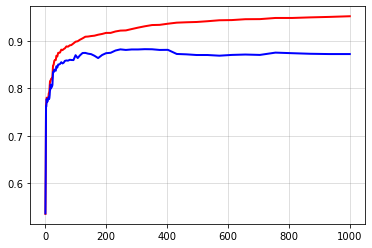

In [33]:
#things to plot
plt.plot(dimensions_used, scores_absolute, c="r", linestyle = '-', linewidth = 2, label = "Train")
plt.plot(dimensions_used, scores_cv, c="b", linestyle = '-', linewidth = 2, label = "8-fold cross validation")

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(1, 1000)
plt.xscale('log')
plt.ylim(0.70, 0.95)
plt.xlabel(r'Topics (Dimensions)', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Accuracy', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Logistic Regression Fit', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1, fontsize = 15, loc = 'lower right')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/cross_validation_adv_parse.png', bbox_inches='tight')

plt.show()

**Best cross validation score**

In [34]:
max_score = 0
for entry in zip(scores_cv, dimensions_used):
    if entry[0] > max_score:
        max_score = entry[0]
        max_d = entry[1]
print (max_score, max_d)

0.8828971025066444 327


**Conclusion**: Overall, 300 or so dimensions seems to be a good number as rapidly diminishing returns are found beyond this. The CV accuracy in this regime is ~0.88--not so bad.

# 7. Make and test a model with desired dimensionality

---

1. Create a k-fold receiver operating characteristic (ROC) curve (see: https://en.wikipedia.org/wiki/Receiver_operating_characteristic for more details).
  * This checks how well the model "separates" the two classes by plotting the "true positive rate" vs the "false positive rate" while moving the probability cutoff for classifying into one of the two categories (the default for classification is 50%).
2. Calculate various scores (train and test accuracies as well as the F1 score)
3. Generate a confusion matrix to see where the model goes wrong in classification

**Create the model and grab a few topics to look at later**

In [35]:
dimensions = 335
df_lsi_features, topics, lsi = latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions, True, 15, 20)

In [36]:
df_lsi_features.head()

,choose_one,0,1,2,3,4,5,6,7,8,...,325,326,327,328,329,330,331,332,333,334
0,Relevant,0.048770,0.046660,0.040569,-0.007110,-0.005816,-0.004522,-0.000126,-0.021958,0.001209,...,-0.017911,0.010921,-0.035162,-0.000520,-0.004014,0.033827,-0.035051,-0.009662,0.018702,0.036874
1,Relevant,0.072281,0.077954,0.017166,-0.001653,0.000166,-0.003631,-0.054455,-0.016502,0.008775,...,-0.000614,0.002591,-0.022518,0.006806,0.021282,-0.000397,0.015684,-0.023117,0.006560,-0.015036
2,Relevant,0.055081,0.059099,0.018615,0.030341,0.002176,-0.030089,-0.058473,-0.023630,-0.003643,...,0.023653,0.029372,-0.010584,-0.008702,0.004552,-0.043841,0.024030,0.018647,-0.043240,-0.015505
3,Relevant,0.043549,0.052270,0.000431,0.016217,0.019565,-0.021743,-0.010516,-0.014152,0.002650,...,0.028337,-0.007933,0.006644,0.027492,-0.027110,0.021791,-0.014705,0.016049,0.001275,-0.025148
4,Relevant,0.089233,0.097700,0.031506,-0.014812,0.033915,0.013321,0.026421,-0.016253,0.029993,...,0.008834,0.026776,-0.000655,-0.033969,0.023691,-0.035522,-0.009052,0.003789,0.038029,-0.007689


**Some data for the app to demonstrate topics**

In [37]:
df_plot_features_and_tweets = pd.DataFrame()
df_plot_features_and_tweets[['text', 'choose_one']] = df_filtered[['text', 'choose_one']]
df_plot_features_and_tweets[[0,1,2,3,4,5,6,7,8,9,10]] = df_lsi_features[[0,1,2,3,4,5,6,7,8,9,10]]

In [38]:
df_plot_features_and_tweets.to_csv('./data/plot_features_and_tweets.csv')

**Save the lsi model for use in online app**

In [39]:
lsi.save('./model/model.lsi')

**Function to perform a k-fold ROC analysis and plot the results**

In [40]:
#so a dimensionality of ~100 seems perfectly fine... lets use this dimensionality and create a k-fold ROC curve
def k_fold_roc(df, dim, cross_val_num):
    #model used
    model = linear_model.LogisticRegression(class_weight = "balanced", C = 1)
    
    #create X and y data but need as a numpy array for easy cv ROC implementation
    #also need to usue dummies for the ROC curve so convert them en route
    X = pd.DataFrame.as_matrix(df[[i for i in range(dim)]])
    y = pd.get_dummies(df["choose_one"])["Relevant"]
    
    #create the cross validation entity to extract the dat from sequentially
    cv = cross_validation.StratifiedKFold(y, n_folds = cross_val_num)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    roc_data = []
    for i, (train, test) in enumerate(cv):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        roc_data.append([fpr, tpr, ('%d (area = %0.2f)' % (i, roc_auc))])
    
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    roc_data.append([mean_fpr, mean_tpr, ('Mean (area = %0.2f)' % mean_auc)])
        
    return roc_data

**Generate the k-fold ROC curve and plot**

In [41]:
cross_val_num = 8
roc_data = k_fold_roc(df_lsi_features, dimensions, cross_val_num)

AttributeError: type object 'DataFrame' has no attribute 'as_matrix'

NameError: name 'roc_data' is not defined

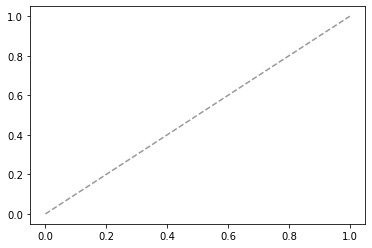

In [42]:
#color palette
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

i=0
for roc in roc_data[:-1]:
    plt.plot(roc[0], roc[1], lw=2, label=roc[2], color = tableau20[i])
    i = i + 1

roc = roc_data[-1]
plt.plot(roc[0], roc[1], 'k-', lw=3, label=roc[2])
    
#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
    
#axis and label details
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, fontdict = axis_label_font)
plt.ylabel('True Positive Rate', fontsize=20, fontdict = axis_label_font)
    
#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title(('%d-fold ROC analysis' % cross_val_num), y=1.05, fontdict = title_font)
    
#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1
                        , fontsize = 15, loc = 'lower right', bbox_to_anchor=(1.0, 0.0))
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/roc_adv_parse.png', bbox_inches='tight')
    
plt.show()


The ROC analysis suggests the model does a good job at separating out the classes. 

**Fit a logistic regression model (one test-train split)**

  1. Calculate train accuracy
  2. Calculate test accuracy
  3. Calculate the F1 score
  4. Generate a confusion matrix

In [43]:
from sklearn.linear_model import LogisticRegression

In [53]:
#make the X and y
X = df_lsi_features[[i for i in range(dimensions)]]
y = df_lsi_features["choose_one"]

#split into test and train
X_train, X_test, y_train, y_test = cross_validate.train_test_split(X, y, train_size = 0.80)

#make the model
model = linear_model.LogisticRegression(class_weight = "balanced", C = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#various "fitness" metrics
print("Train accuracy: %f \n" % model.score(X_train, y_train))
print("Test accuracy: %f \n" % model.score(X_test, y_test))
print("F1 score: %f \n" % metrics.f1_score(y_test, y_pred, labels=None, pos_label='Relevant', average='binary', sample_weight=None))

#confusion matrix
cm = metrics.confusion_matrix(y_test, model.predict(X_test))
print("Confusion matrix: \n")
print("-Legend")
print(np.array([['True "not disaster"', 'False "disaster"'],['False "not disaster"', 'True "disaster"']]))
print("\n-Prediction")
print(cm)

AttributeError: 'function' object has no attribute 'train_test_split'

**For good measure, generate and save final model to use in online app**

In [45]:
#make the X and y
X = df_lsi_features[[i for i in range(dimensions)]]
y = df_lsi_features["choose_one"]

#make the modeldf_lsi_features[[i for i in range(dimensions)]]
model = linear_model.LogisticRegression(class_weight = "balanced", C = 1)
model.fit(X, y)

LogisticRegression(C=1, class_weight='balanced')

In [46]:
import dill

ModuleNotFoundError: No module named 'dill'

In [47]:
dill.dump(model, open("./model/log_reg_model.dill", "wb"))

NameError: name 'dill' is not defined

Overall, the three scores are very good for this model. It may be desirable to change the cutoff for classification to lean towards false disaster prediction--the consequences of missing a disaster far outweigh the cost of misclassifying some. This is a balance of course as you don’t want to say everything is a disaster. 

# 8. Check out the "topics"

---

  1. Print out the top 15 topics with the top 20 tokens they are composed of
  2. Plot some topics against each other with colors to indicate class
  
### **NOTE**: There is an online interactive version of this on the app
### https://twitter-disaster-detection.herokuapp.com/about

**Print the topics**

In [48]:
for topic in topics:
    print("Topic %d:" % topic[0])
    print(topic[1] + "\n")

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Topic %d:" % topic[0])? (<ipython-input-48-e390500e1da7>, line 2)

The topics seem to progressively become more relevant to disasters based on the words. The lower order ones will likely serve as better for identifying non-disasters while later ones disasters. This can be confirmed by plotting the topics against one another.

**Plot topics**

Topic 1 seems better for identifying non-disasters while topic 9 is better for disasters. Let’s check...

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

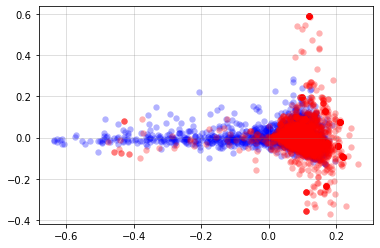

In [49]:
#set the two topics
feature_1 = 1
feature_2 = 9

#extract the data for plotting
feature_1_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_1]
feature_2_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_2]
feature_1_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_1]
feature_2_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_2]

#things to plot
plt.scatter(feature_1_not_relevant, feature_2_not_relevant, c="b", s=40, alpha=0.3, linewidths=0.0, label = "Not Disaster")
plt.scatter(feature_1_relevant, feature_2_relevant, c="r", s=40, alpha=0.3, linewidths=0.0, label = "Disaster")


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(-0.8, 0.4)
#plt.xscale('log')
plt.ylim(-0.4, 0.6)
plt.xlabel(r'Topic ' + str(feature_1), y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Topic ' + str(feature_2), fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Features', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1, fontsize = 15, loc = 'lower left')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/topics-adv_parse.png', bbox_inches='tight')
    
plt.show()

Indeed, the topics match our intuition based on what tokens they contain! Topic 1 pulls out many non-disaster tweets from the "clump" near the origin while topic 9 does the same (though more weakly so) for disaster tweets. With hundreds of topics to work with, good separation is possible.

**To be continued...**